In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.width', 1000)
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    # predicted values
    y_pred: list = None
    y_pred_mape: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
insidemethodslist = ["W","D3(0)","D3(BJ)"]

methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "TPSS" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../Datasets/TZVP/"
basis_set = rootdir.split('/')[-2]   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=False)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [4]:
allfeatures = set()
metricsets = ["SMALL_MOLECULES","LARGE_SYSTEMS","BARRIER_HEIGHTS",\
              "INTERMOLECULAR_INTERACTIONS","INTRAMOLECULAR_INTERACTIONS"]
includeFull = True

for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# This lists and dictionaries are empty since the metrics calculations are
# going to fill them

for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}

    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

# This section calculates the metrics for the data base considering the 
# differences respect to CCSD(T) energies

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
# Here are stored all the calculated metrics

        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)    
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)
 
# And here there are compared to choose the best one which should be the
# one that has the smallest value

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            #models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].bestinsidemethod = insidemethodslist[methodid]
            models_results[setname].y_pred_bestinsidemethod = y_pred

# This section calculates the metrics for our DFT calculations
# using different functionals

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])

# Calculation...

        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        
        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

# ...and comparison

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

######################################################################################
# WTMAD2 Calculation for reference methods (wtmad_ref):

wtmad2_ref = commonutils.wtmad_ref(fullsetnames, metricsets, howmanydifs,allvalues_perset, includeFull)

print("WTMAD-2 for inside methods", "\n")
print(wtmad2_ref, '\n')

# WTMAD2 Calculation for our methods (wtmad):

wtmad2 = commonutils.wtmad(fullsetnames, metricsets, methods,allvalues_perset, includeFull)

print("WTMAD-2 for our methods", "\n")
print(wtmad2, "\n")


######################################################################################

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)

WTMAD-2 for inside methods 

                      Superset  WTMAD-2_0  WTMAD-2_1  WTMAD-2_2
0              SMALL_MOLECULES      13.26      13.01      13.31
1                LARGE_SYSTEMS      21.11      17.04      16.05
2              BARRIER_HEIGHTS       8.04       8.50       8.82
3  INTERMOLECULAR_INTERACTIONS       6.27       3.70       4.05
4  INTRAMOLECULAR_INTERACTIONS       1.59       0.69       0.78
5                         Full      14.10      10.16      10.57 

WTMAD-2 for our methods 

                      Superset  WTMAD-2_PBE  WTMAD-2_PBE0  WTMAD-2_TPSS  WTMAD-2_TPSSh
0              SMALL_MOLECULES        14.30         10.14         13.18          11.71
1                LARGE_SYSTEMS        16.48         11.33         16.58          13.95
2              BARRIER_HEIGHTS         9.47          4.97          8.39           6.63
3  INTERMOLECULAR_INTERACTIONS         6.05          4.24          4.59           4.03
4  INTRAMOLECULAR_INTERACTIONS         0.92          0.64   

In [5]:
# Energy Check: Identify the data sets that have the highest deviations from the true values.

rxn_threshold = 1
mean_threshold = 1

# As a first approach, only PBE errors are being considered

sel_method = "PBE"
methods_checked = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"]}

for setname in fullsetnames:
    for supersets in metricsets: # This loop iterates over supersets
        if setname.startswith(supersets+"_"):
            inner_error = []
            for j, method in enumerate(methods_checked): # This loop iterates over methods
                diff_list = []
                for val in allvalues_perset[setname]:
                    
                    energy_diff = (val['label']+val['difs'][2])- \
                                  val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"]
                    rxn_error = abs(energy_diff/val['label']+val['difs'][2])

                    if rxn_error > rxn_threshold and method == sel_method:
                        print(setname)
                        print(method)
                        print(val['chemicals'])
                        print(f"Reference Energy PBE/CBS: {val['label']+val['difs'][2]}")
                        print("Reaction Energy PBE/MINIX:", round(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"],2))
                        print("Reaction Energy Error: ", round(rxn_error,2), "\n")

                    inner_error.append(rxn_error)

            mean_error = np.mean(inner_error)

            if mean_error > mean_threshold:
                print("============================================================")
                print(f"Mean Error of {setname}: {round(mean_error,2)}")
                print("============================================================","\n")

            else:
                print("============================================================")
                print(f"Mean Error of {setname} is lower than: {mean_threshold}")
                print("============================================================","\n")

            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

BARRIER_HEIGHTS_BH76
PBE
['h', 'n2o', 'n2ohts']
Reference Energy PBE/CBS: 9.739999999999998
Reaction Energy PBE/MINIX: 10.23
Reaction Energy Error:  7.99 

BARRIER_HEIGHTS_BH76
PBE
['oh', 'n2', 'n2ohts']
Reference Energy PBE/CBS: 51.849999999999994
Reaction Energy PBE/MINIX: 50.8
Reaction Energy Error:  30.74 

BARRIER_HEIGHTS_BH76
PBE
['h', 'hf', 'hfhts']
Reference Energy PBE/CBS: 28.18
Reaction Energy PBE/MINIX: 27.6
Reaction Energy Error:  13.91 

BARRIER_HEIGHTS_BH76
PBE
['hf', 'h', 'hfhts']
Reference Energy PBE/CBS: 28.18
Reaction Energy PBE/MINIX: 27.6
Reaction Energy Error:  13.91 

BARRIER_HEIGHTS_BH76
PBE
['h', 'hcl', 'hclhts']
Reference Energy PBE/CBS: 9.56
Reaction Energy PBE/MINIX: 10.3
Reaction Energy Error:  8.28 

BARRIER_HEIGHTS_BH76
PBE
['hcl', 'h', 'hclhts']
Reference Energy PBE/CBS: 9.56
Reaction Energy PBE/MINIX: 10.3
Reaction Energy Error:  8.28 

BARRIER_HEIGHTS_BH76
PBE
['h', 'ch3f', 'hfch3ts']
Reference Energy PBE/CBS: 18.509999999999998
Reaction Energy PBE/MINI

In [6]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Kinetic_Energy  
                     PBE_Potential_Energy 0.98
                      PBE0_Kinetic_Energy 0.98
                    TPSS_Potential_Energy 0.98
                      TPSS_Kinetic_Energy 1.00
                     TPSSh_Kinetic_Energy 0.99
PBE_E(C)  
                                PBE0_E(C) 1.00
                                TPSS_E(C) 1.00
                               TPSSh_E(C) 1.00
PBE_E(X)  
                                PBE0_E(X) 1.00
                                TPSS_E(X) 1.00
                               TPSSh_E(X) 0.99
PBE_Dispersion_correction  
               PBE0_Dispersion_correction 1.00
               TPSS_Dispersion_correction 1.00
              TPSSh_Dispersion_correction 1.00
PBE_Nuclear_Repulsion  
                  PBE_One_Electron_Energy 1.00
                  PBE_Two_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 PBE0_Two_Electron_Energy 1.00
                 PBE0_One_Electron_Energy 1.00
            

[1.0003857] -14.524090604543744
[-2.00078545] 58.979780320223654


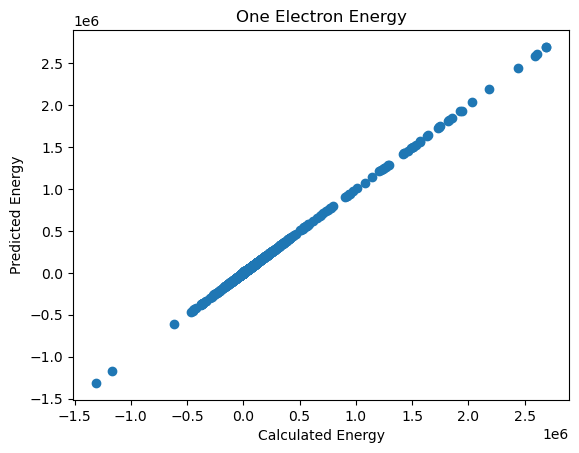

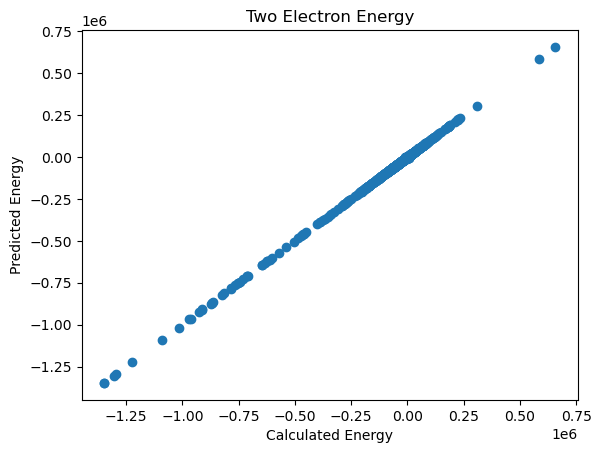

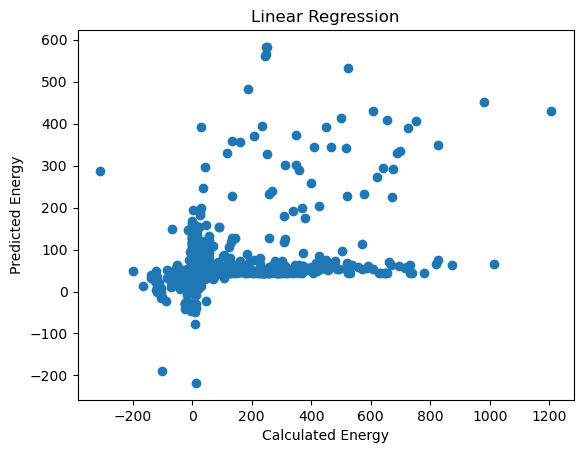

   10.6458    43.2666 121.01
   51.4929    35.0032  38.13
   27.7275    43.6014  44.51
   27.7275    43.6014  44.51
   10.5336    43.1441 121.50
   10.5336    43.1441 121.50
   19.8125    44.1109  76.02
   40.4982    38.4598   5.16
   -8.4892    43.7733 296.24
   77.9134    37.3719  70.33
   -5.5911    35.3634 275.12
   41.5881    29.8623  32.82
  -14.6878    37.1954 461.03
  -14.6878    37.1954 461.03
    5.2779    43.9530 157.12
    5.2779    43.9530 157.12
   -7.4654    29.6806 334.42
   -7.4654    29.6806 334.42
    5.6990    43.6436 153.80
    5.6990    43.6436 153.80
  -26.5551    35.7458 1355.74
   10.8208    32.2451  99.50
   -2.6045    44.4496 224.90
   22.0398    42.9027  64.25
  -17.7433    37.6372 556.76
    3.1895    37.2785 168.47
   -0.2426    44.0607 202.21
   44.8084    45.5013   1.53
    5.4566    43.5174 155.43
    8.4867    44.4882 135.92
   -1.6672    43.6328 215.89
   24.2849    44.6422  59.07
   -0.0796    43.5955 200.73
   40.2451    44.4871  10.01
    1.4716   

In [7]:
# test two linear models to predict energudiff
# LinearRegression
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?


In [8]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   PBE0_Nuclear_Repulsion
2   TPSS_One_Electron_Energy
3   TPSSh_Dispersion_correction
4   PBE0_One_Electron_Energy
5   PBE_One_Electron_Energy
6   TPSS_FINAL_SINGLE_POINT_ENERGY
7   PBE_Two_Electron_Energy
8   TPSSh_FINAL_SINGLE_POINT_ENERGY
9   PBE0_Two_Electron_Energy
10   TPSSh_Nuclear_Repulsion
11   TPSSh_One_Electron_Energy
12   TPSS_Potential_Energy
13   PBE0_Kinetic_Energy
14   PBE0_E(X)
15   TPSSh_E(X)
16   PBE0_E(C)
17   TPSS_E(C)
18   TPSS_Two_Electron_Energy
19   TPSS_Nuclear_Repulsion
20   PBE0_FINAL_SINGLE_POINT_ENERGY
21   TPSSh_E(C)
22   TPSSh_Kinetic_Energy
23   PBE0_Dispersion_correction
24   TPSSh_Two_Electron_Energy
25   PBE_Potential_Energy
26   TPSS_Dispersion_correction
27   TPSS_Kinetic_Energy
28   TPSS_E(X)
29   TPSSh_Potential_Energy


In [9]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE0_Potential_Energy
2 PBE_FINAL_SINGLE_POINT_ENERGY
3 PBE_E(X)
4 PBE_Nuclear_Repulsion
5 PBE_E(C)
6 PBE_Kinetic_Energy
7 PBE_Dispersion_correction


In [10]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<Axes: >

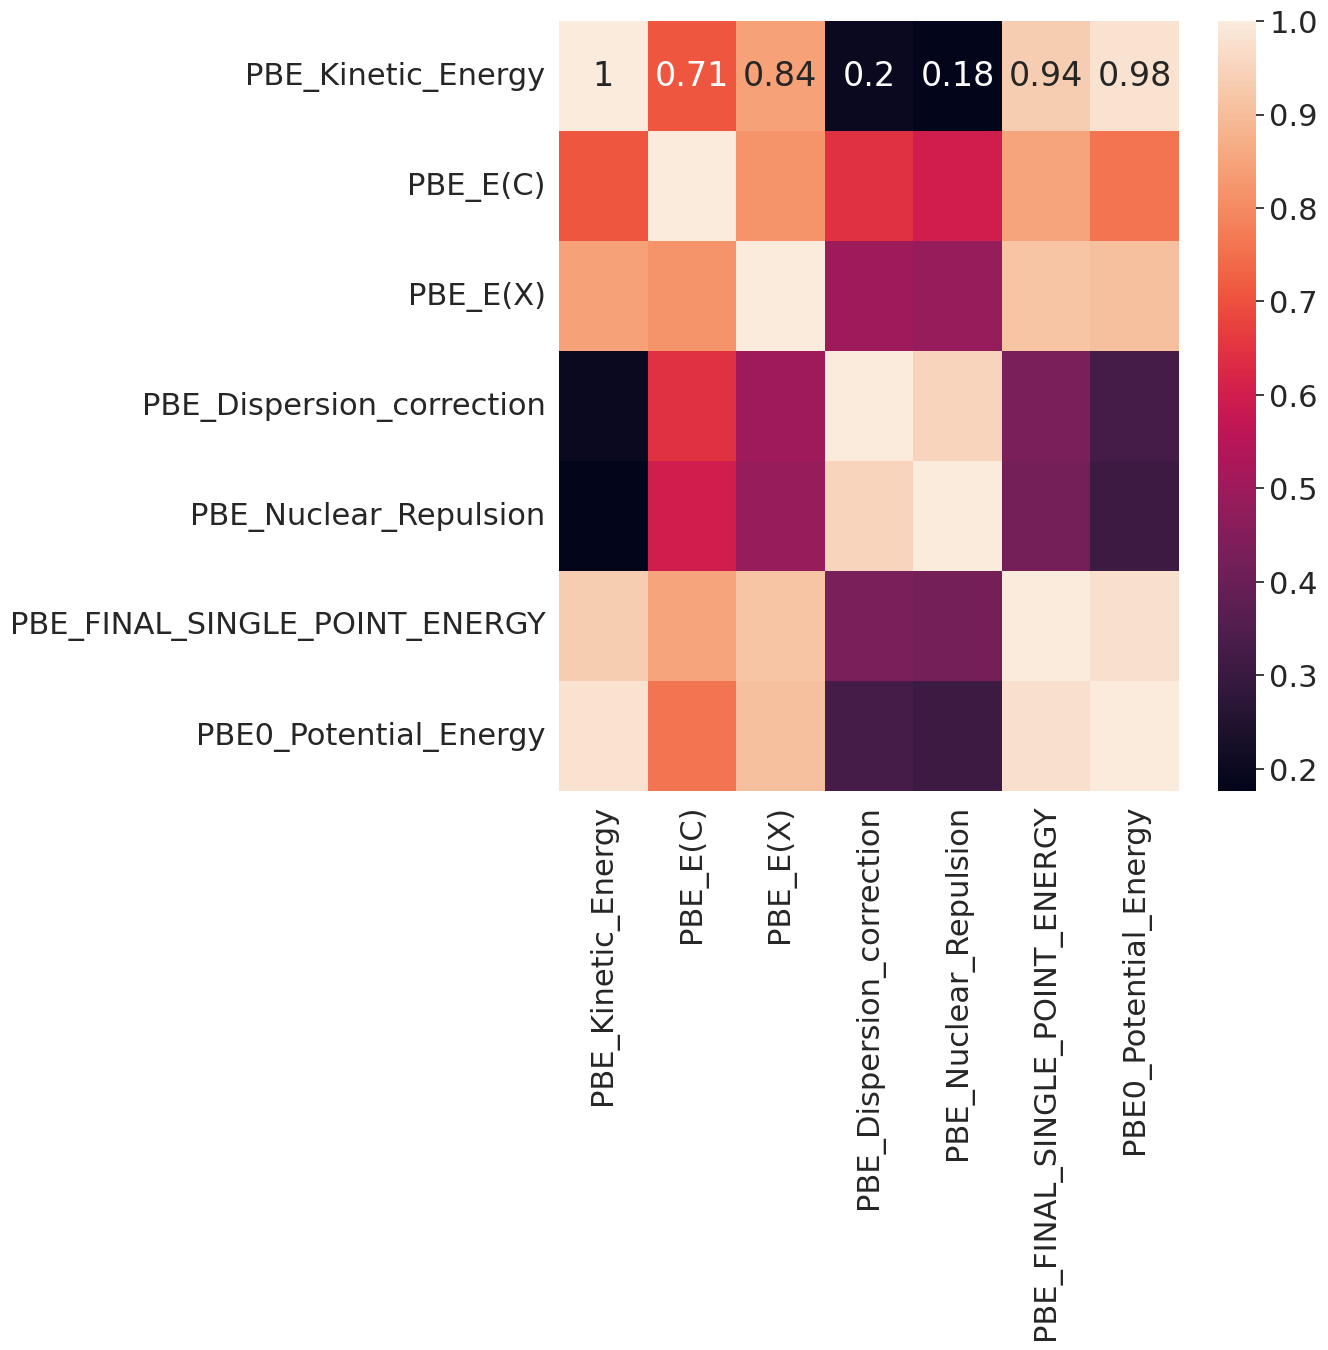

In [11]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [12]:
# search for the best model a simple grid search
#nepochs = [50, 100]
nepochs = [100]
#batch_sizes = [4, 8, 16, 32]
batch_sizes = [16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
setname = "Full"
X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminmape, modelminrmse = \
        models.nn_model(0.2, X_s, Y_s, \
                    nepochs, modelshapes, batch_sizes, inputshape=-1,\
                    search=True)
    
print("Best NN model for set: ", setname, file=sys.stderr)
print("  RMSE: ", modelminrmse, file=sys.stderr)
print("  MAPE: ", modelminmape, file=sys.stderr)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  RMSE:  ([32, 32, 32, 32, 32, 32], 100, 32)
  MAPE:  ([16, 16, 16], 100, 32)


In [13]:
import importlib
importlib.reload(models)

#build the final model and print the results
results_mape = models.nn_model(0.2, X_s, Y_s, \
                    [modelminmape[1]], \
                    [modelminmape[0]], \
                    [modelminmape[2]], \
                    inputshape=-1,\
                    search=False)

results_rmse = models.nn_model(0.2, X_s, Y_s, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False)

48/48 [==============================] - 0s 549us/step


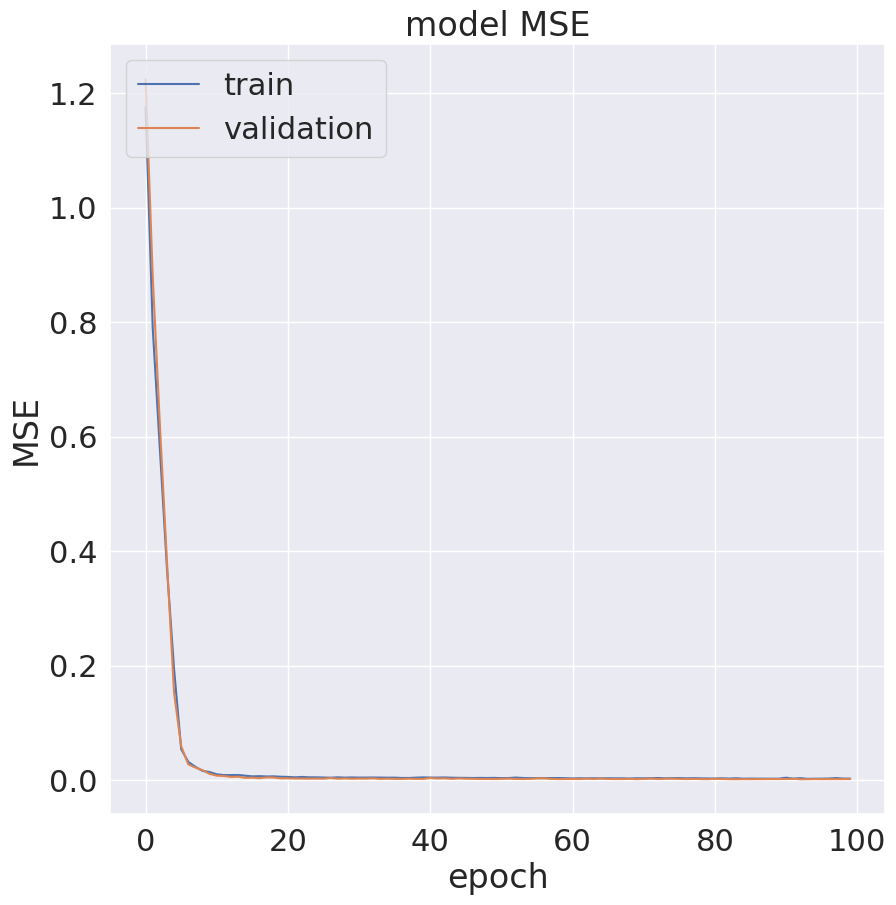

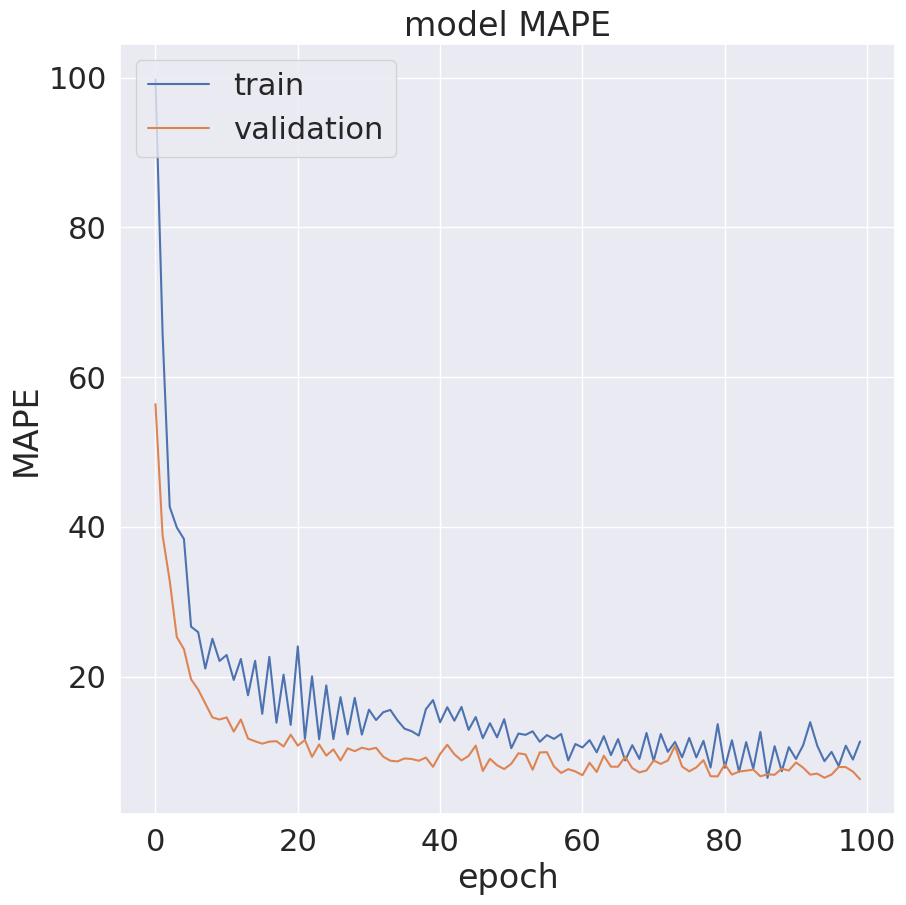

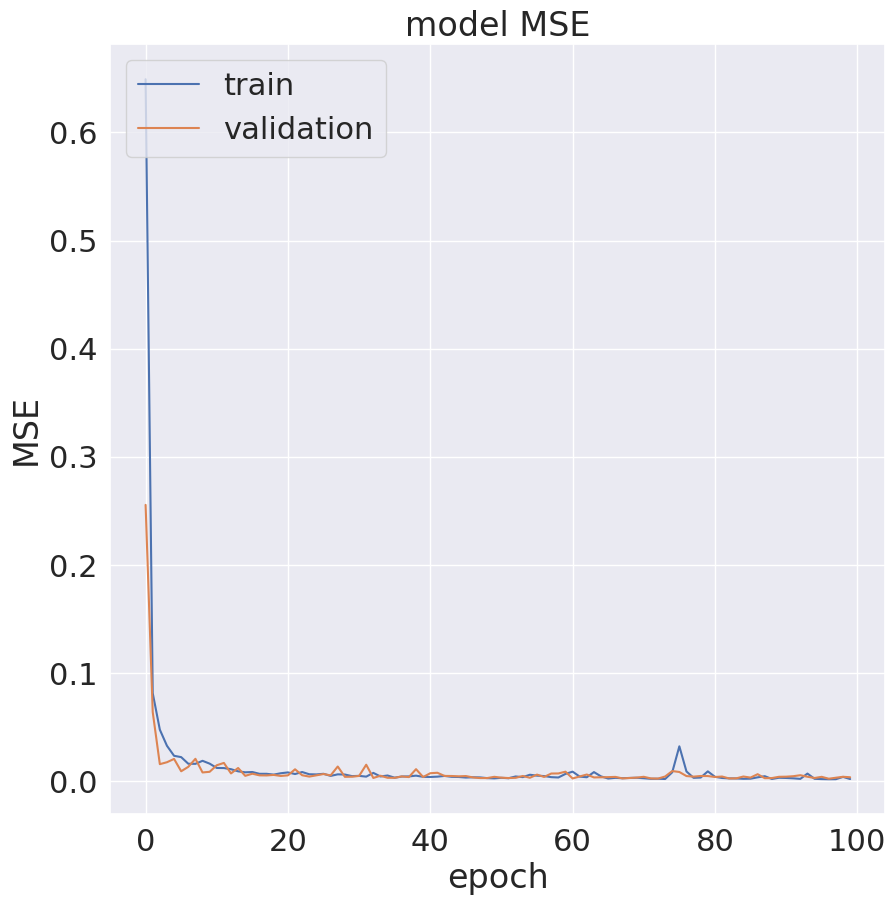

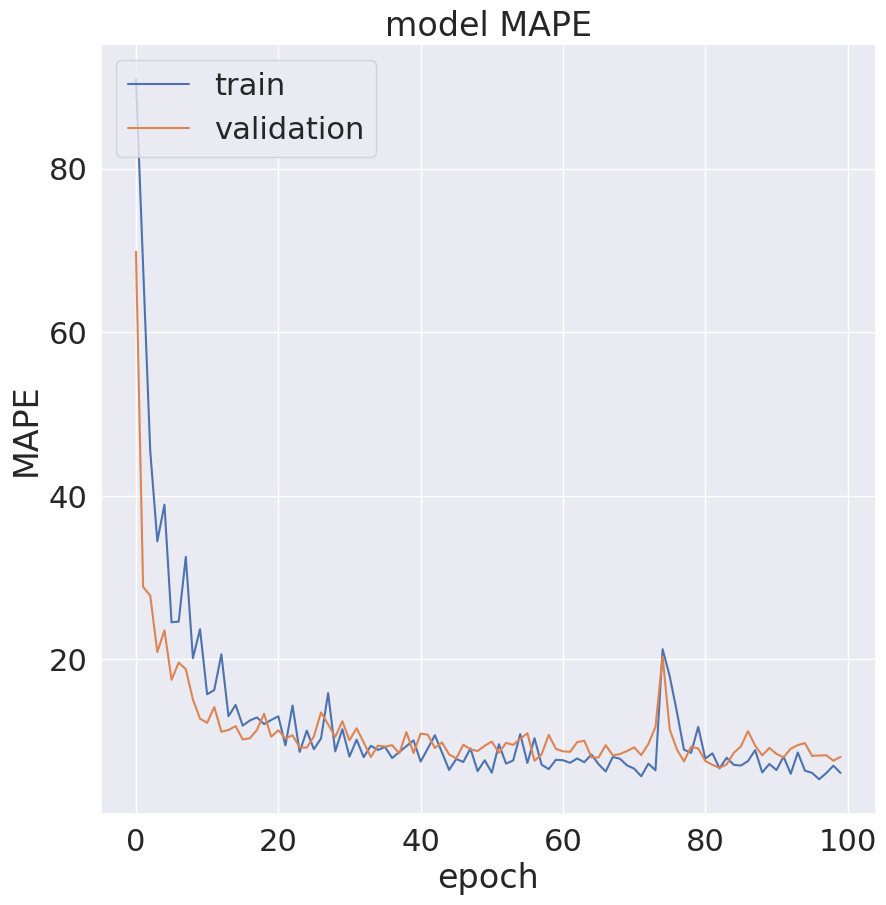

In [14]:
# summarize history for accuracy
history = results_mape['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
history = results_rmse['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


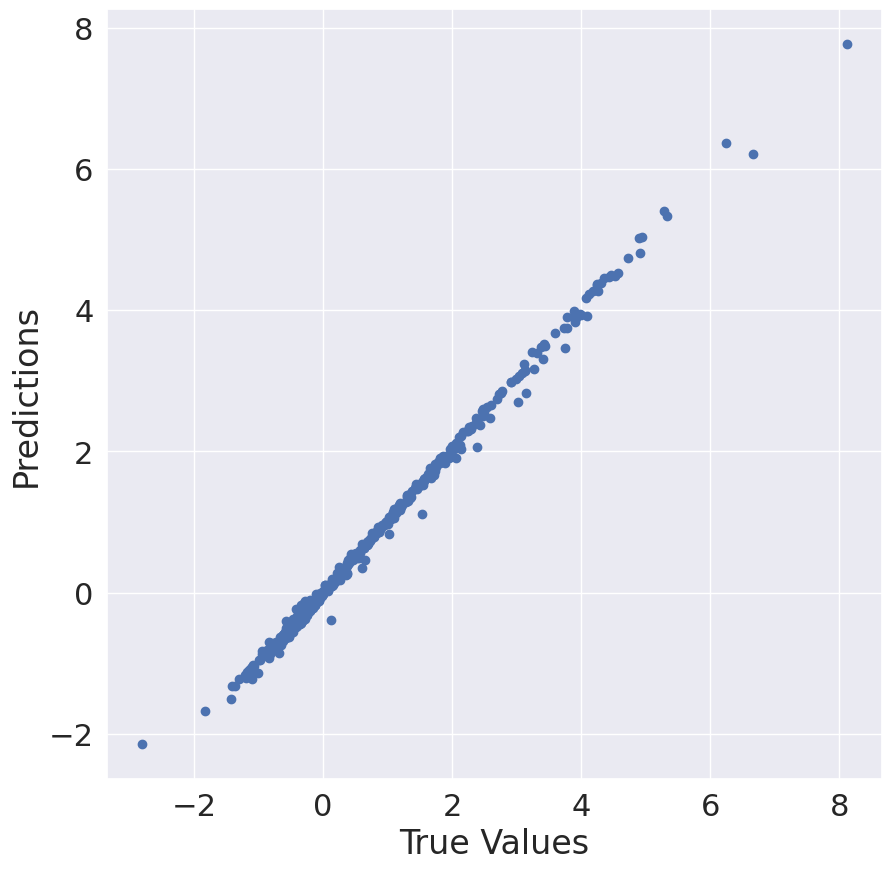

RMSE Full      :  7.33
R2 Full        :  1.00


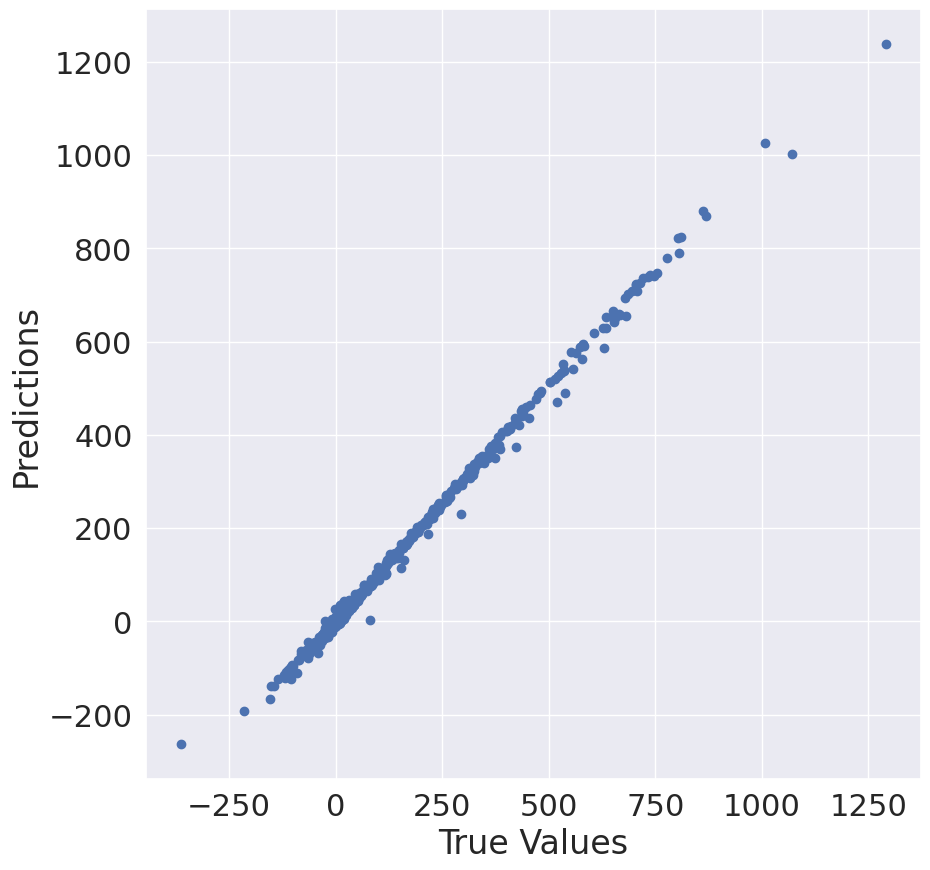

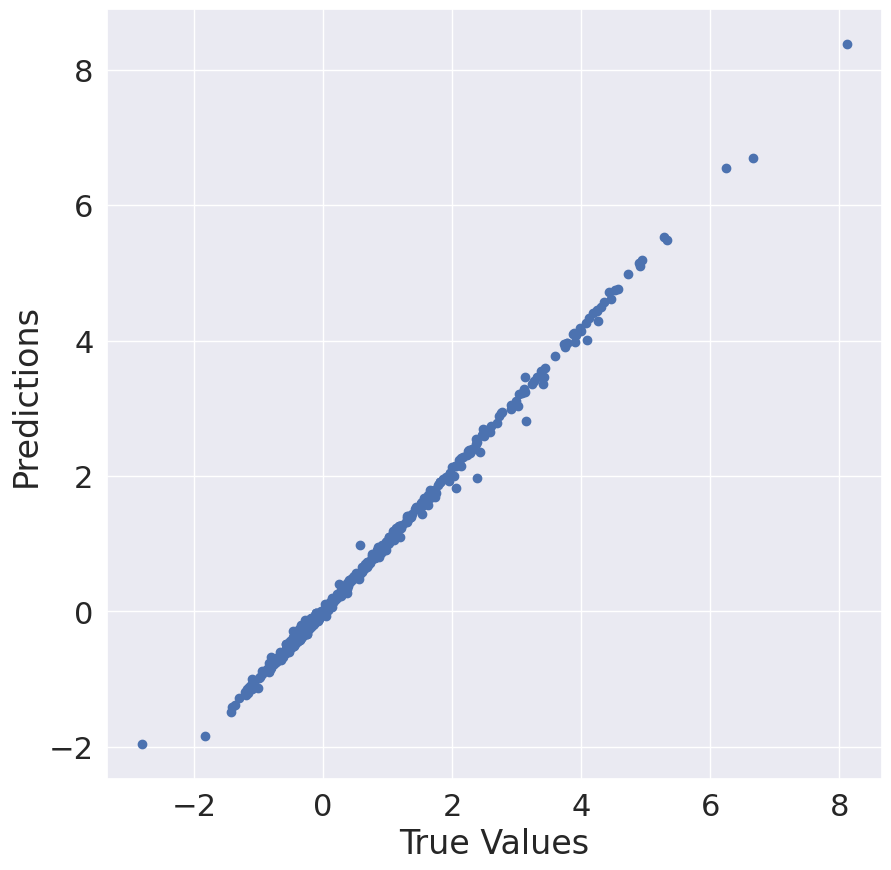

RMSE Full      :  8.21
R2 Full        :  1.00


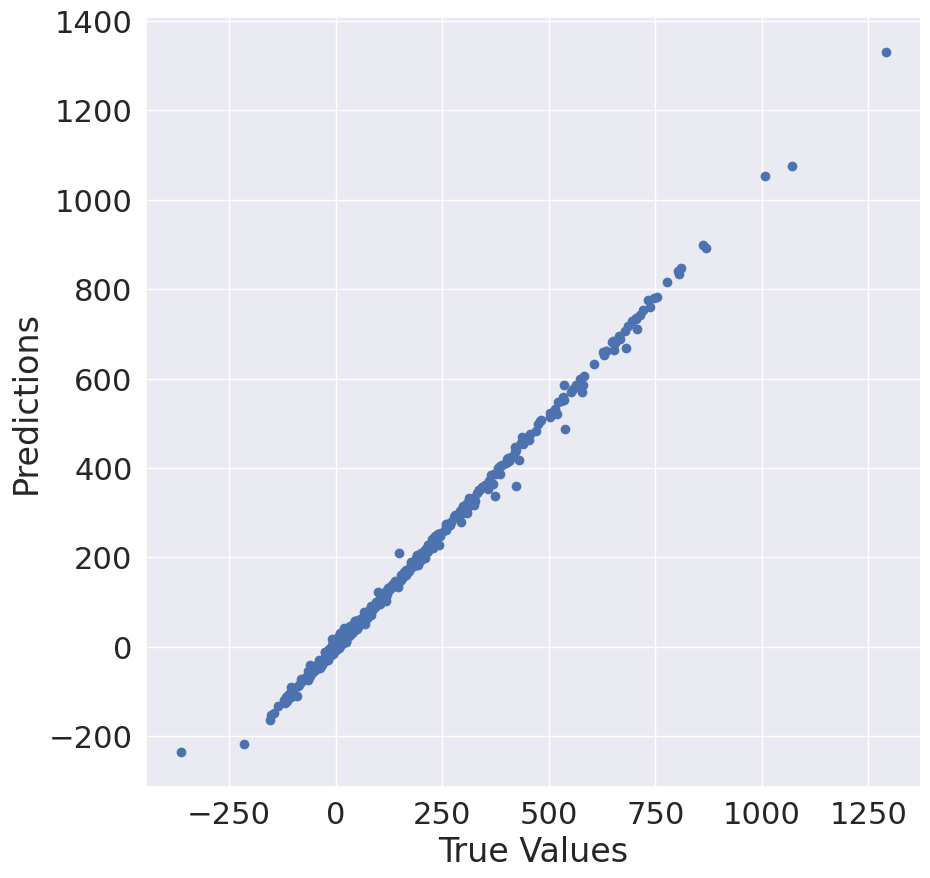

In [15]:
#denomrlize the results
plt.clf()
plt.scatter(results_mape['y_full'], \
            results_mape['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_mape['y_pred_full'])
y_full = scalery.inverse_transform(results_mape['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#denomrlize the results
plt.clf()
plt.scatter(results_rmse['y_full'], \
            results_rmse['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_rmse['y_pred_full'])
y_full = scalery.inverse_transform(results_rmse['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_percentage_error

print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred_mape = scalery.inverse_transform(results_mape['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape = y_pred_mape
    rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    r2 = r2_score(Y, y_pred_mape)
    mape = mean_absolute_percentage_error(Y, y_pred_mape)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , MAPE, R2
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    4.856  ,    7.359  ,    0.578  ,    0.872
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,    5.505  ,    6.737  ,    1.185  ,    0.873
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    5.278  ,    4.889  ,    0.143  ,    0.961
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    3.762  ,    3.834  ,    0.192  ,    0.853
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.718  ,    0.889  ,    0.197  ,    0.969
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    1.534  ,   16.002  ,    0.157  ,    0.519
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,    8.204  ,    3.617  ,    0.141  ,    0.935
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    5.887  ,    2.346  ,    0.264  ,    0.990
 291 ,         

In [17]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , MAPE, R2
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    4.856  ,    3.050  ,    0.337  ,    0.978
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,    5.505  ,    3.660  ,    0.565  ,    0.963
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    5.278  ,    4.544  ,    0.122  ,    0.967
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    3.762  ,    2.607  ,    0.250  ,    0.932
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.718  ,    1.439  ,    0.368  ,    0.919
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    1.534  ,    3.584  ,    0.150  ,    0.976
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,    8.204  ,    0.792  ,    0.024  ,    0.997
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    5.887  ,    1.313  ,    0.050  ,    0.997
 291 ,         

RMSE  BARRIER_HEIGHTS  :   3.05
MAPE  BARRIER_HEIGHTS  :   0.34
R2    BARRIER_HEIGHTS  :   0.98
RMSE MAPE BARRIER_HEIGHTS  :   7.36
MAPE MAPE BARRIER_HEIGHTS  :   0.58
R2   MAPE BARRIER_HEIGHTS  :   0.87


<Figure size 1000x1000 with 0 Axes>

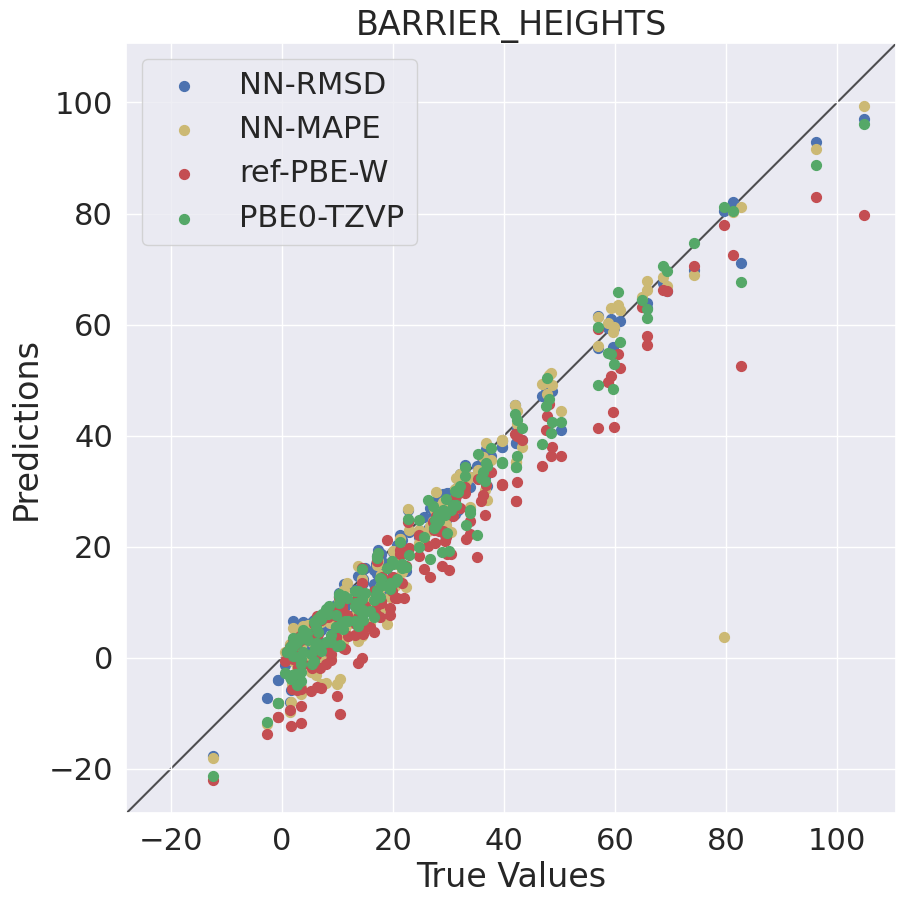

RMSE  BARRIER_HEIGHTS_BH76  :   3.66
MAPE  BARRIER_HEIGHTS_BH76  :   0.57
R2    BARRIER_HEIGHTS_BH76  :   0.96
RMSE MAPE BARRIER_HEIGHTS_BH76  :   6.74
MAPE MAPE BARRIER_HEIGHTS_BH76  :   1.19
R2   MAPE BARRIER_HEIGHTS_BH76  :   0.87


<Figure size 1000x1000 with 0 Axes>

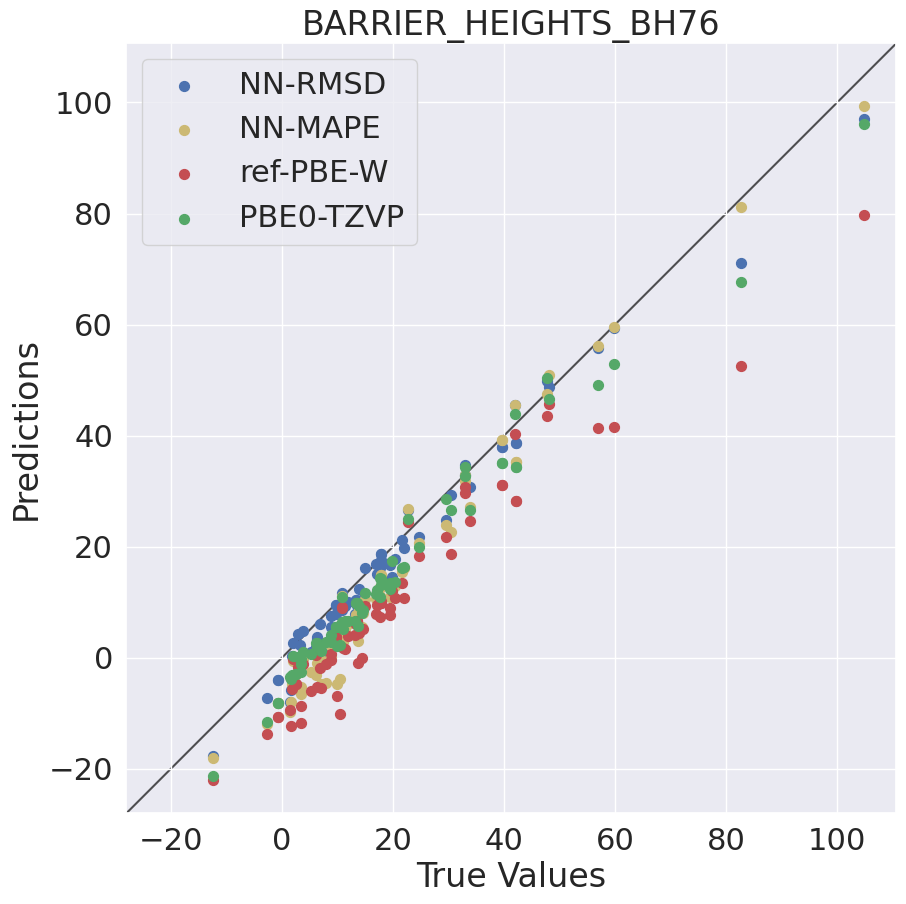

RMSE  BARRIER_HEIGHTS_BHDIV10  :   4.54
MAPE  BARRIER_HEIGHTS_BHDIV10  :   0.12
R2    BARRIER_HEIGHTS_BHDIV10  :   0.97
RMSE MAPE BARRIER_HEIGHTS_BHDIV10  :   4.89
MAPE MAPE BARRIER_HEIGHTS_BHDIV10  :   0.14
R2   MAPE BARRIER_HEIGHTS_BHDIV10  :   0.96


<Figure size 1000x1000 with 0 Axes>

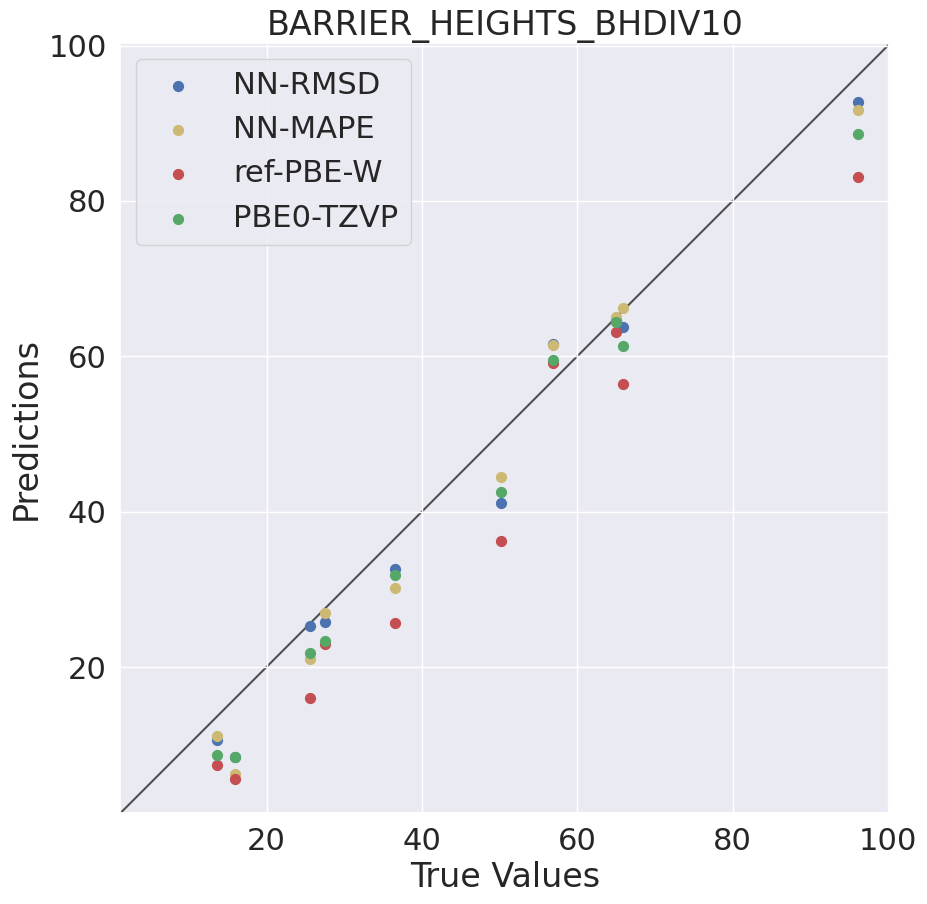

RMSE  BARRIER_HEIGHTS_BHPERI  :   2.61
MAPE  BARRIER_HEIGHTS_BHPERI  :   0.25
R2    BARRIER_HEIGHTS_BHPERI  :   0.93
RMSE MAPE BARRIER_HEIGHTS_BHPERI  :   3.83
MAPE MAPE BARRIER_HEIGHTS_BHPERI  :   0.19
R2   MAPE BARRIER_HEIGHTS_BHPERI  :   0.85


<Figure size 1000x1000 with 0 Axes>

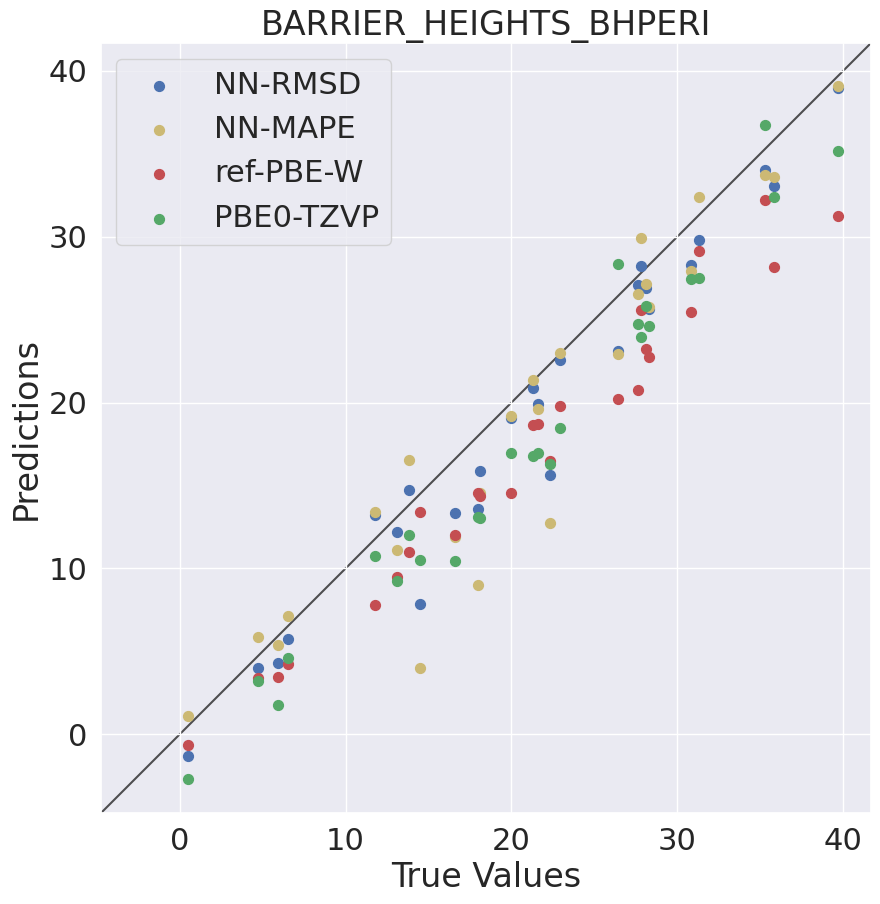

RMSE  BARRIER_HEIGHTS_BHROT27  :   1.44
MAPE  BARRIER_HEIGHTS_BHROT27  :   0.37
R2    BARRIER_HEIGHTS_BHROT27  :   0.92
RMSE MAPE BARRIER_HEIGHTS_BHROT27  :   0.89
MAPE MAPE BARRIER_HEIGHTS_BHROT27  :   0.20
R2   MAPE BARRIER_HEIGHTS_BHROT27  :   0.97


<Figure size 1000x1000 with 0 Axes>

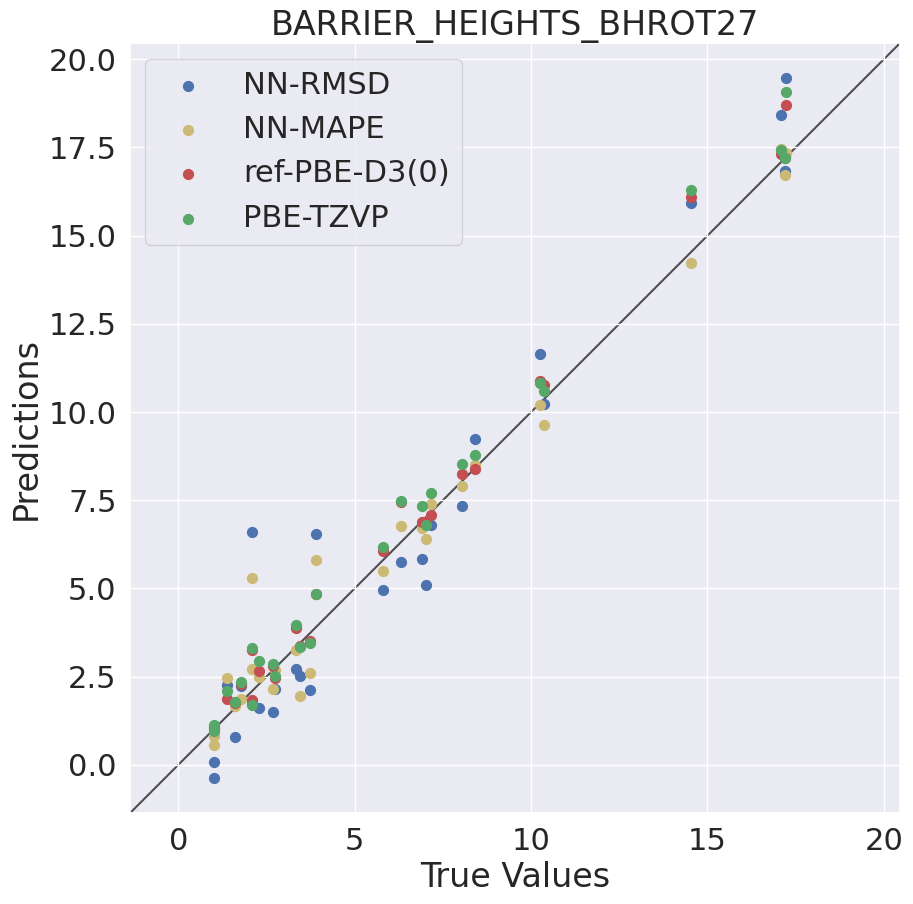

RMSE  BARRIER_HEIGHTS_INV24  :   3.58
MAPE  BARRIER_HEIGHTS_INV24  :   0.15
R2    BARRIER_HEIGHTS_INV24  :   0.98
RMSE MAPE BARRIER_HEIGHTS_INV24  :  16.00
MAPE MAPE BARRIER_HEIGHTS_INV24  :   0.16
R2   MAPE BARRIER_HEIGHTS_INV24  :   0.52


<Figure size 1000x1000 with 0 Axes>

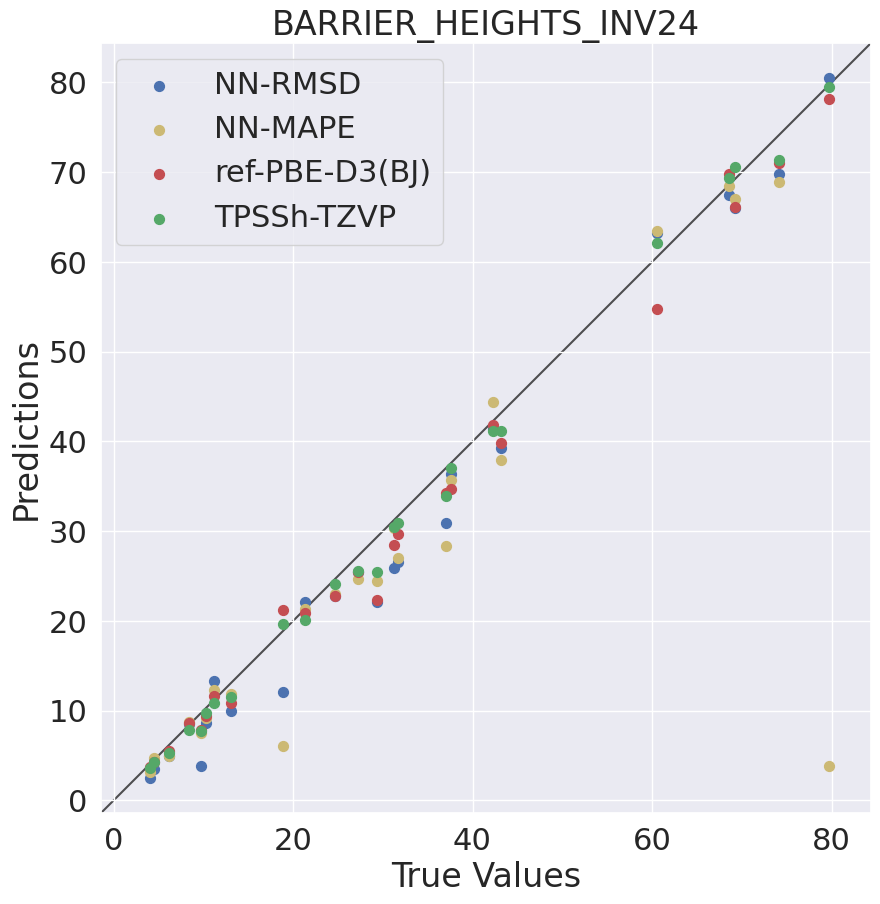

RMSE  BARRIER_HEIGHTS_PX13  :   0.79
MAPE  BARRIER_HEIGHTS_PX13  :   0.02
R2    BARRIER_HEIGHTS_PX13  :   1.00
RMSE MAPE BARRIER_HEIGHTS_PX13  :   3.62
MAPE MAPE BARRIER_HEIGHTS_PX13  :   0.14
R2   MAPE BARRIER_HEIGHTS_PX13  :   0.93


<Figure size 1000x1000 with 0 Axes>

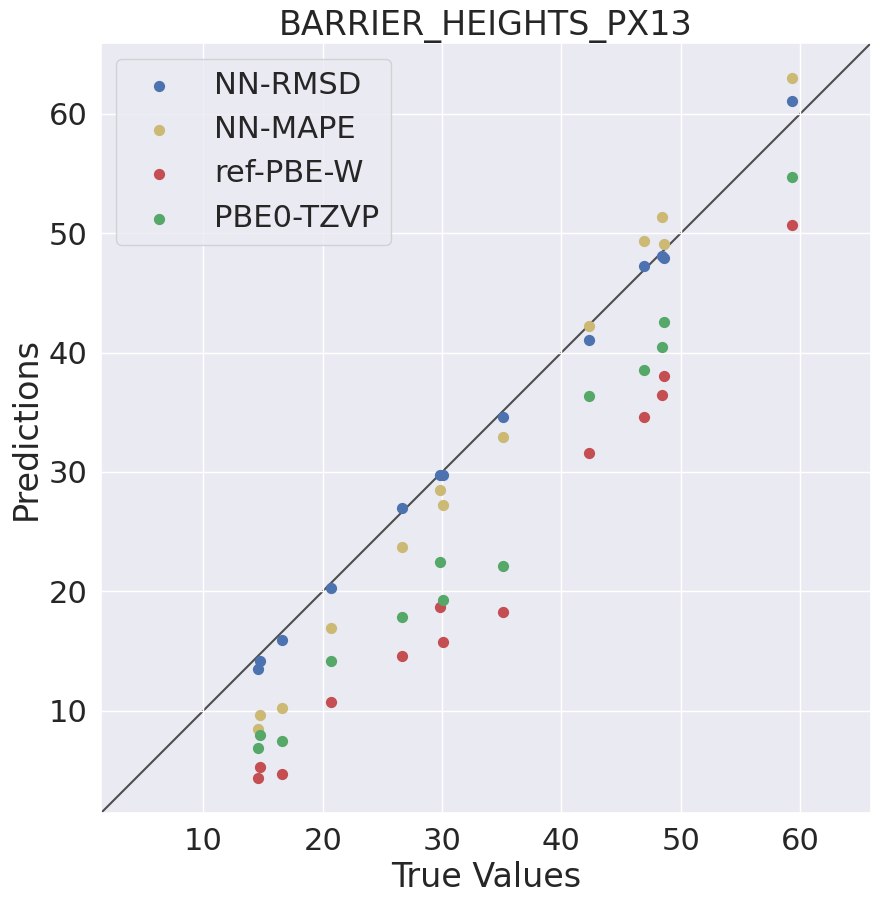

RMSE  BARRIER_HEIGHTS_WCPT18  :   1.31
MAPE  BARRIER_HEIGHTS_WCPT18  :   0.05
R2    BARRIER_HEIGHTS_WCPT18  :   1.00
RMSE MAPE BARRIER_HEIGHTS_WCPT18  :   2.35
MAPE MAPE BARRIER_HEIGHTS_WCPT18  :   0.26
R2   MAPE BARRIER_HEIGHTS_WCPT18  :   0.99


<Figure size 1000x1000 with 0 Axes>

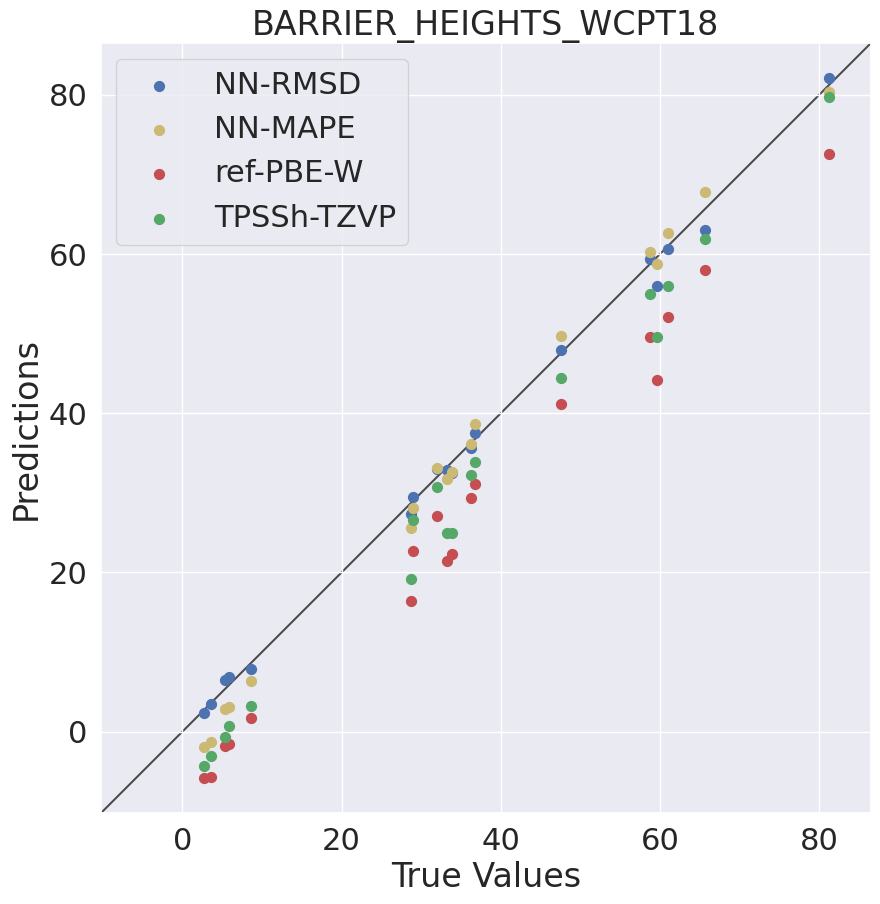

RMSE  INTRAMOLECULAR_INTERACTIONS  :   1.86
MAPE  INTRAMOLECULAR_INTERACTIONS  :   1.21
R2    INTRAMOLECULAR_INTERACTIONS  :   0.83
RMSE MAPE INTRAMOLECULAR_INTERACTIONS  :   2.29
MAPE MAPE INTRAMOLECULAR_INTERACTIONS  :   0.62
R2   MAPE INTRAMOLECULAR_INTERACTIONS  :   0.73


<Figure size 1000x1000 with 0 Axes>

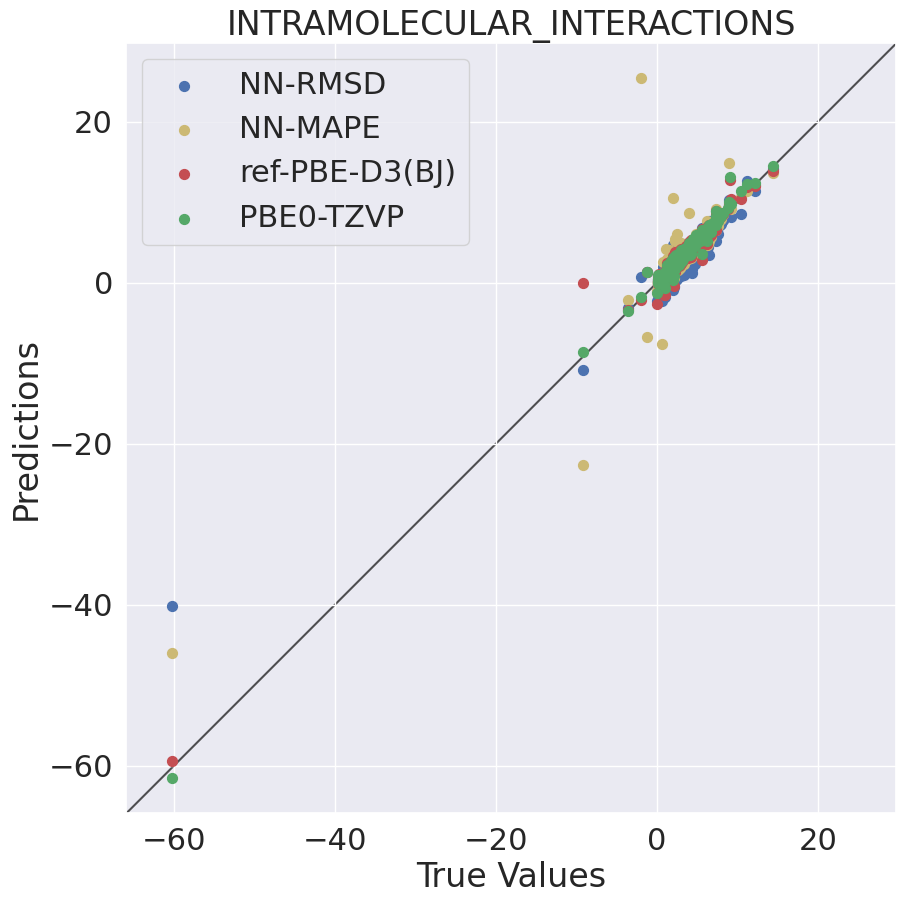

RMSE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.52
MAPE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.26
R2    INTRAMOLECULAR_INTERACTIONS_ACONF  :  -0.43
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   0.15
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   0.09
R2   MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   0.99


<Figure size 1000x1000 with 0 Axes>

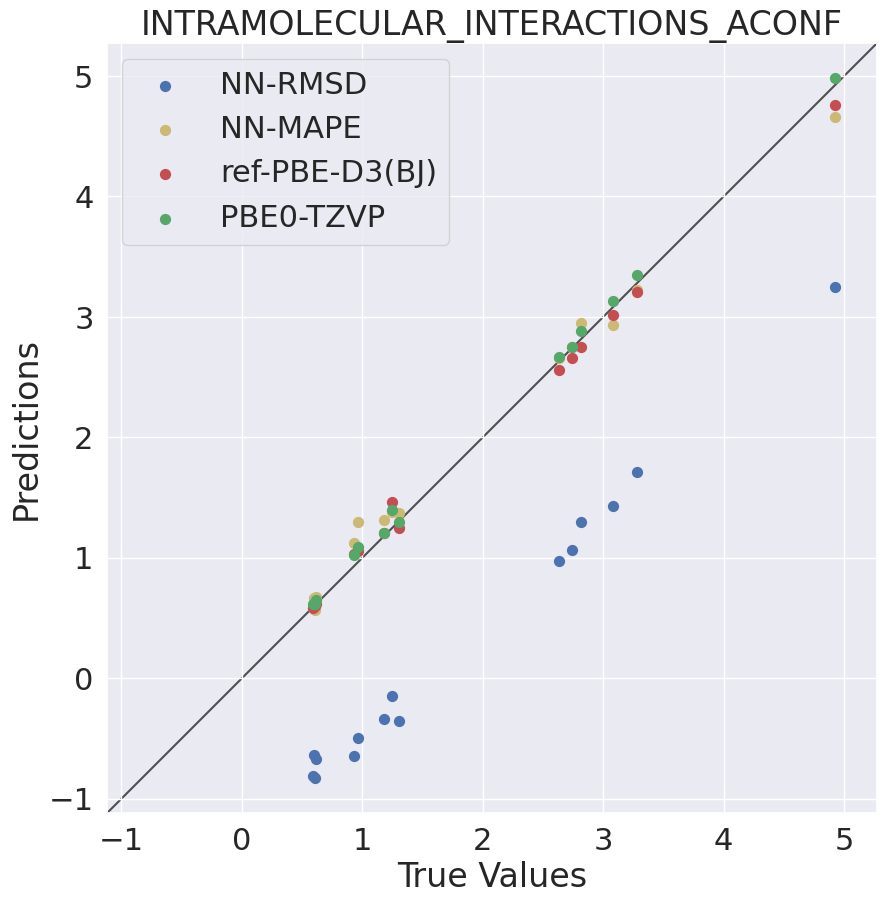

RMSE  INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   1.29
MAPE  INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   1.31
R2    INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   0.43
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   0.47
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   0.39
R2   MAPE INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   0.92


<Figure size 1000x1000 with 0 Axes>

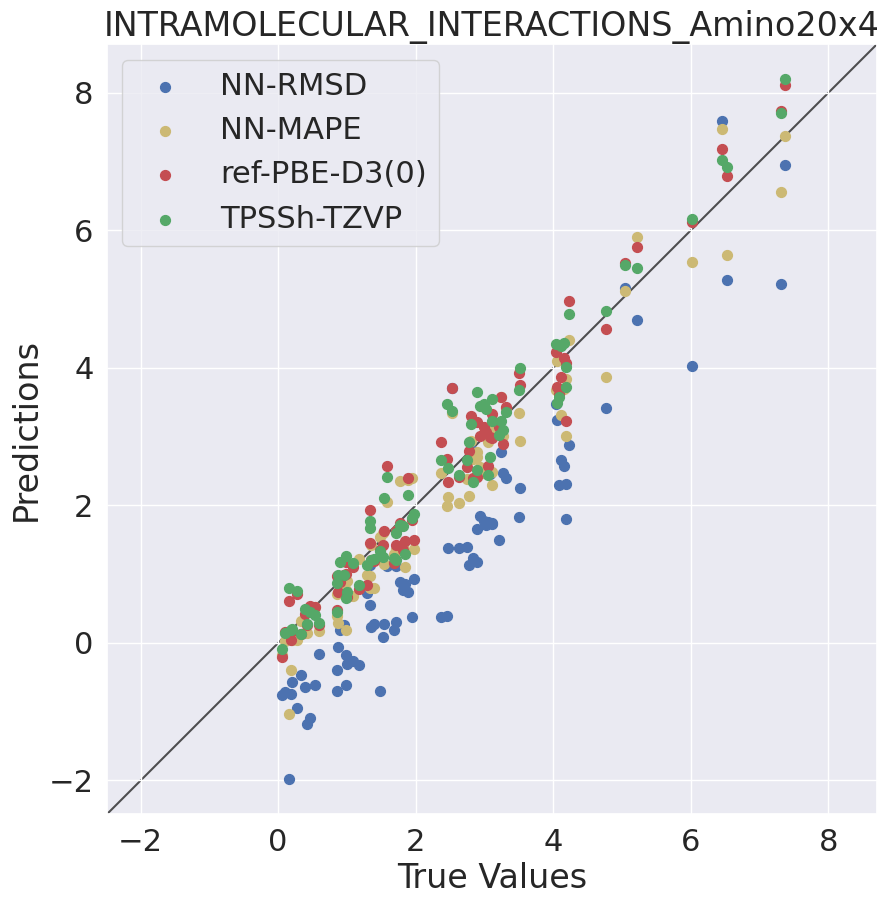

RMSE  INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   1.55
MAPE  INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.64
R2    INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :  -2.78
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.64
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.23
R2   MAPE INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.36


<Figure size 1000x1000 with 0 Axes>

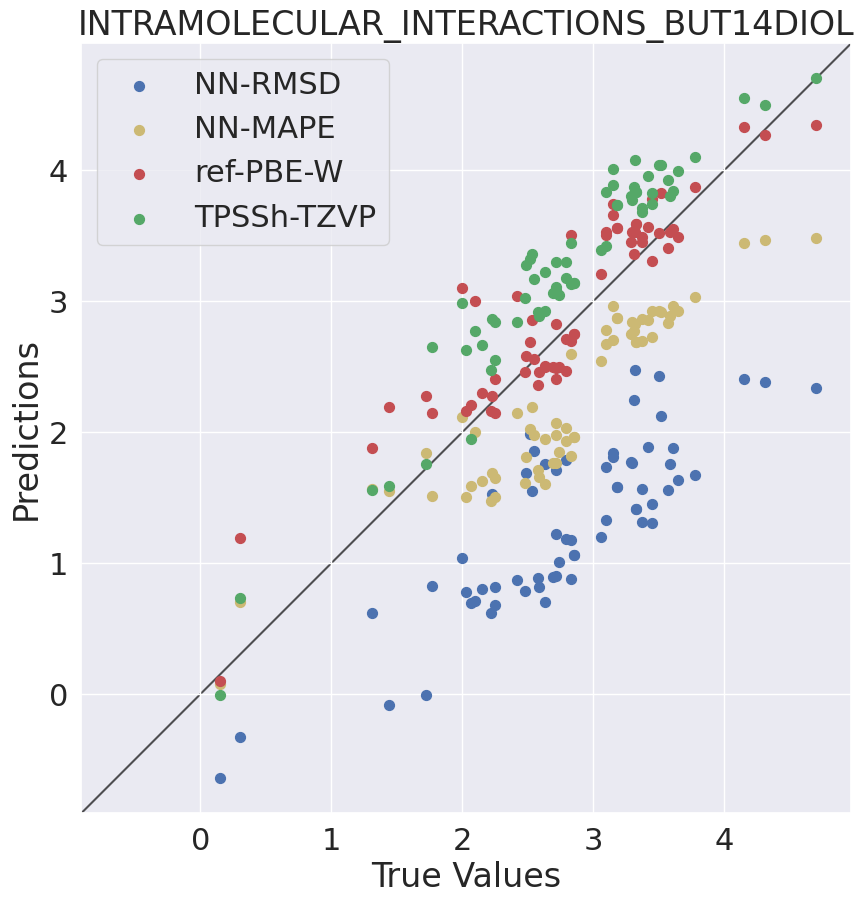

RMSE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   1.42
MAPE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   1.01
R2    INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.80
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.38
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.29
R2   MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.99


<Figure size 1000x1000 with 0 Axes>

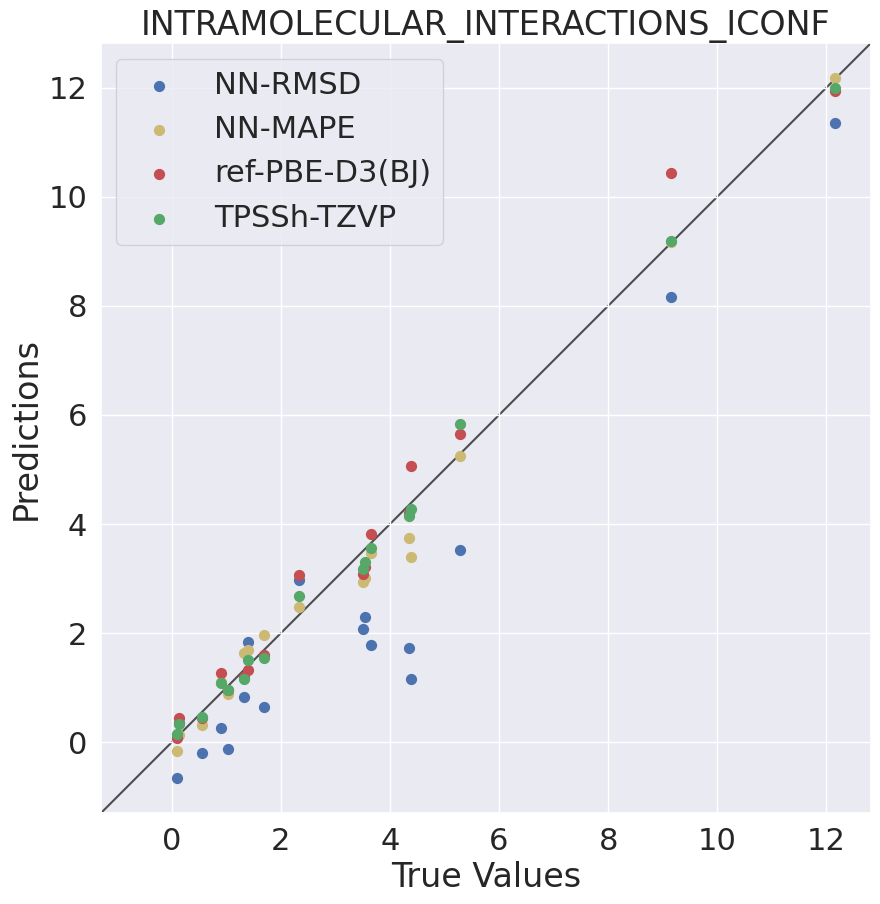

RMSE  INTRAMOLECULAR_INTERACTIONS_IDISP  :   8.40
MAPE  INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.68
R2    INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.86
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :  13.94
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :   3.46
R2   MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.62


<Figure size 1000x1000 with 0 Axes>

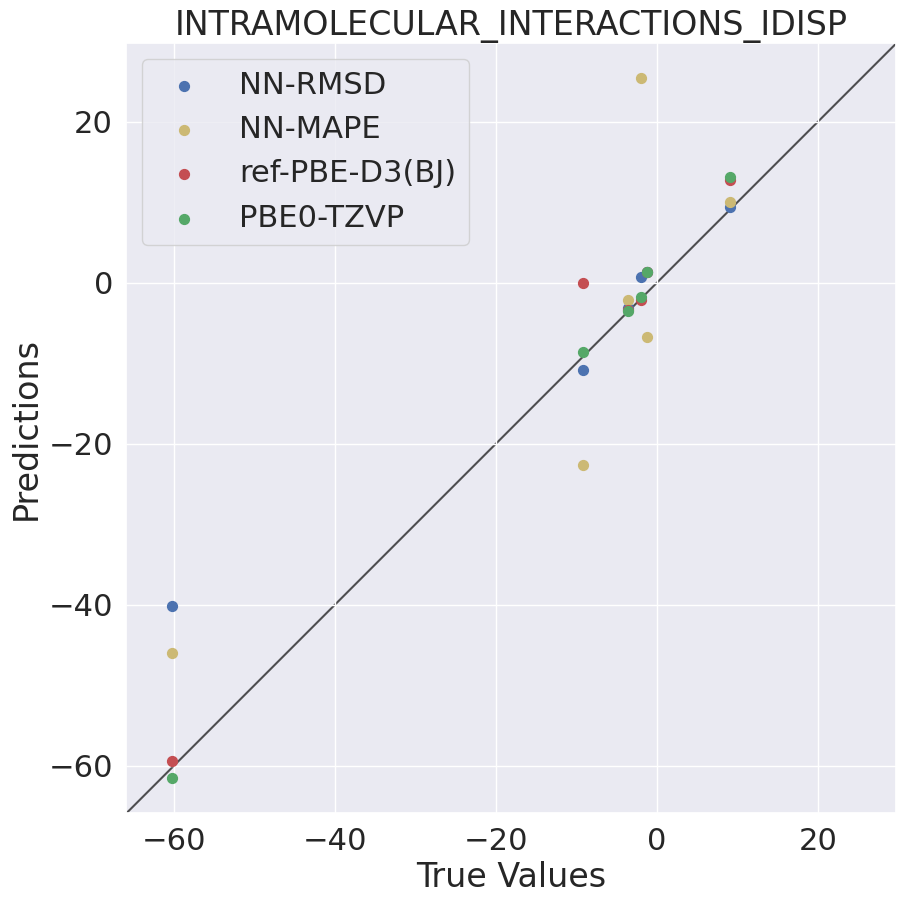

RMSE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   1.28
MAPE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.34
R2    INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.59
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.49
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.11
R2   MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.94


<Figure size 1000x1000 with 0 Axes>

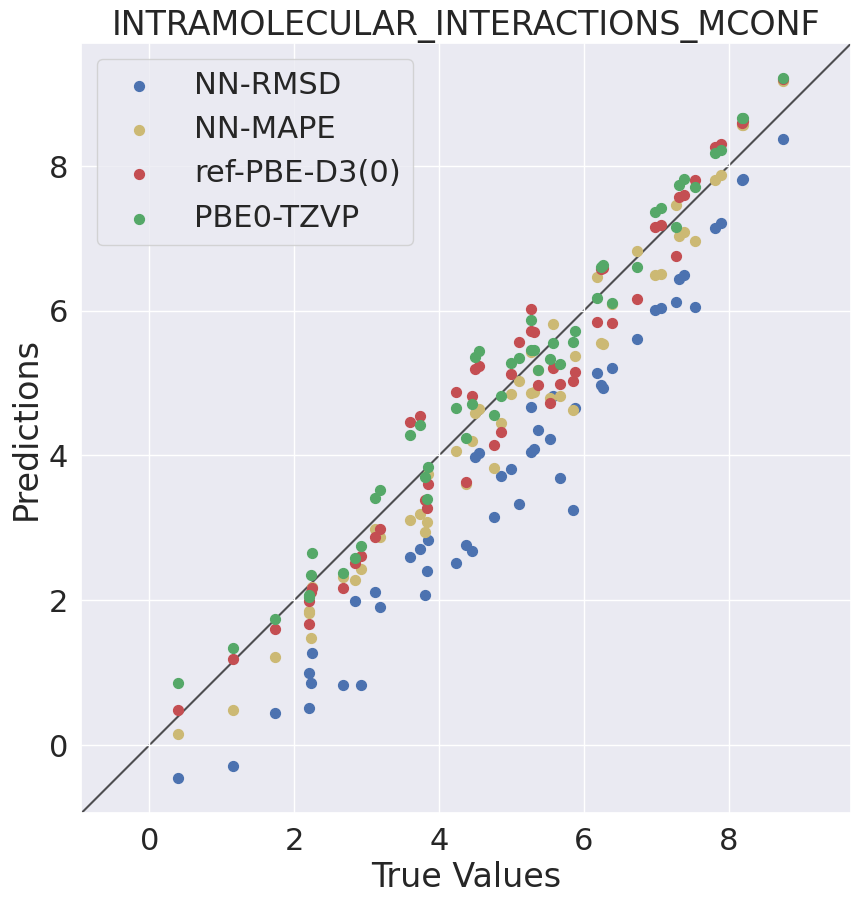

RMSE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   1.61
MAPE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   7.12
R2    INTRAMOLECULAR_INTERACTIONS_PCONF21  :  -3.54
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :   1.76
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :   4.11
R2   MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :  -4.47


<Figure size 1000x1000 with 0 Axes>

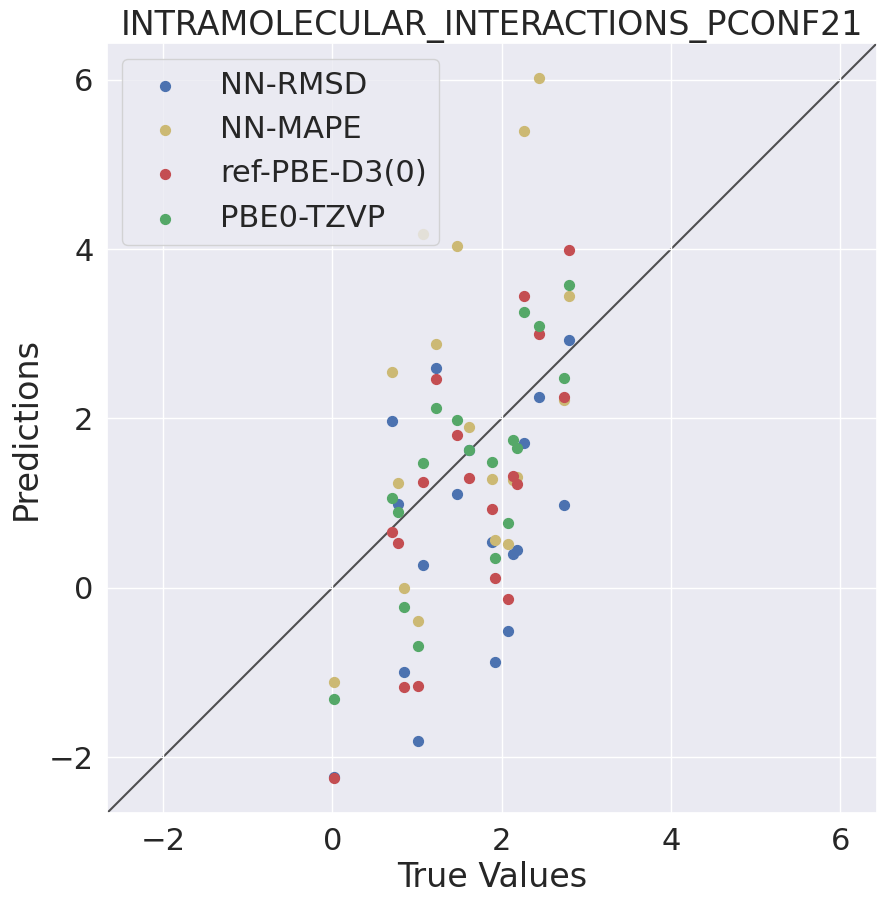

RMSE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   1.44
MAPE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.60
R2    INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.41
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.94
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.22
R2   MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.75


<Figure size 1000x1000 with 0 Axes>

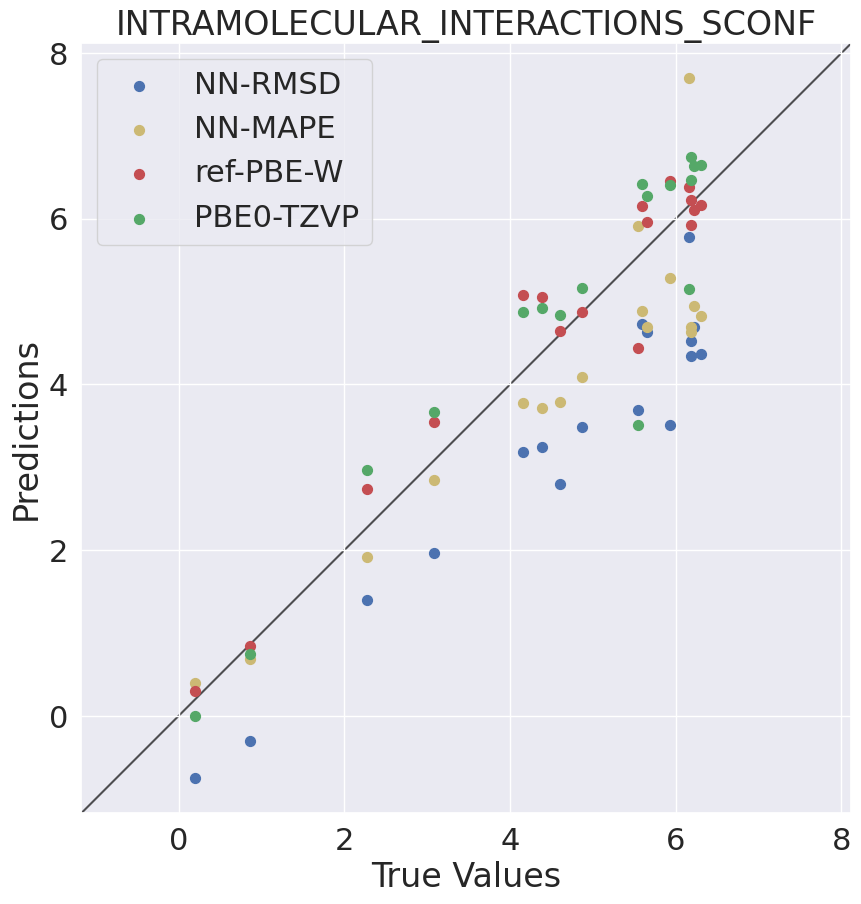

RMSE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   1.60
MAPE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   0.49
R2    INTRAMOLECULAR_INTERACTIONS_UPU23  :   0.74
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :   3.12
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :   1.08
R2   MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :  -0.01


<Figure size 1000x1000 with 0 Axes>

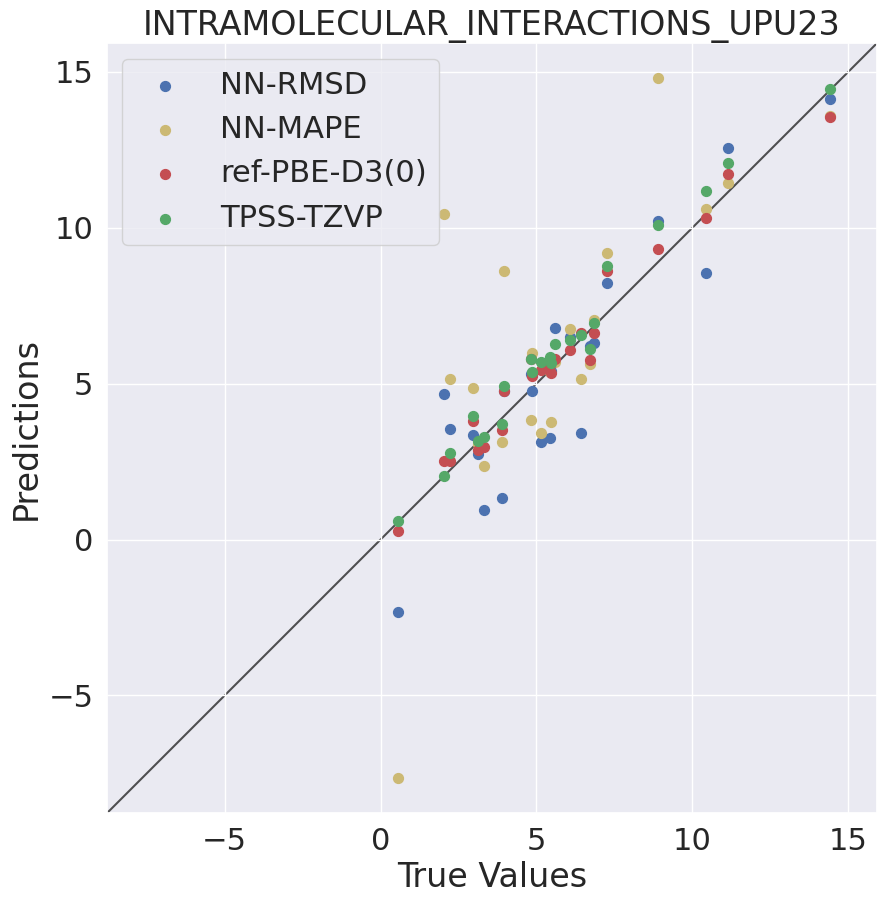

RMSE  SMALL_MOLECULES  :  10.53
MAPE  SMALL_MOLECULES  :   0.45
R2    SMALL_MOLECULES  :   1.00
RMSE MAPE SMALL_MOLECULES  :   7.40
MAPE MAPE SMALL_MOLECULES  :   0.33
R2   MAPE SMALL_MOLECULES  :   1.00


<Figure size 1000x1000 with 0 Axes>

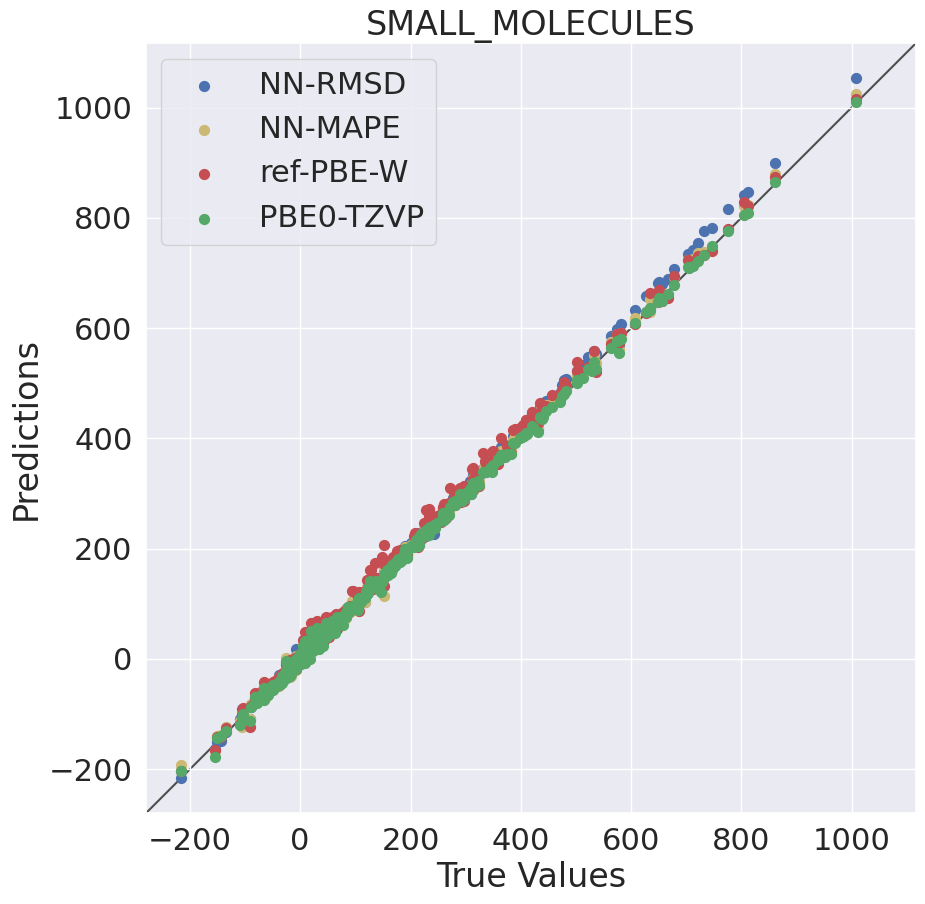

RMSE  SMALL_MOLECULES_AL2X6  :   5.29
MAPE  SMALL_MOLECULES_AL2X6  :   0.13
R2    SMALL_MOLECULES_AL2X6  :   0.63
RMSE MAPE SMALL_MOLECULES_AL2X6  :   3.73
MAPE MAPE SMALL_MOLECULES_AL2X6  :   0.10
R2   MAPE SMALL_MOLECULES_AL2X6  :   0.82


<Figure size 1000x1000 with 0 Axes>

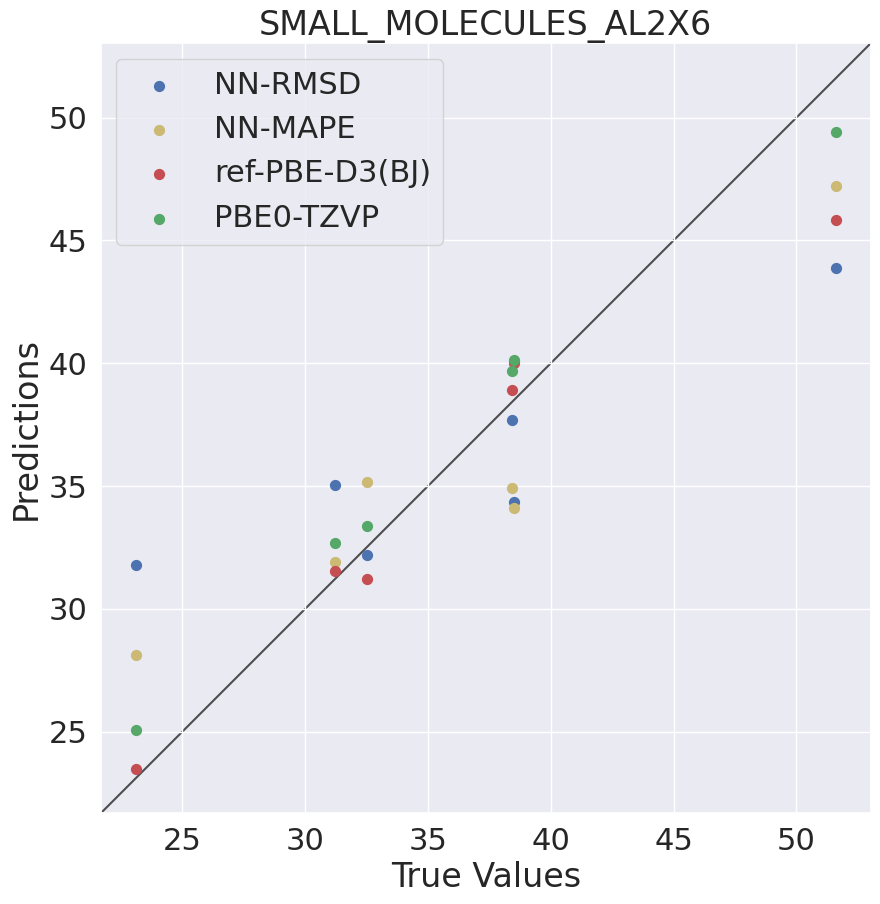

RMSE  SMALL_MOLECULES_ALK8  :   2.39
MAPE  SMALL_MOLECULES_ALK8  :   0.03
R2    SMALL_MOLECULES_ALK8  :   0.99
RMSE MAPE SMALL_MOLECULES_ALK8  :   2.42
MAPE MAPE SMALL_MOLECULES_ALK8  :   0.04
R2   MAPE SMALL_MOLECULES_ALK8  :   0.99


<Figure size 1000x1000 with 0 Axes>

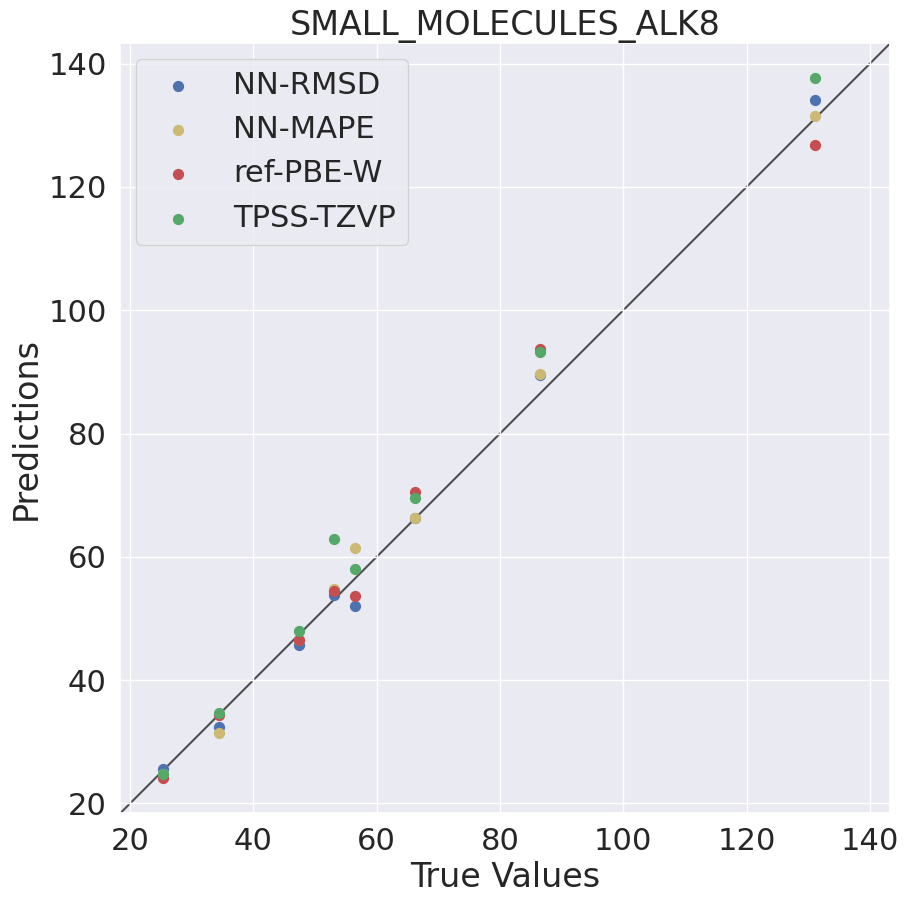

RMSE  SMALL_MOLECULES_ALKBDE10  :   3.01
MAPE  SMALL_MOLECULES_ALKBDE10  :   0.02
R2    SMALL_MOLECULES_ALKBDE10  :   0.99
RMSE MAPE SMALL_MOLECULES_ALKBDE10  :   4.12
MAPE MAPE SMALL_MOLECULES_ALKBDE10  :   0.03
R2   MAPE SMALL_MOLECULES_ALKBDE10  :   0.98


<Figure size 1000x1000 with 0 Axes>

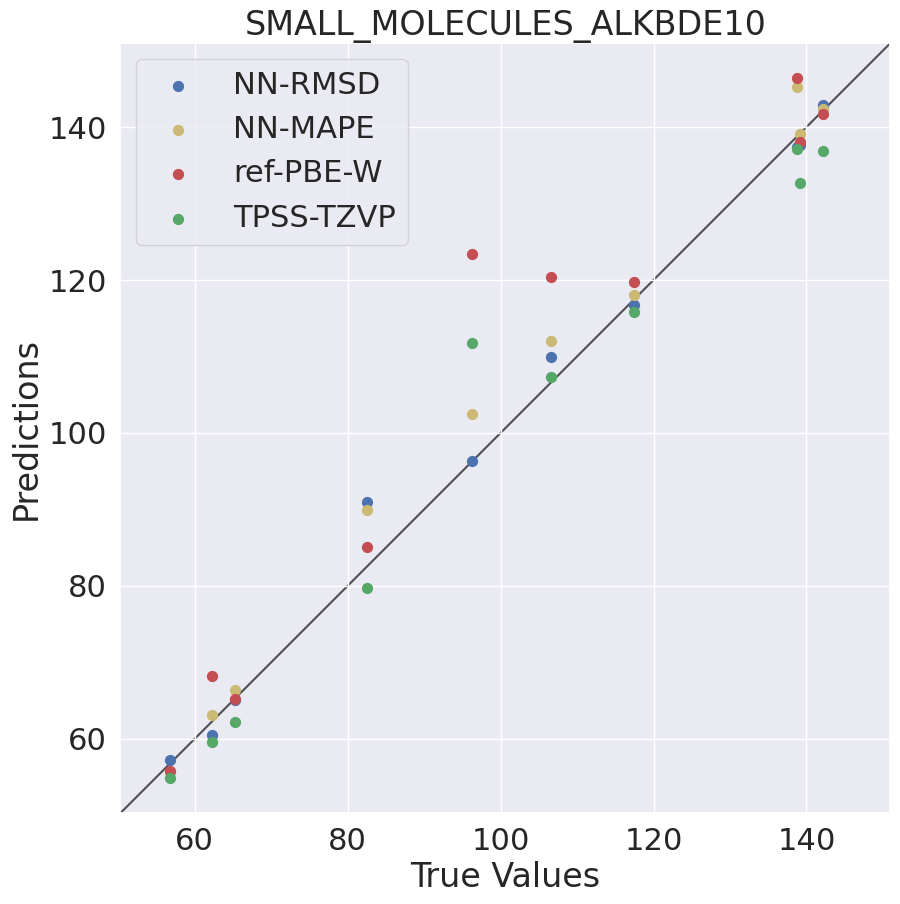

RMSE  SMALL_MOLECULES_BH76RC  :   3.08
MAPE  SMALL_MOLECULES_BH76RC  :   0.37
R2    SMALL_MOLECULES_BH76RC  :   0.98
RMSE MAPE SMALL_MOLECULES_BH76RC  :   4.75
MAPE MAPE SMALL_MOLECULES_BH76RC  :   0.32
R2   MAPE SMALL_MOLECULES_BH76RC  :   0.95


<Figure size 1000x1000 with 0 Axes>

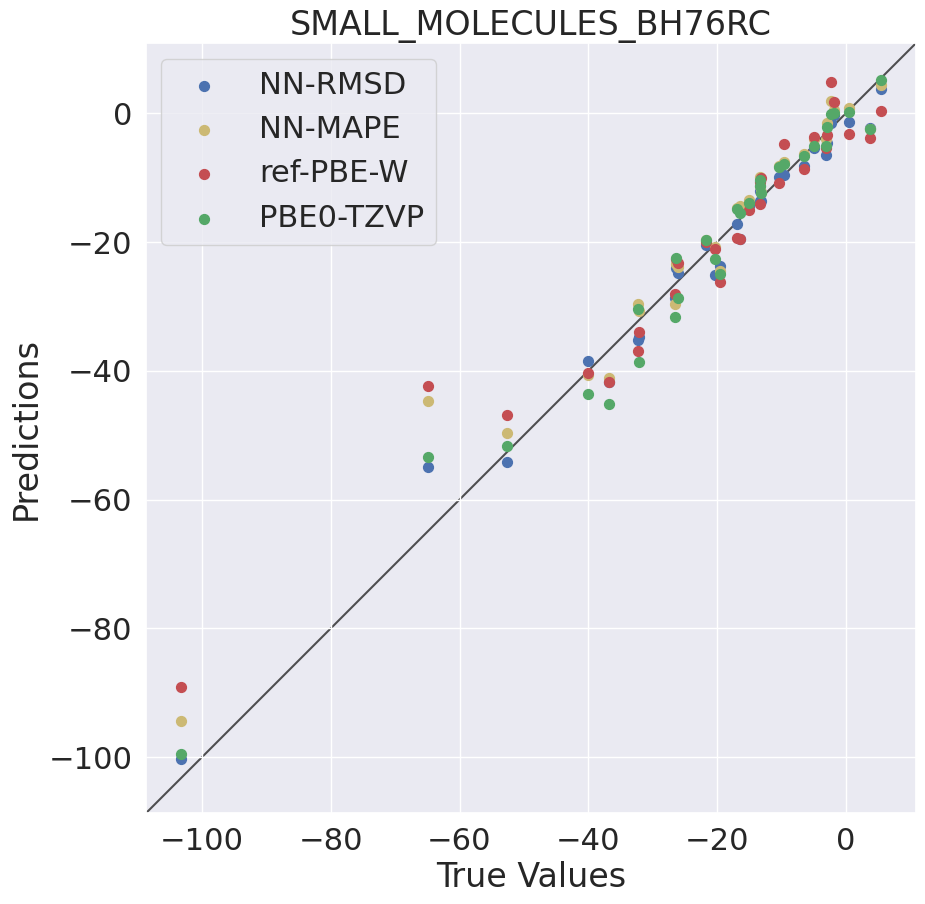

RMSE  SMALL_MOLECULES_DC13  :  11.67
MAPE  SMALL_MOLECULES_DC13  :   0.58
R2    SMALL_MOLECULES_DC13  :   0.97
RMSE MAPE SMALL_MOLECULES_DC13  :  16.24
MAPE MAPE SMALL_MOLECULES_DC13  :   0.55
R2   MAPE SMALL_MOLECULES_DC13  :   0.95


<Figure size 1000x1000 with 0 Axes>

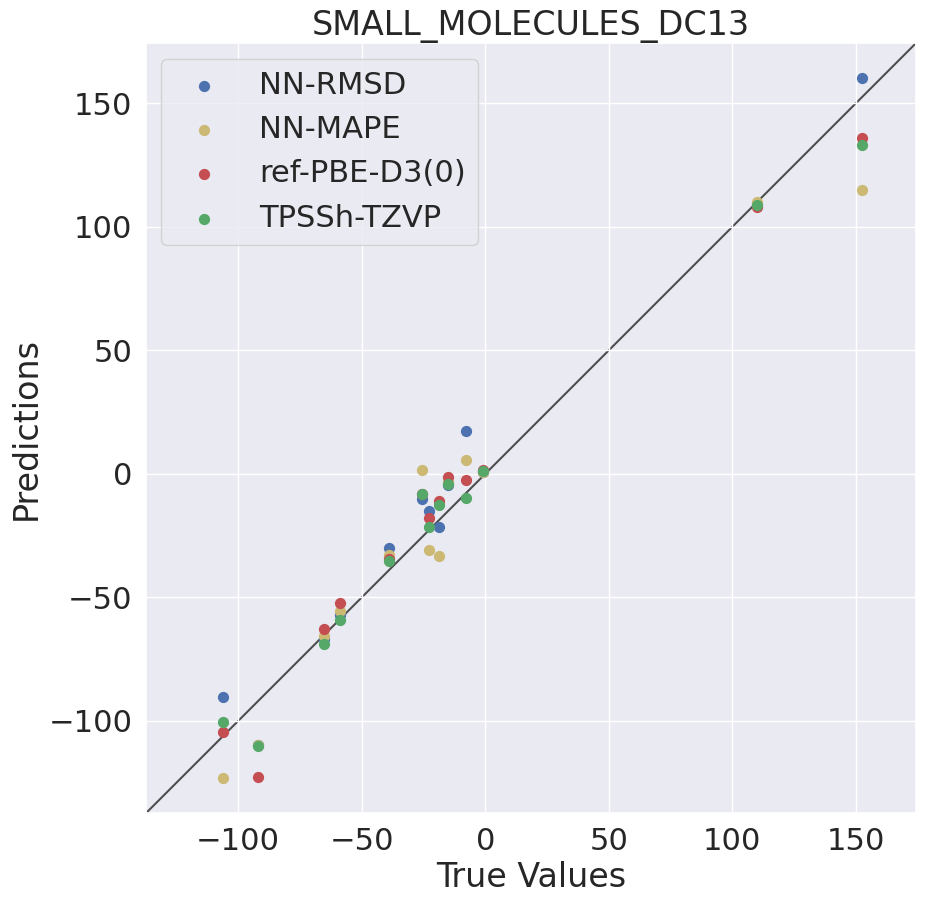

RMSE  SMALL_MOLECULES_DIPCS10  :  30.65
MAPE  SMALL_MOLECULES_DIPCS10  :   0.05
R2    SMALL_MOLECULES_DIPCS10  :   0.85
RMSE MAPE SMALL_MOLECULES_DIPCS10  :   5.11
MAPE MAPE SMALL_MOLECULES_DIPCS10  :   0.01
R2   MAPE SMALL_MOLECULES_DIPCS10  :   1.00


<Figure size 1000x1000 with 0 Axes>

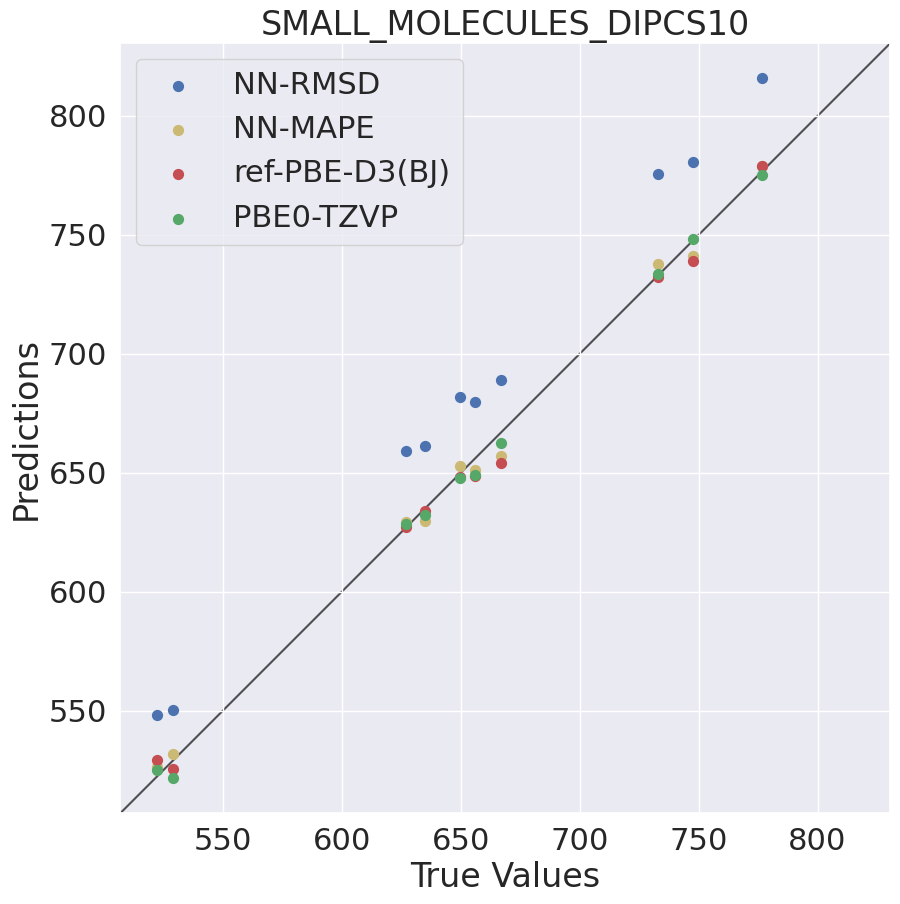

RMSE  SMALL_MOLECULES_FH51  :   4.33
MAPE  SMALL_MOLECULES_FH51  :   1.17
R2    SMALL_MOLECULES_FH51  :   0.98
RMSE MAPE SMALL_MOLECULES_FH51  :   5.05
MAPE MAPE SMALL_MOLECULES_FH51  :   0.44
R2   MAPE SMALL_MOLECULES_FH51  :   0.98


<Figure size 1000x1000 with 0 Axes>

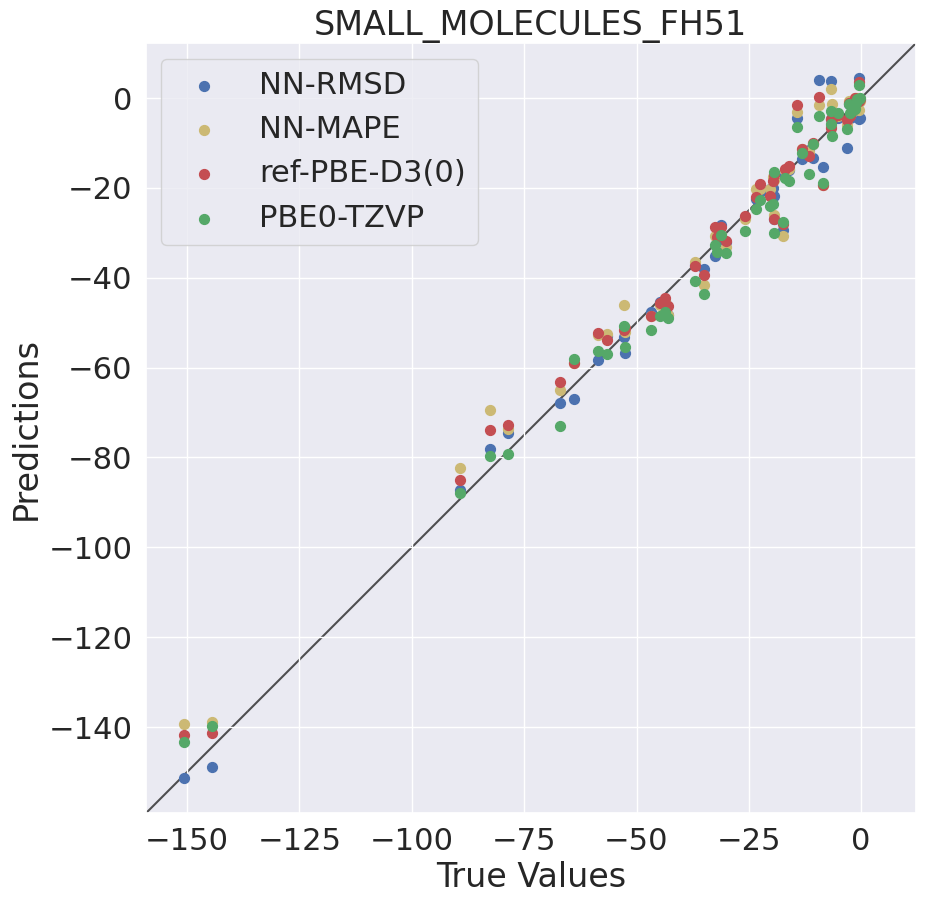

RMSE  SMALL_MOLECULES_G21EA  :   2.64
MAPE  SMALL_MOLECULES_G21EA  :   1.41
R2    SMALL_MOLECULES_G21EA  :   0.99
RMSE MAPE SMALL_MOLECULES_G21EA  :   4.89
MAPE MAPE SMALL_MOLECULES_G21EA  :   1.86
R2   MAPE SMALL_MOLECULES_G21EA  :   0.96


<Figure size 1000x1000 with 0 Axes>

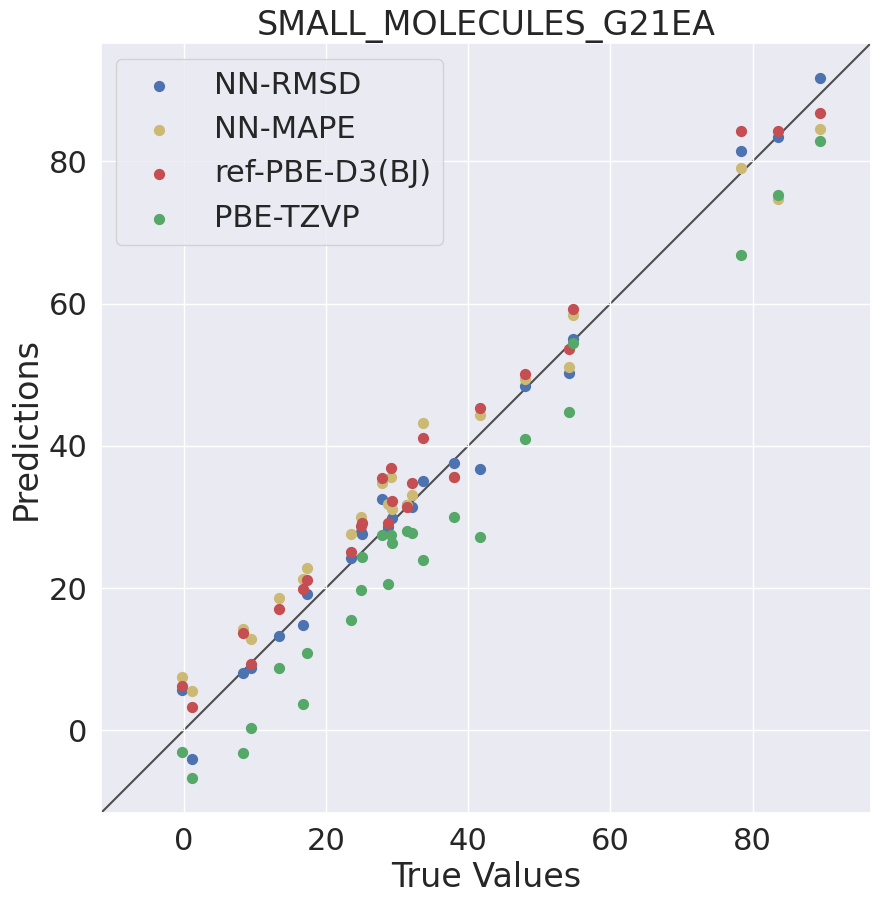

RMSE  SMALL_MOLECULES_G21IP  :  11.68
MAPE  SMALL_MOLECULES_G21IP  :   0.04
R2    SMALL_MOLECULES_G21IP  :   0.97
RMSE MAPE SMALL_MOLECULES_G21IP  :   6.41
MAPE MAPE SMALL_MOLECULES_G21IP  :   0.02
R2   MAPE SMALL_MOLECULES_G21IP  :   0.99


<Figure size 1000x1000 with 0 Axes>

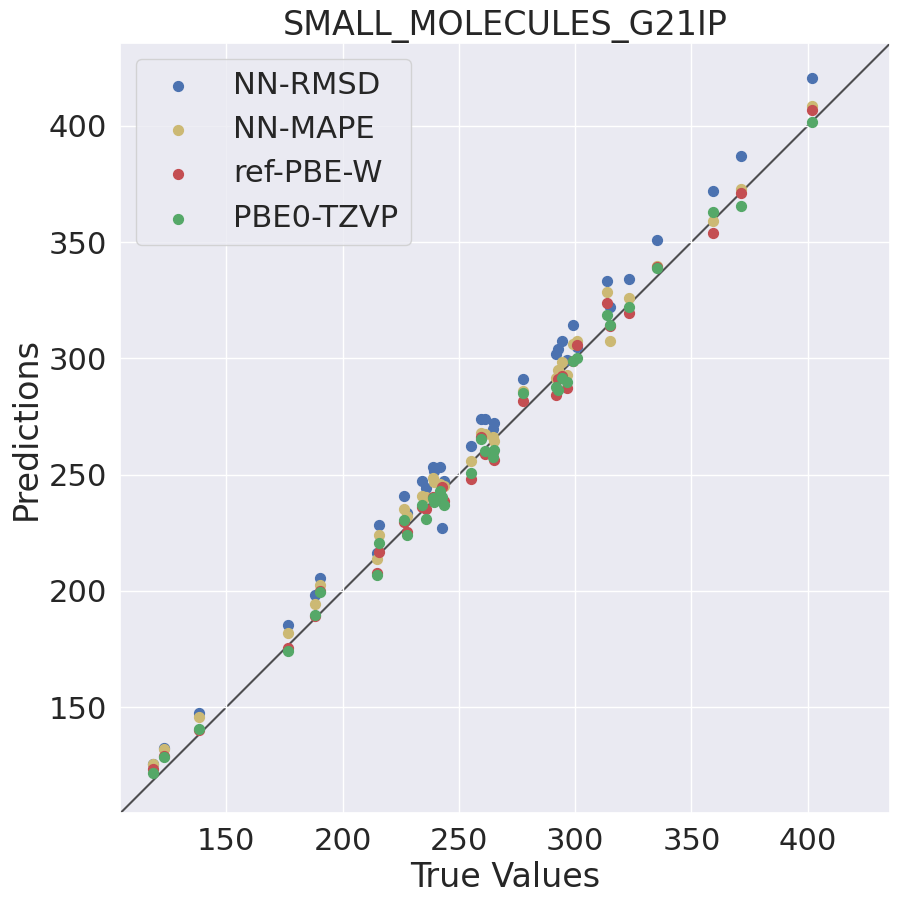

RMSE  SMALL_MOLECULES_G2RC  :   5.50
MAPE  SMALL_MOLECULES_G2RC  :   0.23
R2    SMALL_MOLECULES_G2RC  :   0.99
RMSE MAPE SMALL_MOLECULES_G2RC  :   8.48
MAPE MAPE SMALL_MOLECULES_G2RC  :   0.42
R2   MAPE SMALL_MOLECULES_G2RC  :   0.97


<Figure size 1000x1000 with 0 Axes>

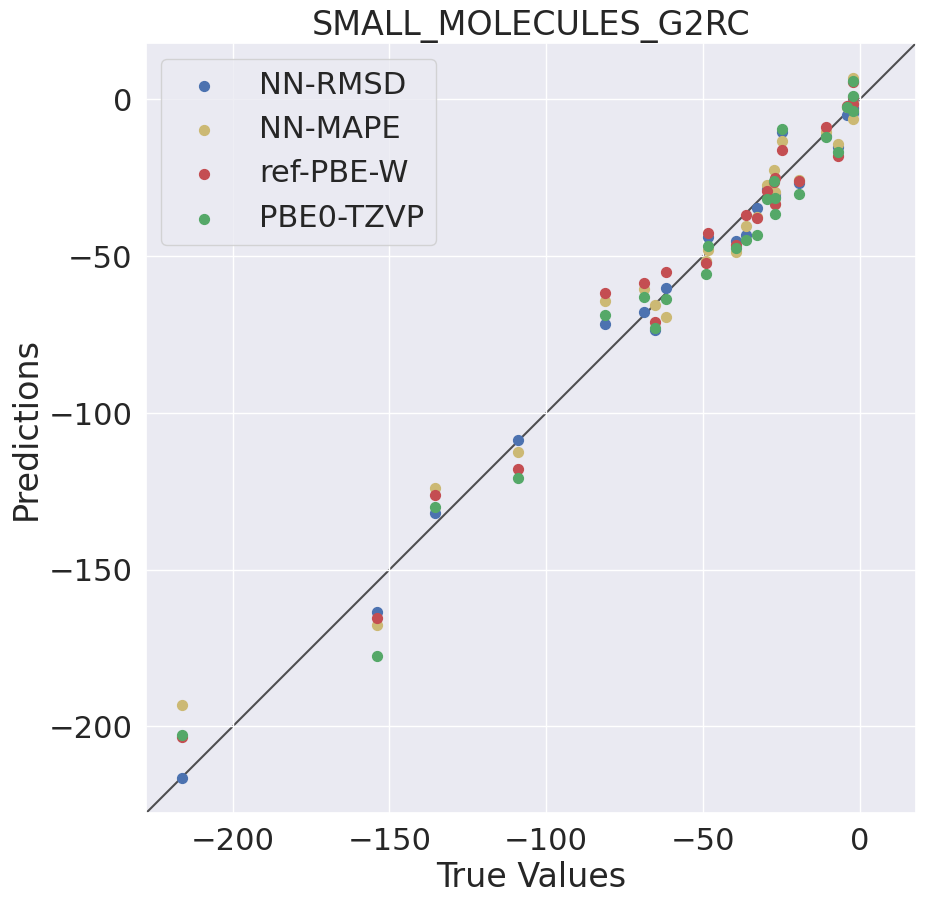

RMSE  SMALL_MOLECULES_HEAVYSB11  :   3.23
MAPE  SMALL_MOLECULES_HEAVYSB11  :   0.05
R2    SMALL_MOLECULES_HEAVYSB11  :   0.83
RMSE MAPE SMALL_MOLECULES_HEAVYSB11  :   5.01
MAPE MAPE SMALL_MOLECULES_HEAVYSB11  :   0.07
R2   MAPE SMALL_MOLECULES_HEAVYSB11  :   0.60


<Figure size 1000x1000 with 0 Axes>

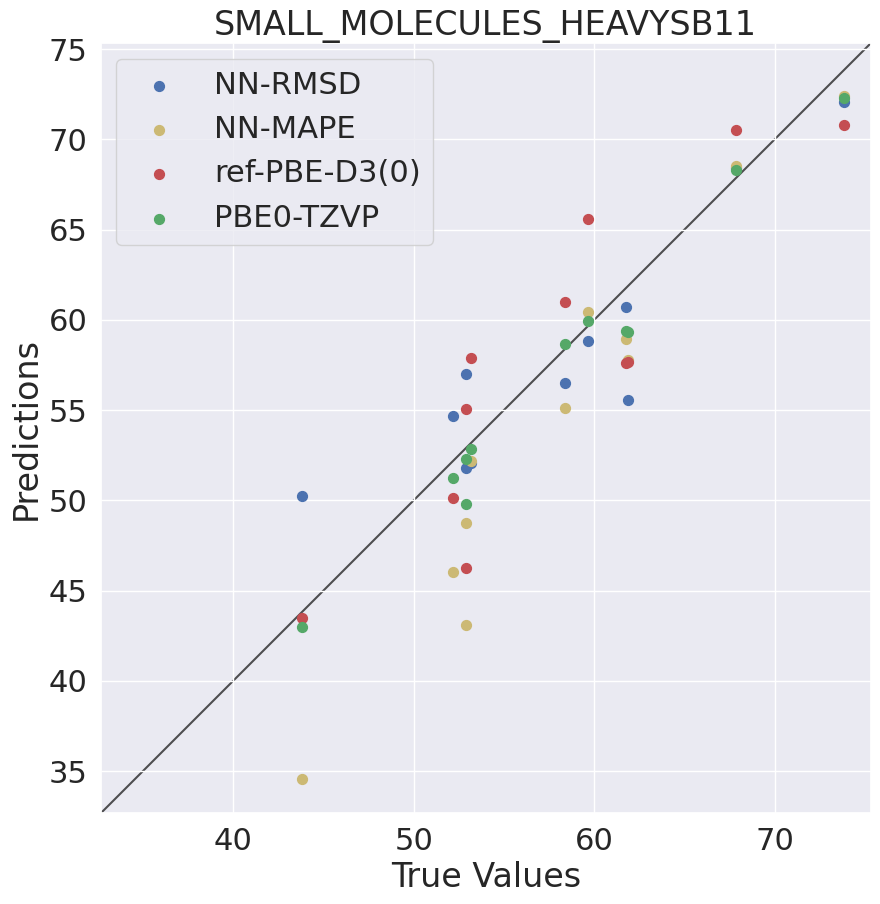

RMSE  SMALL_MOLECULES_NBPRC  :   3.93
MAPE  SMALL_MOLECULES_NBPRC  :   1.75
R2    SMALL_MOLECULES_NBPRC  :   0.98
RMSE MAPE SMALL_MOLECULES_NBPRC  :   3.37
MAPE MAPE SMALL_MOLECULES_NBPRC  :   0.61
R2   MAPE SMALL_MOLECULES_NBPRC  :   0.99


<Figure size 1000x1000 with 0 Axes>

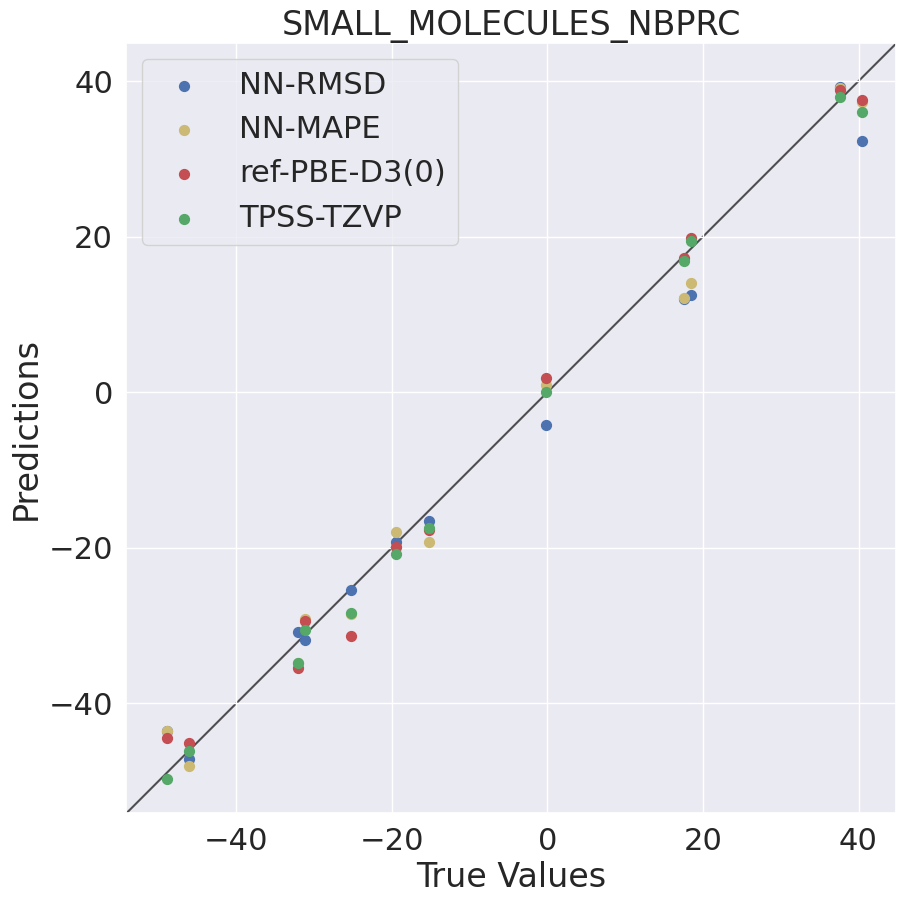

RMSE  SMALL_MOLECULES_PA26  :   5.58
MAPE  SMALL_MOLECULES_PA26  :   0.03
R2    SMALL_MOLECULES_PA26  :   0.97
RMSE MAPE SMALL_MOLECULES_PA26  :   2.96
MAPE MAPE SMALL_MOLECULES_PA26  :   0.01
R2   MAPE SMALL_MOLECULES_PA26  :   0.99


<Figure size 1000x1000 with 0 Axes>

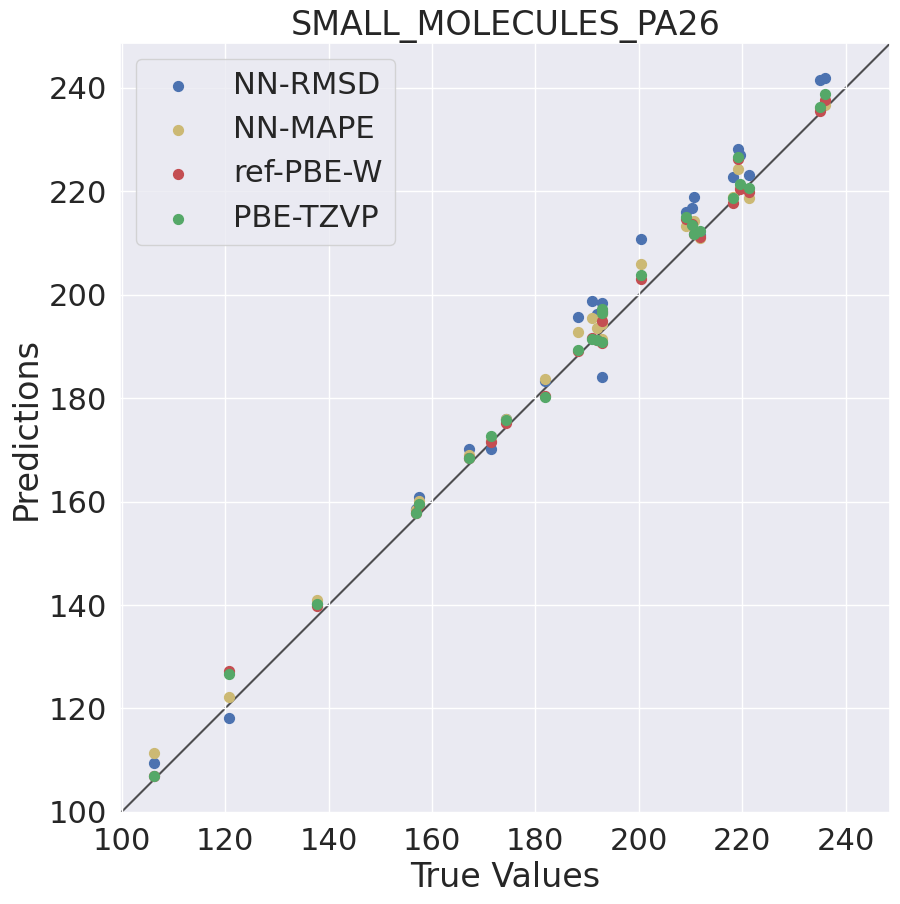

RMSE  SMALL_MOLECULES_RC21  :   6.30
MAPE  SMALL_MOLECULES_RC21  :   0.56
R2    SMALL_MOLECULES_RC21  :   0.94
RMSE MAPE SMALL_MOLECULES_RC21  :   6.28
MAPE MAPE SMALL_MOLECULES_RC21  :   0.70
R2   MAPE SMALL_MOLECULES_RC21  :   0.94


<Figure size 1000x1000 with 0 Axes>

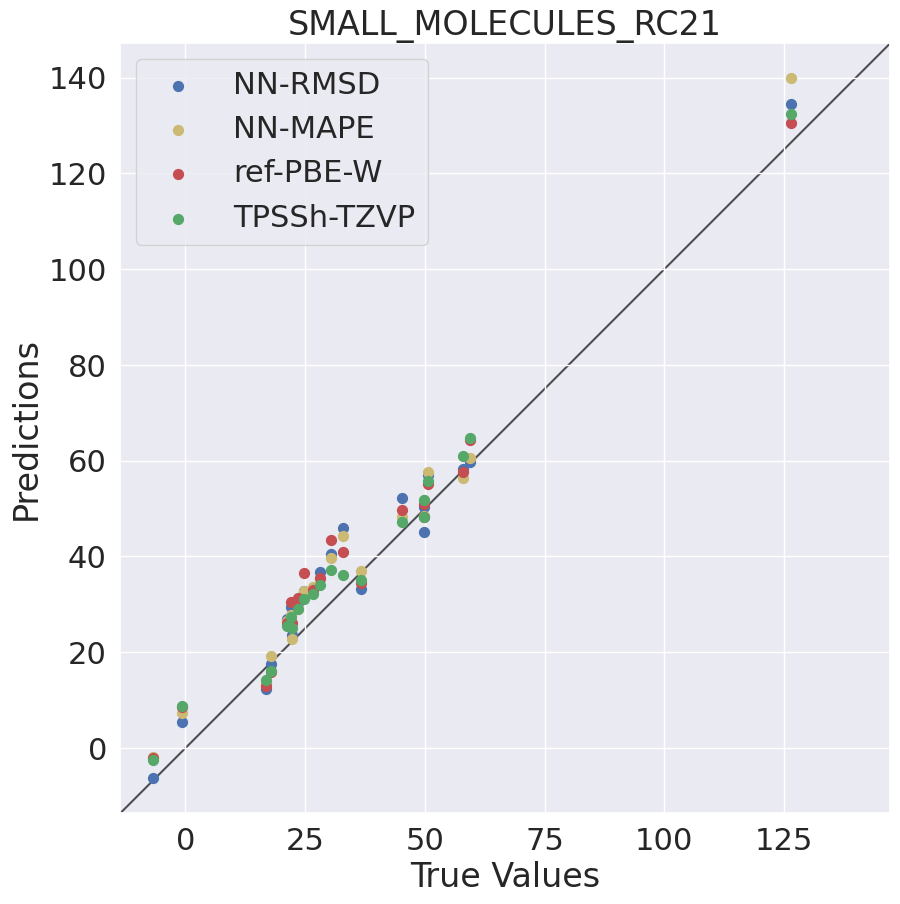

RMSE  SMALL_MOLECULES_SIE4x4  :  11.21
MAPE  SMALL_MOLECULES_SIE4x4  :   0.64
R2    SMALL_MOLECULES_SIE4x4  :   0.60
RMSE MAPE SMALL_MOLECULES_SIE4x4  :  13.98
MAPE MAPE SMALL_MOLECULES_SIE4x4  :   0.80
R2   MAPE SMALL_MOLECULES_SIE4x4  :   0.37


<Figure size 1000x1000 with 0 Axes>

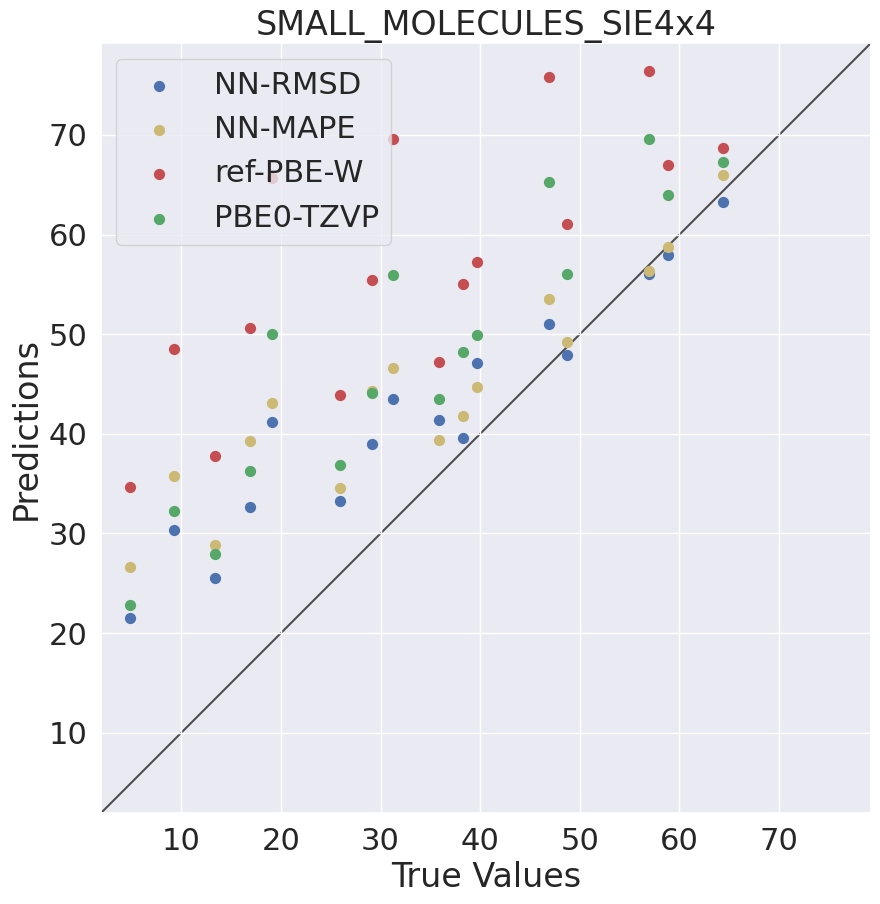

RMSE  SMALL_MOLECULES_TAUT15  :   2.64
MAPE  SMALL_MOLECULES_TAUT15  :   2.69
R2    SMALL_MOLECULES_TAUT15  :   0.56
RMSE MAPE SMALL_MOLECULES_TAUT15  :   1.95
MAPE MAPE SMALL_MOLECULES_TAUT15  :   1.08
R2   MAPE SMALL_MOLECULES_TAUT15  :   0.76


<Figure size 1000x1000 with 0 Axes>

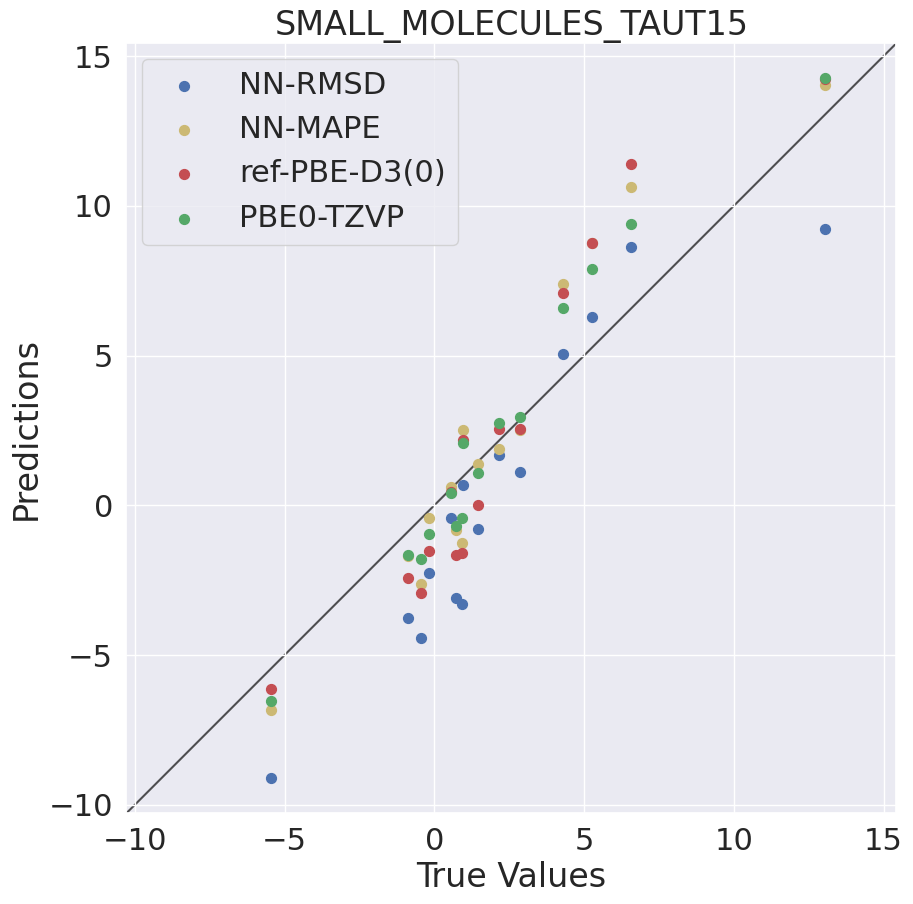

RMSE  SMALL_MOLECULES_W4-11  :  14.58
MAPE  SMALL_MOLECULES_W4-11  :   0.05
R2    SMALL_MOLECULES_W4-11  :   0.99
RMSE MAPE SMALL_MOLECULES_W4-11  :   8.99
MAPE MAPE SMALL_MOLECULES_W4-11  :   0.04
R2   MAPE SMALL_MOLECULES_W4-11  :   1.00


<Figure size 1000x1000 with 0 Axes>

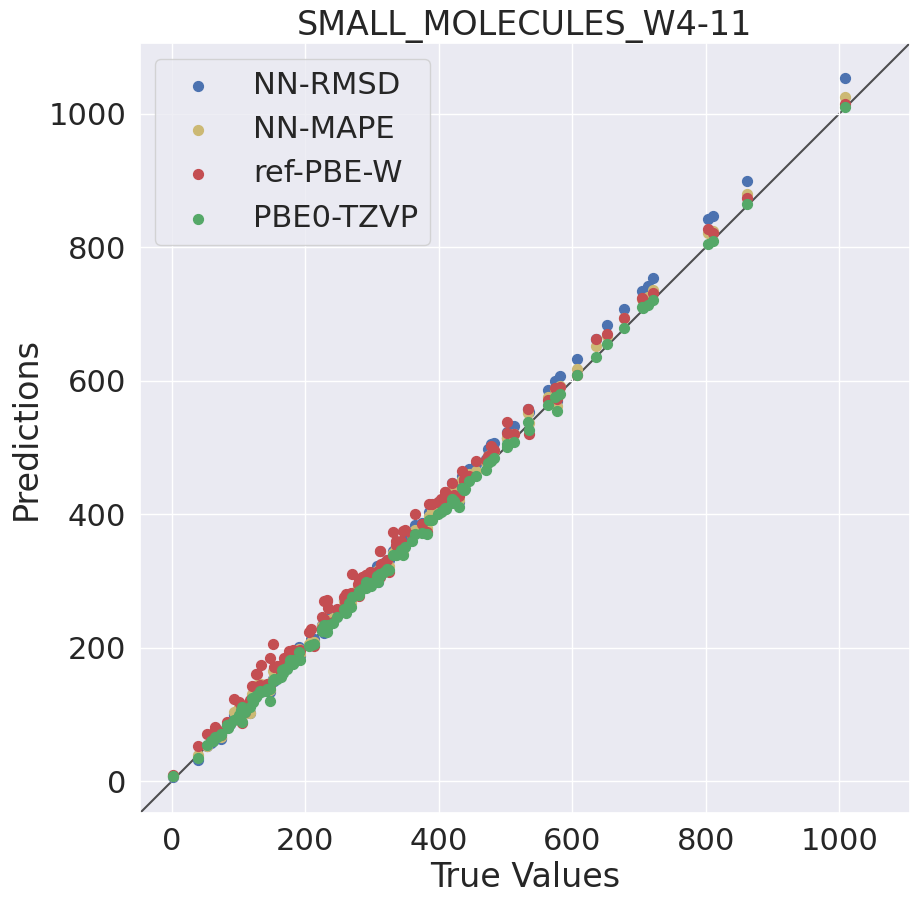

RMSE  SMALL_MOLECULES_YBDE18  :   2.24
MAPE  SMALL_MOLECULES_YBDE18  :   0.05
R2    SMALL_MOLECULES_YBDE18  :   0.99
RMSE MAPE SMALL_MOLECULES_YBDE18  :   2.46
MAPE MAPE SMALL_MOLECULES_YBDE18  :   0.06
R2   MAPE SMALL_MOLECULES_YBDE18  :   0.98


<Figure size 1000x1000 with 0 Axes>

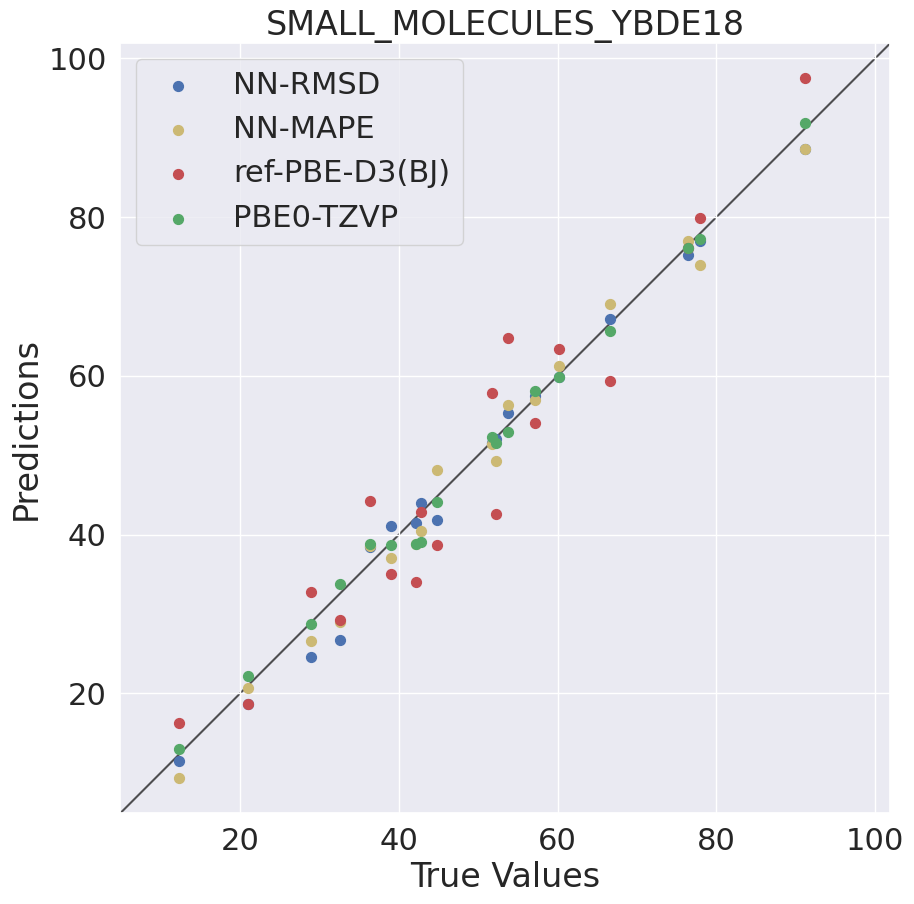

RMSE  INTERMOLECULAR_INTERACTIONS  :   2.66
MAPE  INTERMOLECULAR_INTERACTIONS  :   0.58
R2    INTERMOLECULAR_INTERACTIONS  :   1.00
RMSE MAPE INTERMOLECULAR_INTERACTIONS  :   3.42
MAPE MAPE INTERMOLECULAR_INTERACTIONS  :   0.21
R2   MAPE INTERMOLECULAR_INTERACTIONS  :   0.99


<Figure size 1000x1000 with 0 Axes>

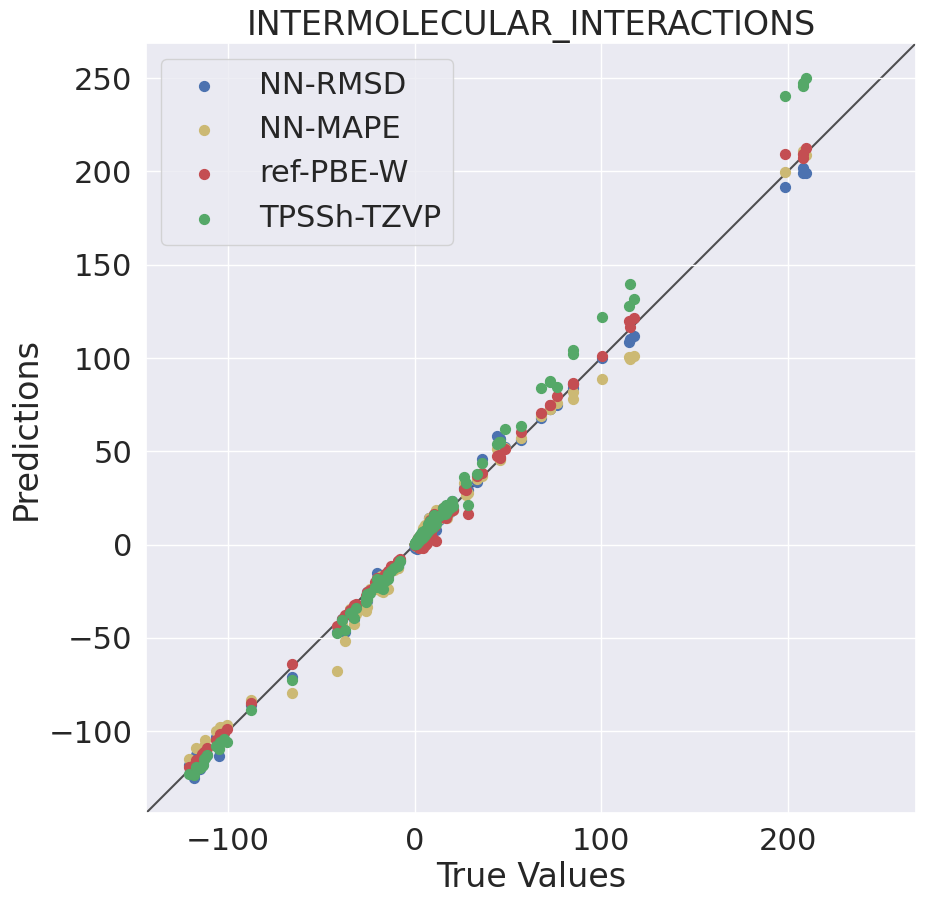

RMSE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.91
MAPE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.34
R2    INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.61
RMSE MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   2.08
MAPE MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.30
R2   MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :  -1.06


<Figure size 1000x1000 with 0 Axes>

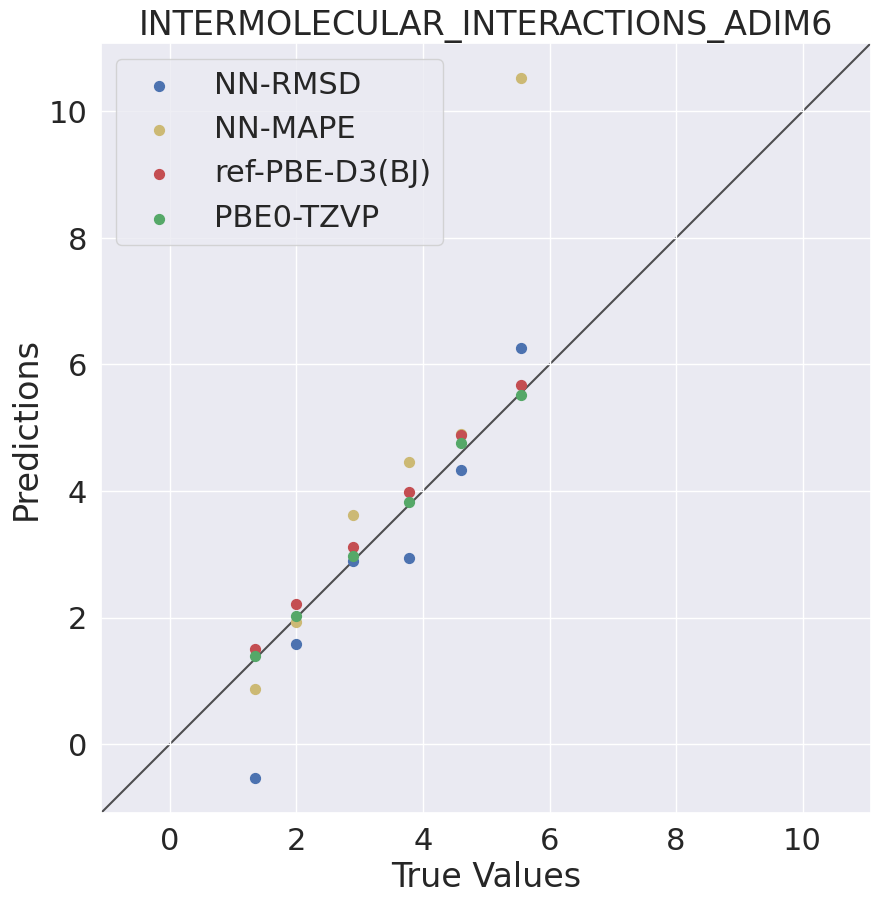

RMSE  INTERMOLECULAR_INTERACTIONS_AHB21  :   4.44
MAPE  INTERMOLECULAR_INTERACTIONS_AHB21  :   0.19
R2    INTERMOLECULAR_INTERACTIONS_AHB21  :   0.89
RMSE MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   9.02
MAPE MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   0.30
R2   MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   0.55


<Figure size 1000x1000 with 0 Axes>

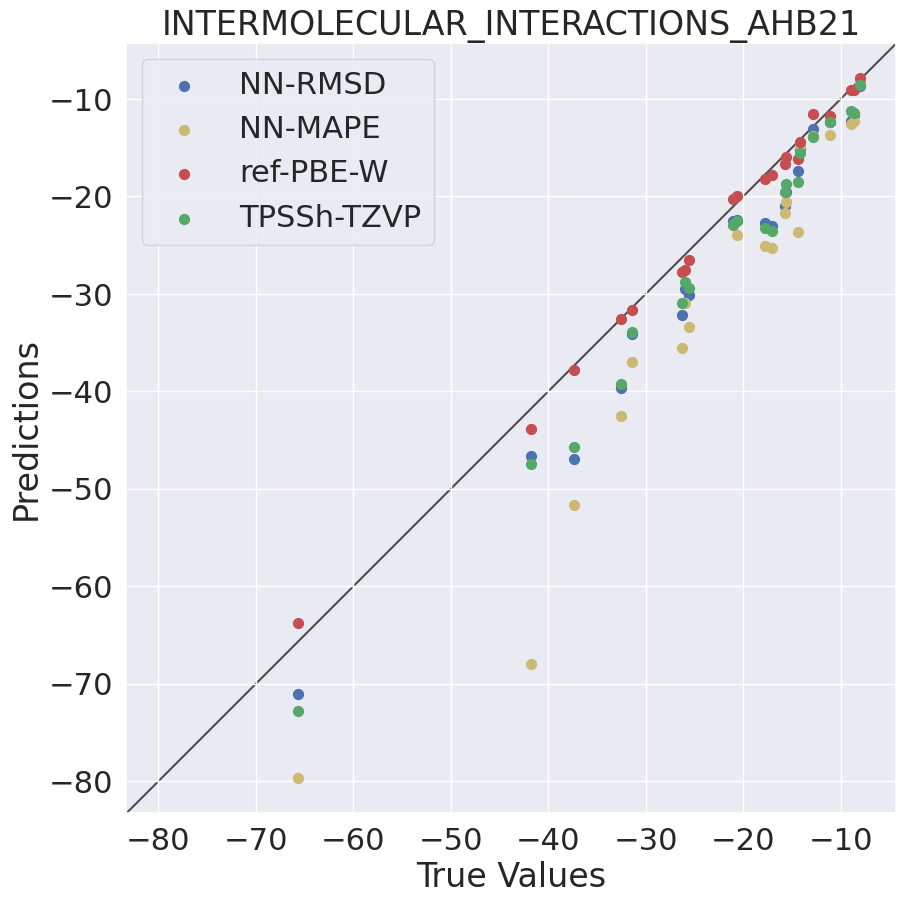

RMSE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   2.42
MAPE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.21
R2    INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.67
RMSE MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   2.76
MAPE MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.30
R2   MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.57


<Figure size 1000x1000 with 0 Axes>

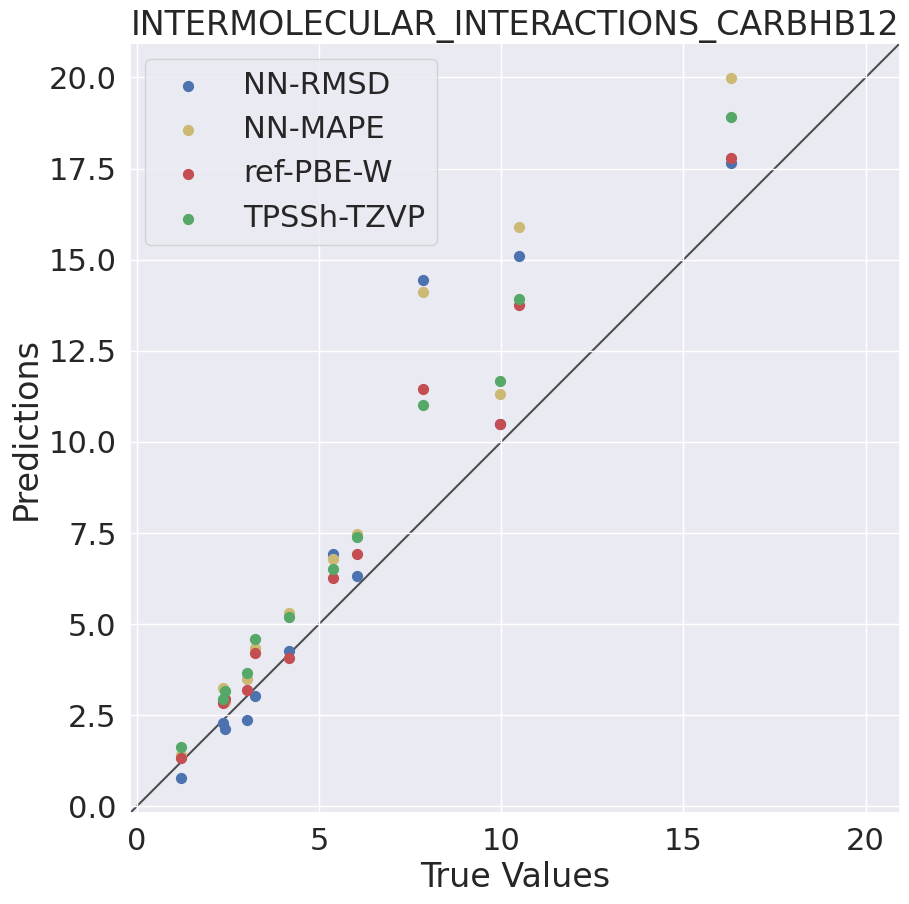

RMSE  INTERMOLECULAR_INTERACTIONS_CHB6  :   1.95
MAPE  INTERMOLECULAR_INTERACTIONS_CHB6  :   0.05
R2    INTERMOLECULAR_INTERACTIONS_CHB6  :   0.93
RMSE MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   2.28
MAPE MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   0.05
R2   MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   0.91


<Figure size 1000x1000 with 0 Axes>

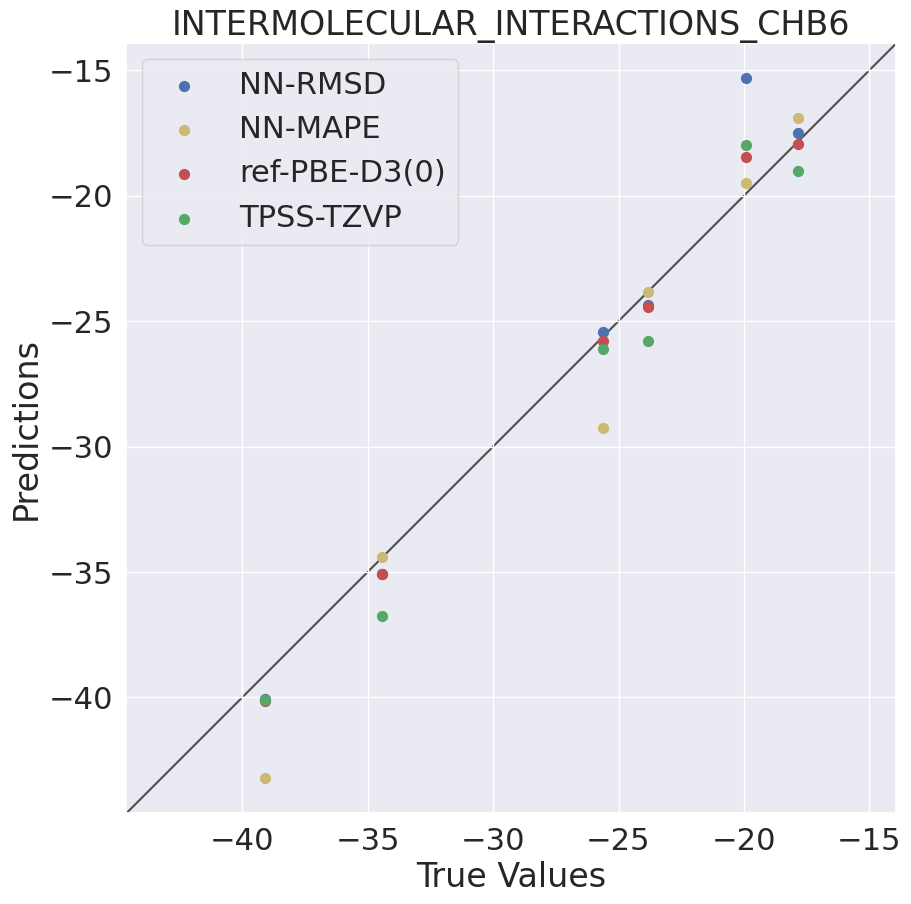

RMSE  INTERMOLECULAR_INTERACTIONS_HAL59  :   1.24
MAPE  INTERMOLECULAR_INTERACTIONS_HAL59  :   0.59
R2    INTERMOLECULAR_INTERACTIONS_HAL59  :   0.91
RMSE MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   1.11
MAPE MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   0.27
R2   MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   0.93


<Figure size 1000x1000 with 0 Axes>

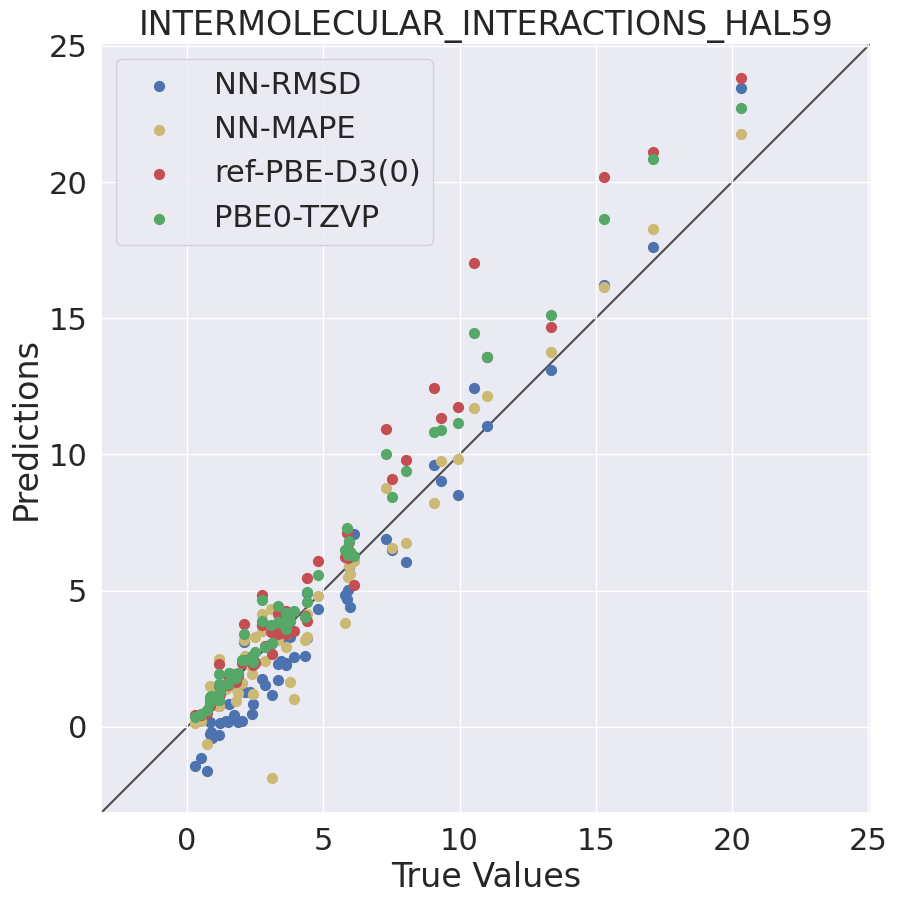

RMSE  INTERMOLECULAR_INTERACTIONS_HEAVY28  :   1.36
MAPE  INTERMOLECULAR_INTERACTIONS_HEAVY28  :   1.44
R2    INTERMOLECULAR_INTERACTIONS_HEAVY28  :  -2.69
RMSE MAPE INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.38
MAPE MAPE INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.26
R2   MAPE INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.71


<Figure size 1000x1000 with 0 Axes>

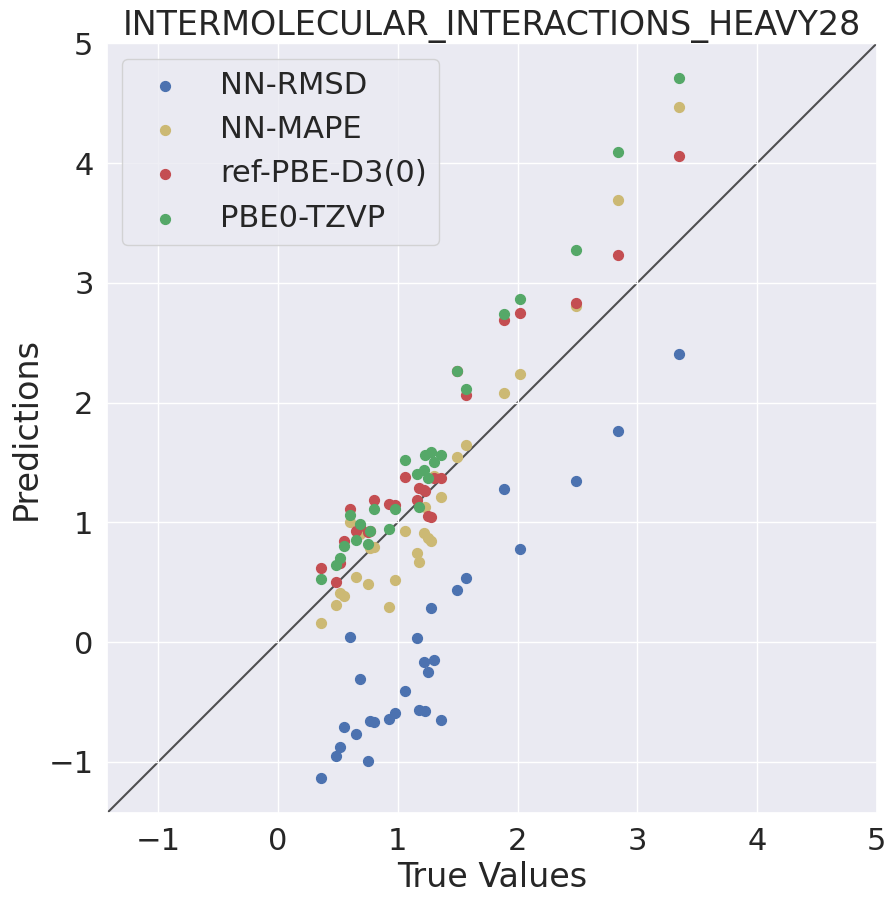

RMSE  INTERMOLECULAR_INTERACTIONS_IL16  :   4.01
MAPE  INTERMOLECULAR_INTERACTIONS_IL16  :   0.03
R2    INTERMOLECULAR_INTERACTIONS_IL16  :   0.75
RMSE MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   4.70
MAPE MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   0.04
R2   MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   0.66


<Figure size 1000x1000 with 0 Axes>

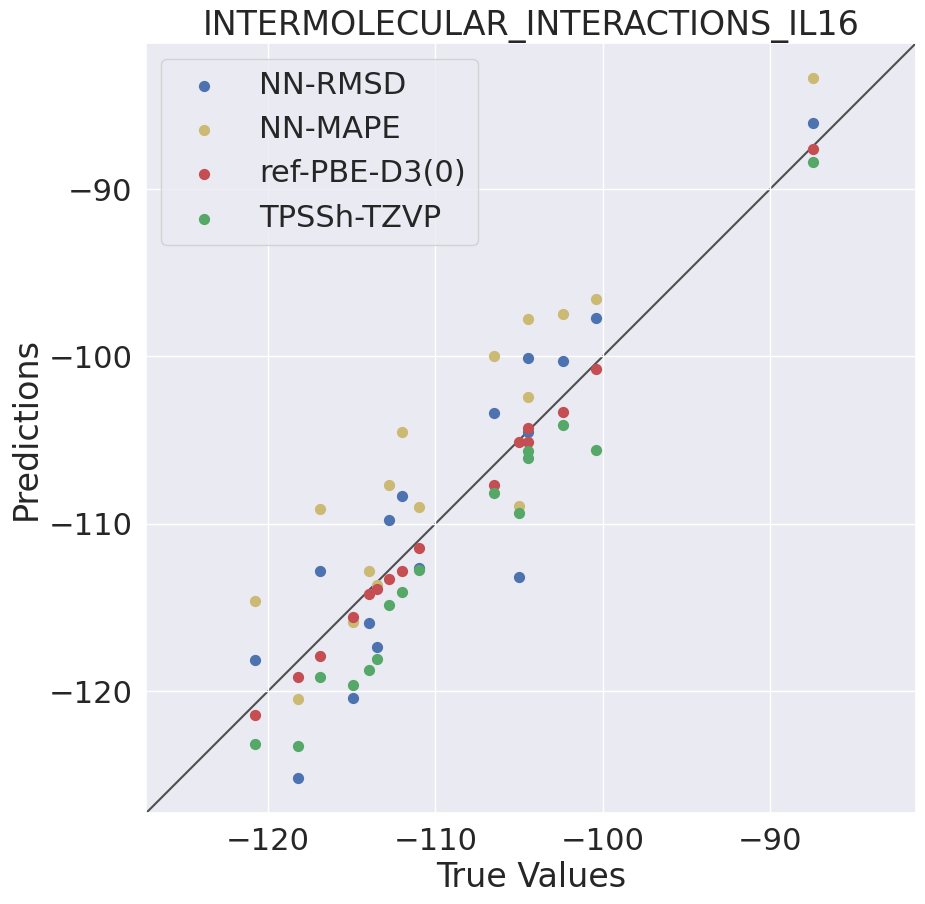

RMSE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   1.25
MAPE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.46
R2    INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.77
RMSE MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   1.00
MAPE MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.21
R2   MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.85


<Figure size 1000x1000 with 0 Axes>

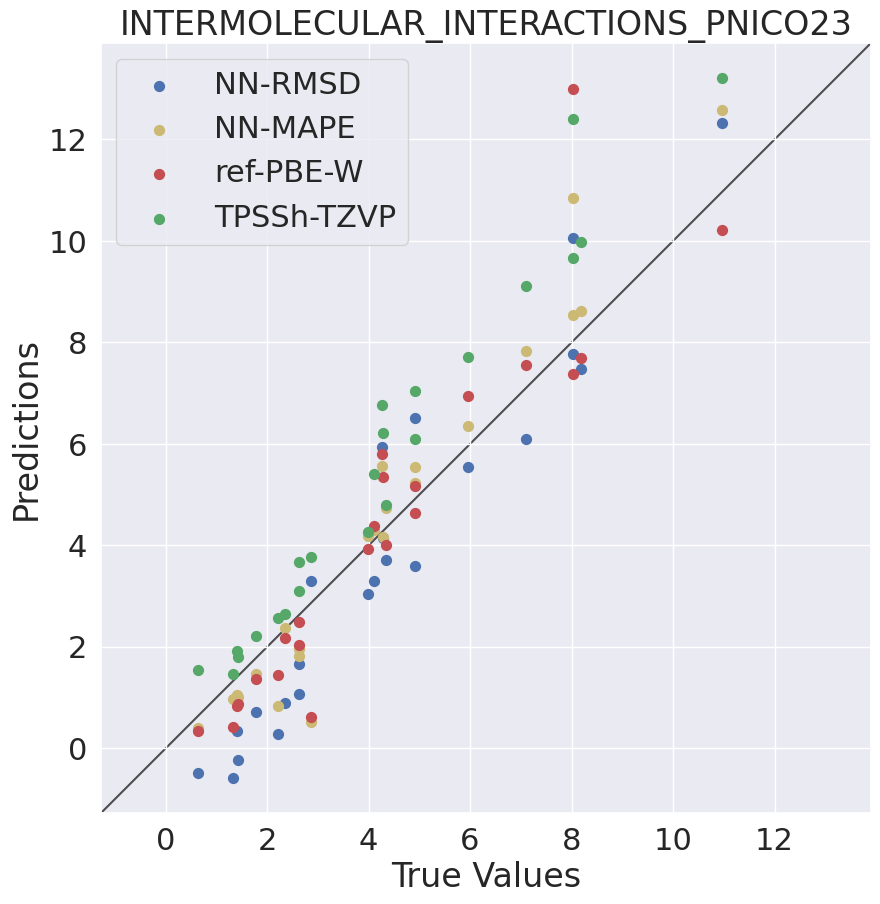

RMSE  INTERMOLECULAR_INTERACTIONS_RG18  :   1.63
MAPE  INTERMOLECULAR_INTERACTIONS_RG18  :   3.54
R2    INTERMOLECULAR_INTERACTIONS_RG18  : -15.44
RMSE MAPE INTERMOLECULAR_INTERACTIONS_RG18  :   0.54
MAPE MAPE INTERMOLECULAR_INTERACTIONS_RG18  :   0.40
R2   MAPE INTERMOLECULAR_INTERACTIONS_RG18  :  -0.82


<Figure size 1000x1000 with 0 Axes>

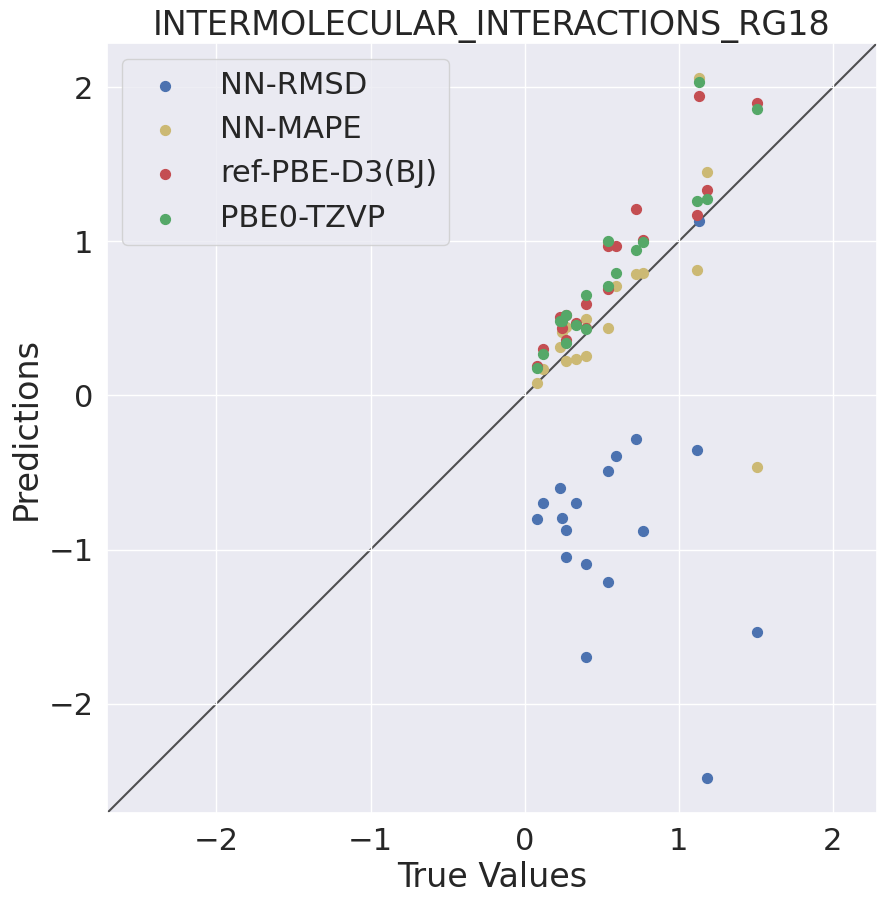

RMSE  INTERMOLECULAR_INTERACTIONS_S22  :   1.25
MAPE  INTERMOLECULAR_INTERACTIONS_S22  :   0.30
R2    INTERMOLECULAR_INTERACTIONS_S22  :   0.96
RMSE MAPE INTERMOLECULAR_INTERACTIONS_S22  :   2.19
MAPE MAPE INTERMOLECULAR_INTERACTIONS_S22  :   0.25
R2   MAPE INTERMOLECULAR_INTERACTIONS_S22  :   0.88


<Figure size 1000x1000 with 0 Axes>

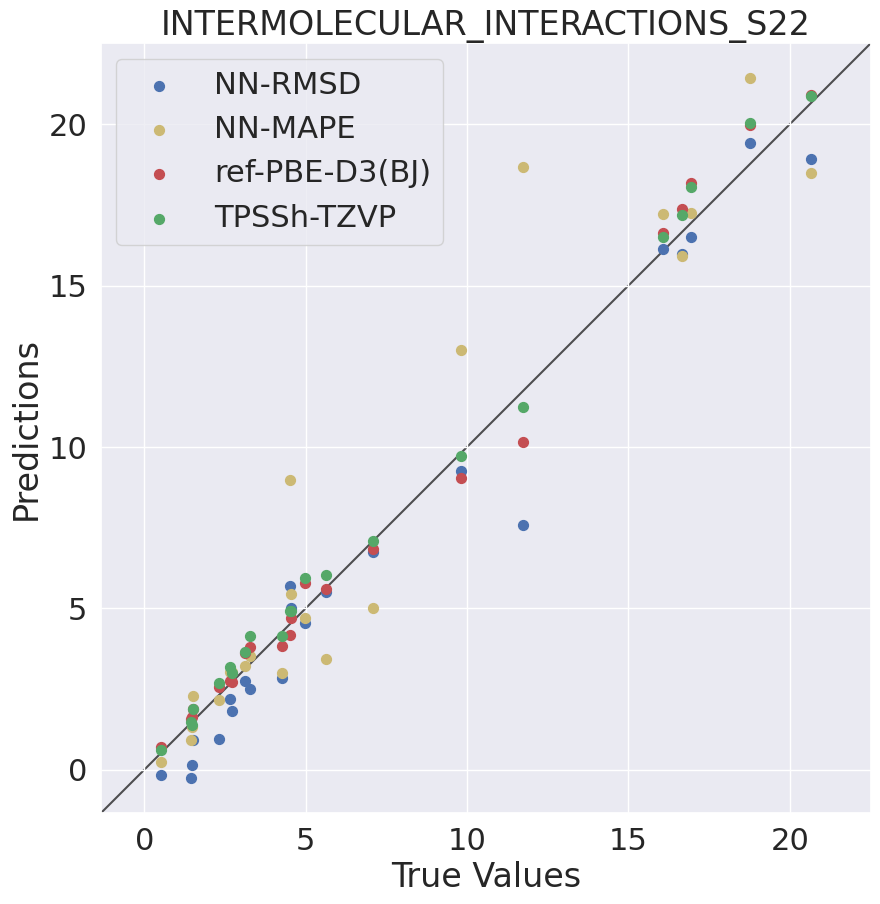

RMSE  INTERMOLECULAR_INTERACTIONS_S66  :   0.67
MAPE  INTERMOLECULAR_INTERACTIONS_S66  :   0.14
R2    INTERMOLECULAR_INTERACTIONS_S66  :   0.97
RMSE MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.86
MAPE MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.13
R2   MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.96


<Figure size 1000x1000 with 0 Axes>

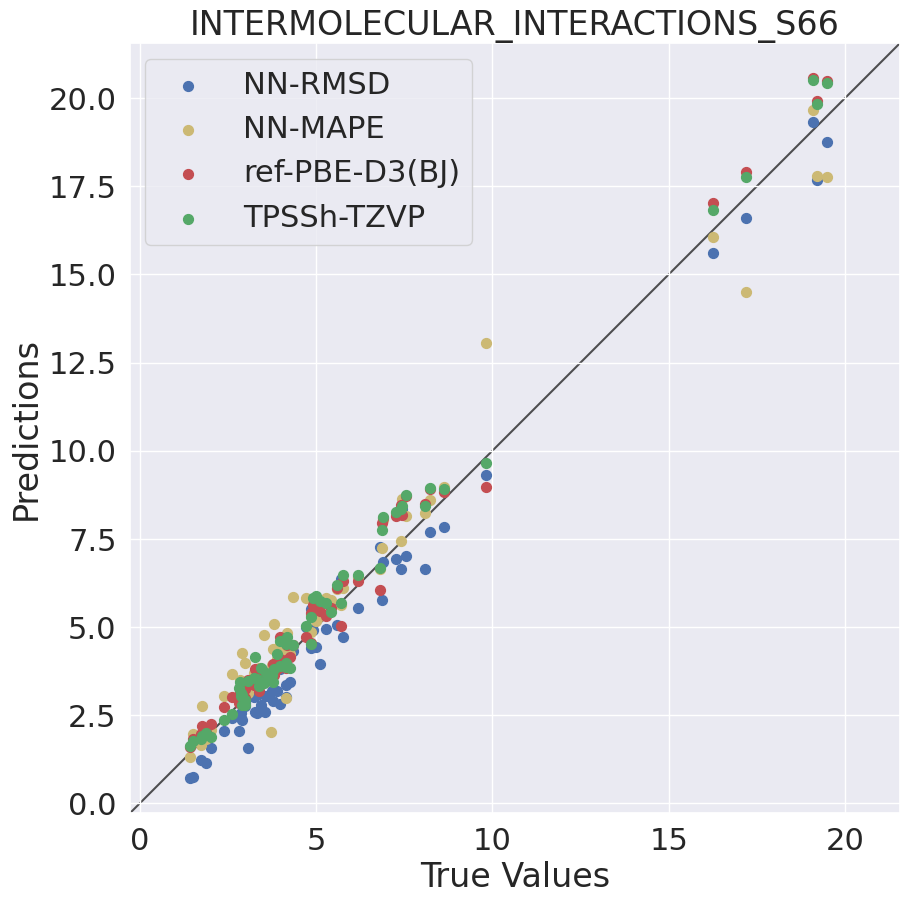

RMSE  INTERMOLECULAR_INTERACTIONS_WATER27  :   6.34
MAPE  INTERMOLECULAR_INTERACTIONS_WATER27  :   0.08
R2    INTERMOLECULAR_INTERACTIONS_WATER27  :   0.99
RMSE MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   6.32
MAPE MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   0.05
R2   MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   0.99


<Figure size 1000x1000 with 0 Axes>

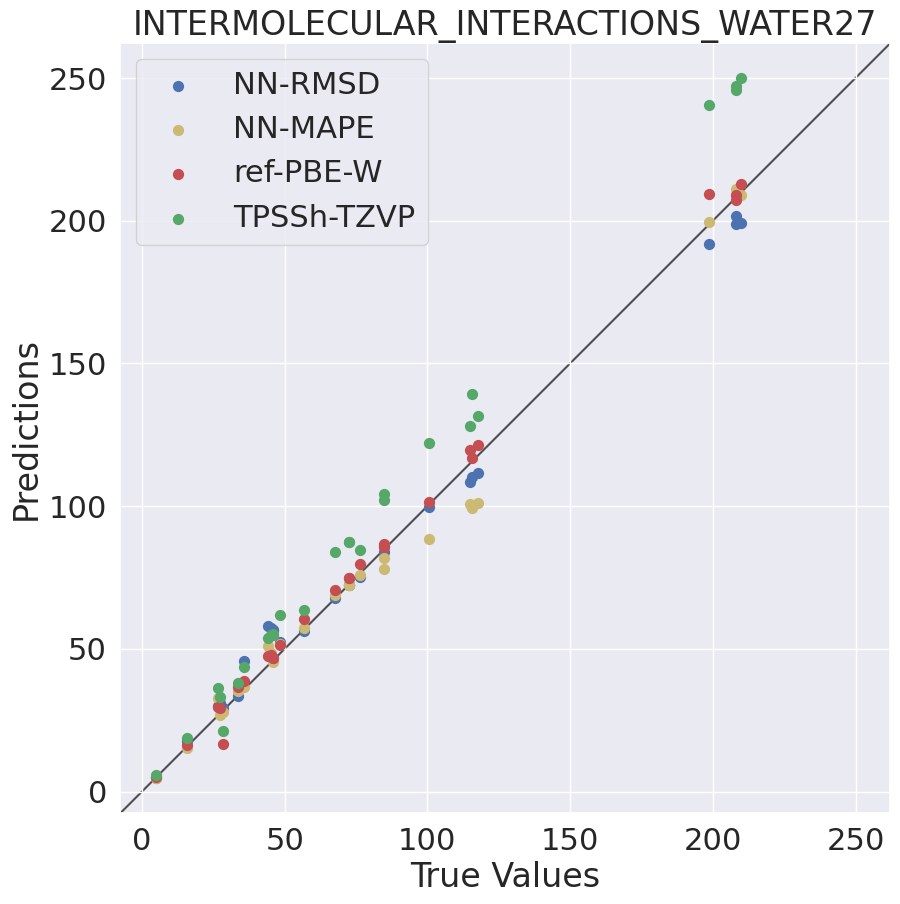

RMSE  LARGE_SYSTEMS  :  13.47
MAPE  LARGE_SYSTEMS  :   0.72
R2    LARGE_SYSTEMS  :   1.00
RMSE MAPE LARGE_SYSTEMS  :  12.72
MAPE MAPE LARGE_SYSTEMS  :   0.75
R2   MAPE LARGE_SYSTEMS  :   1.00


<Figure size 1000x1000 with 0 Axes>

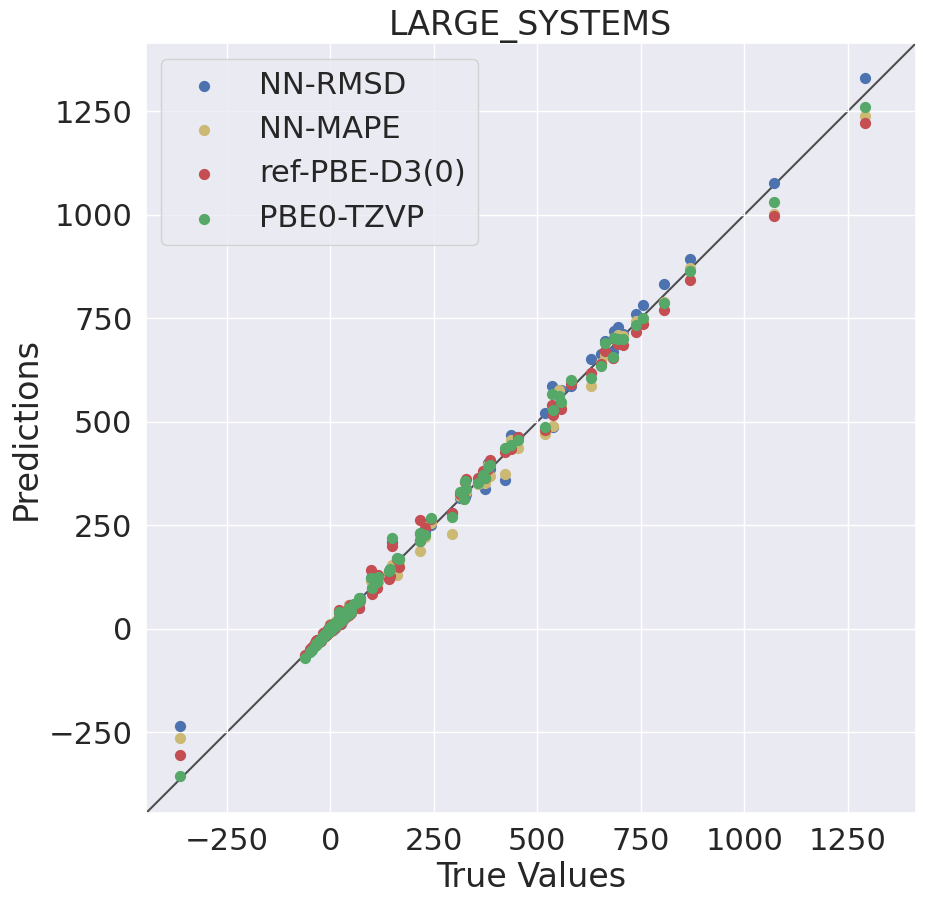

RMSE  LARGE_SYSTEMS_BSR36  :   2.77
MAPE  LARGE_SYSTEMS_BSR36  :   0.26
R2    LARGE_SYSTEMS_BSR36  :   0.93
RMSE MAPE LARGE_SYSTEMS_BSR36  :   1.73
MAPE MAPE LARGE_SYSTEMS_BSR36  :   0.13
R2   MAPE LARGE_SYSTEMS_BSR36  :   0.97


<Figure size 1000x1000 with 0 Axes>

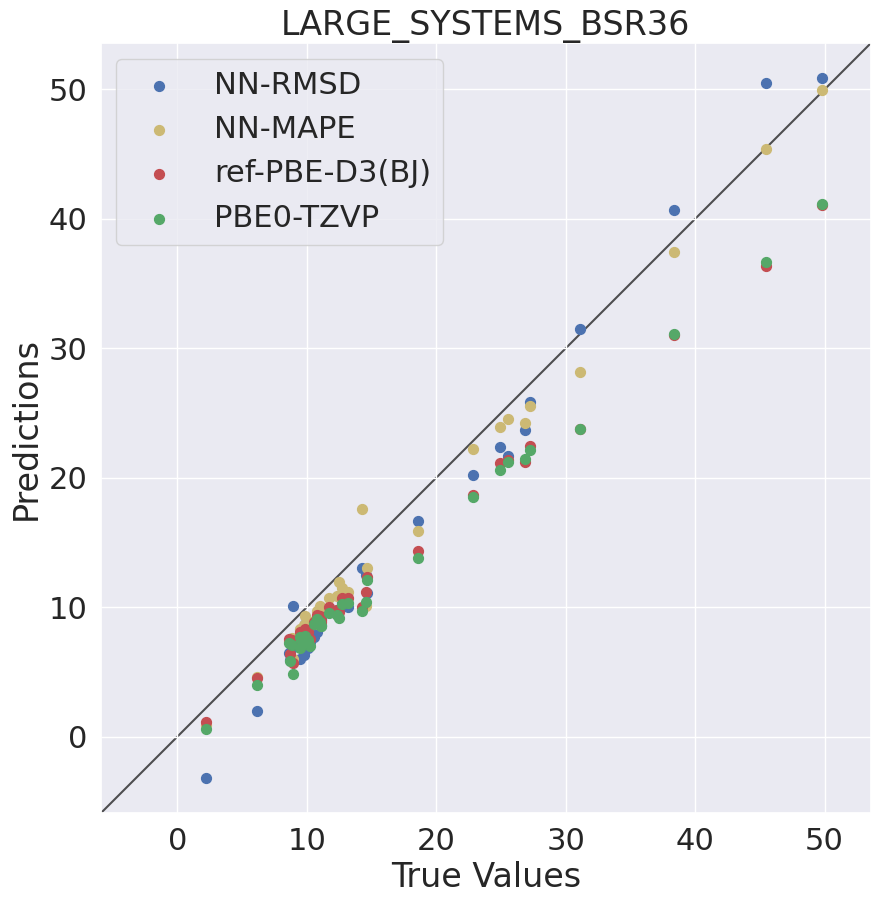

RMSE  LARGE_SYSTEMS_C60ISO  :   2.20
MAPE  LARGE_SYSTEMS_C60ISO  :   0.02
R2    LARGE_SYSTEMS_C60ISO  :   1.00
RMSE MAPE LARGE_SYSTEMS_C60ISO  :   2.65
MAPE MAPE LARGE_SYSTEMS_C60ISO  :   0.02
R2   MAPE LARGE_SYSTEMS_C60ISO  :   1.00


<Figure size 1000x1000 with 0 Axes>

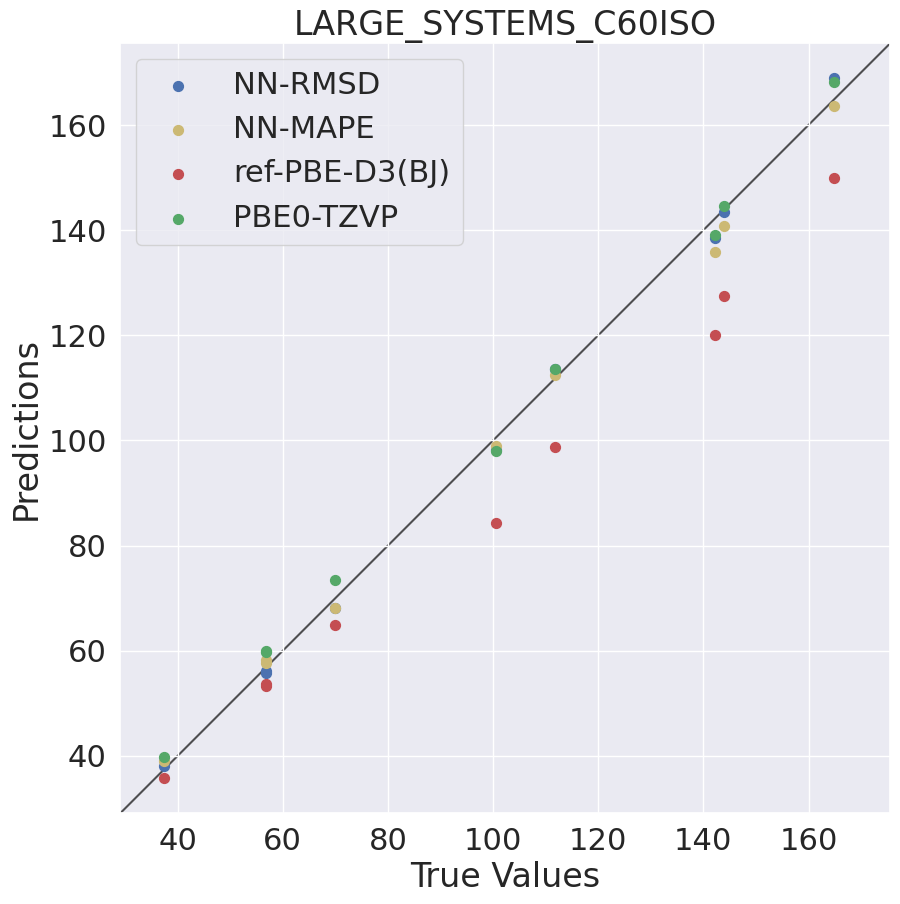

RMSE  LARGE_SYSTEMS_CDIE20  :   1.07
MAPE  LARGE_SYSTEMS_CDIE20  :   0.23
R2    LARGE_SYSTEMS_CDIE20  :   0.91
RMSE MAPE LARGE_SYSTEMS_CDIE20  :   1.04
MAPE MAPE LARGE_SYSTEMS_CDIE20  :   0.24
R2   MAPE LARGE_SYSTEMS_CDIE20  :   0.92


<Figure size 1000x1000 with 0 Axes>

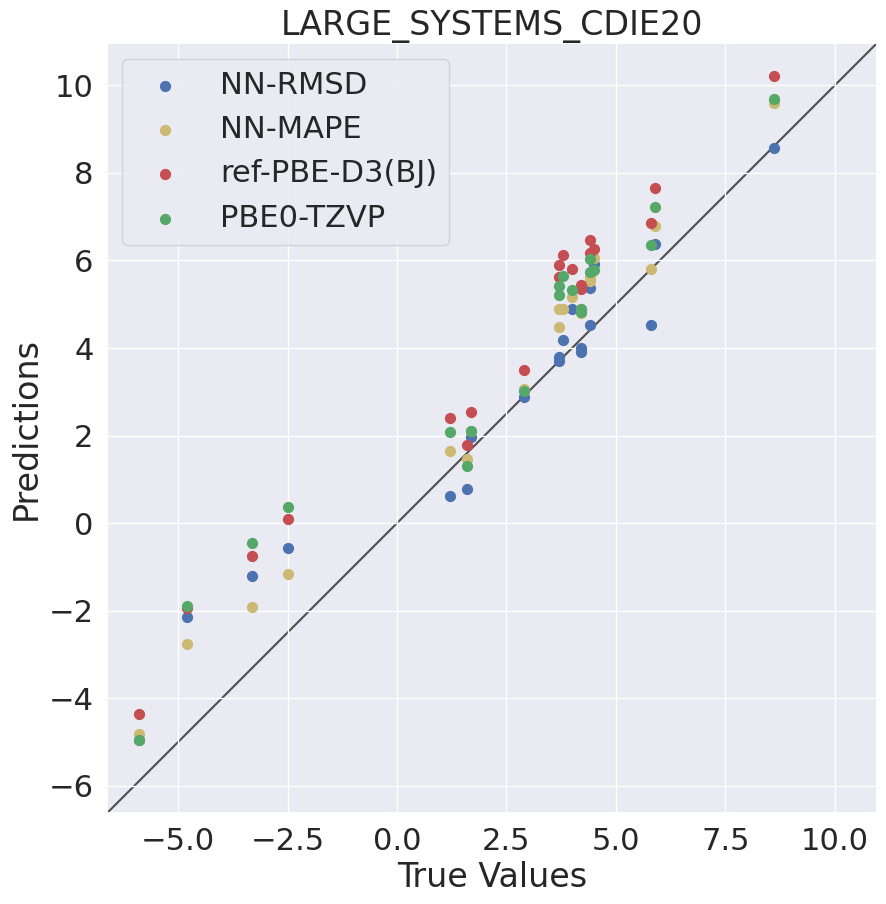

RMSE  LARGE_SYSTEMS_DARC  :   2.09
MAPE  LARGE_SYSTEMS_DARC  :   0.05
R2    LARGE_SYSTEMS_DARC  :   0.97
RMSE MAPE LARGE_SYSTEMS_DARC  :   3.15
MAPE MAPE LARGE_SYSTEMS_DARC  :   0.09
R2   MAPE LARGE_SYSTEMS_DARC  :   0.94


<Figure size 1000x1000 with 0 Axes>

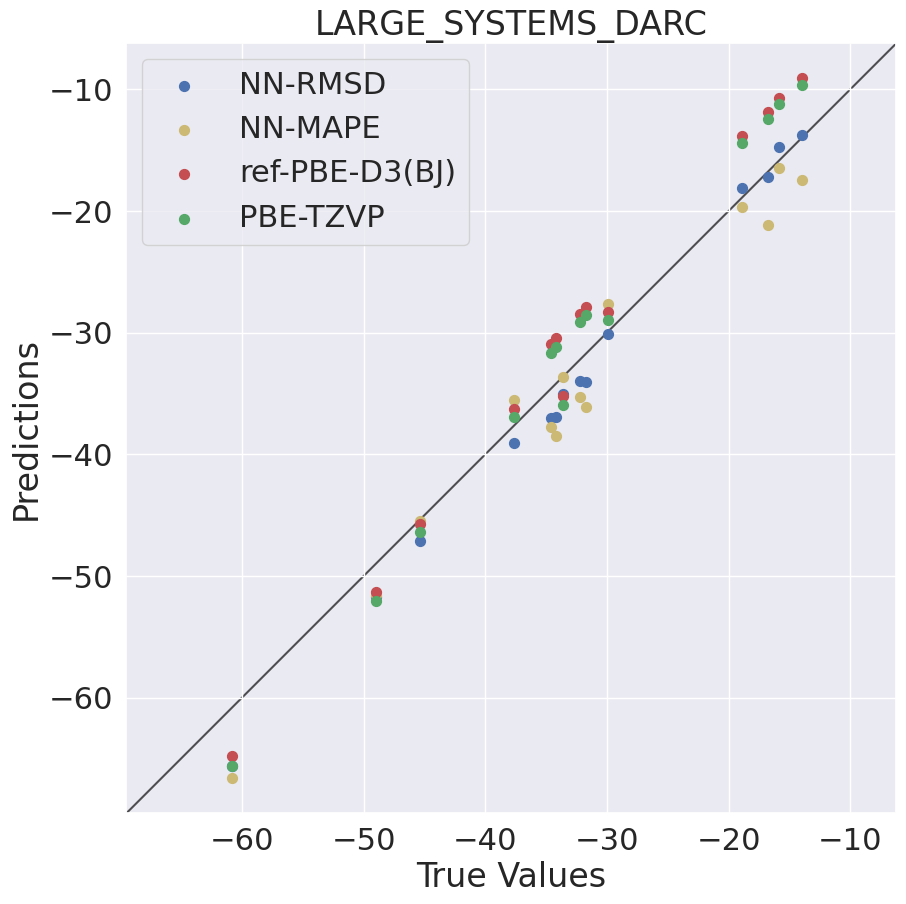

RMSE  LARGE_SYSTEMS_ISO34  :   3.78
MAPE  LARGE_SYSTEMS_ISO34  :   0.50
R2    LARGE_SYSTEMS_ISO34  :   0.93
RMSE MAPE LARGE_SYSTEMS_ISO34  :   2.88
MAPE MAPE LARGE_SYSTEMS_ISO34  :   0.33
R2   MAPE LARGE_SYSTEMS_ISO34  :   0.96


<Figure size 1000x1000 with 0 Axes>

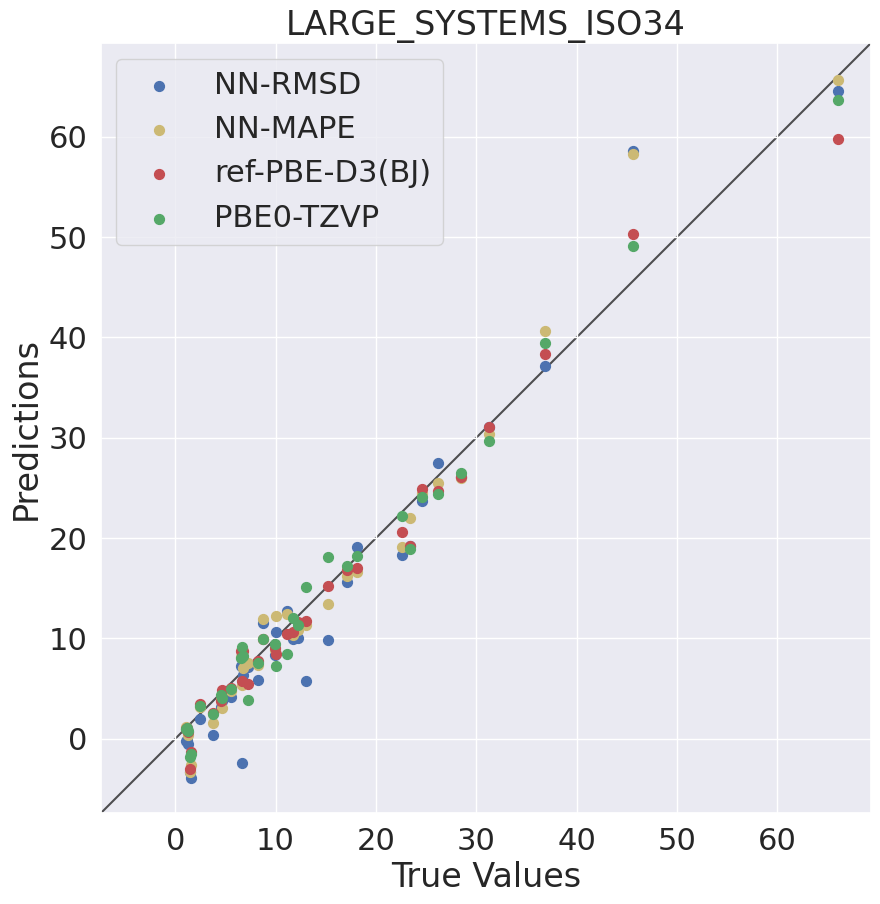

RMSE  LARGE_SYSTEMS_ISOL24  :   6.54
MAPE  LARGE_SYSTEMS_ISOL24  :   3.20
R2    LARGE_SYSTEMS_ISOL24  :   0.87
RMSE MAPE LARGE_SYSTEMS_ISOL24  :   5.30
MAPE MAPE LARGE_SYSTEMS_ISOL24  :   3.65
R2   MAPE LARGE_SYSTEMS_ISOL24  :   0.91


<Figure size 1000x1000 with 0 Axes>

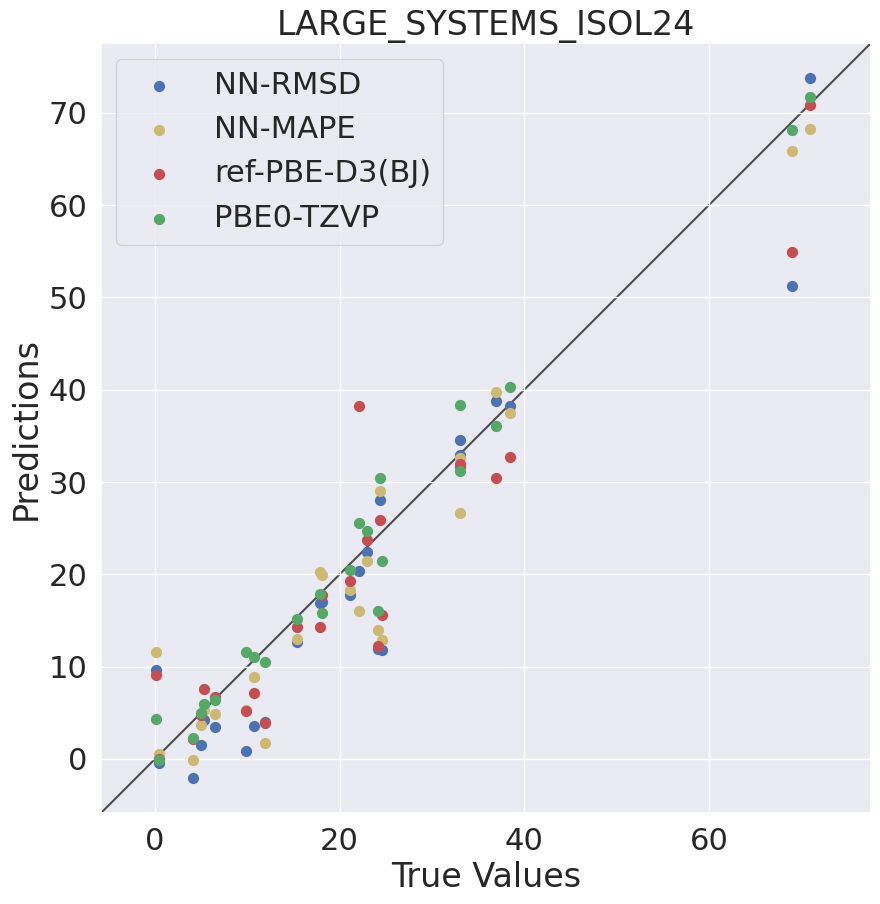

RMSE  LARGE_SYSTEMS_MB16-43  :  31.19
MAPE  LARGE_SYSTEMS_MB16-43  :   0.06
R2    LARGE_SYSTEMS_MB16-43  :   0.99
RMSE MAPE LARGE_SYSTEMS_MB16-43  :  29.58
MAPE MAPE LARGE_SYSTEMS_MB16-43  :   0.06
R2   MAPE LARGE_SYSTEMS_MB16-43  :   0.99


<Figure size 1000x1000 with 0 Axes>

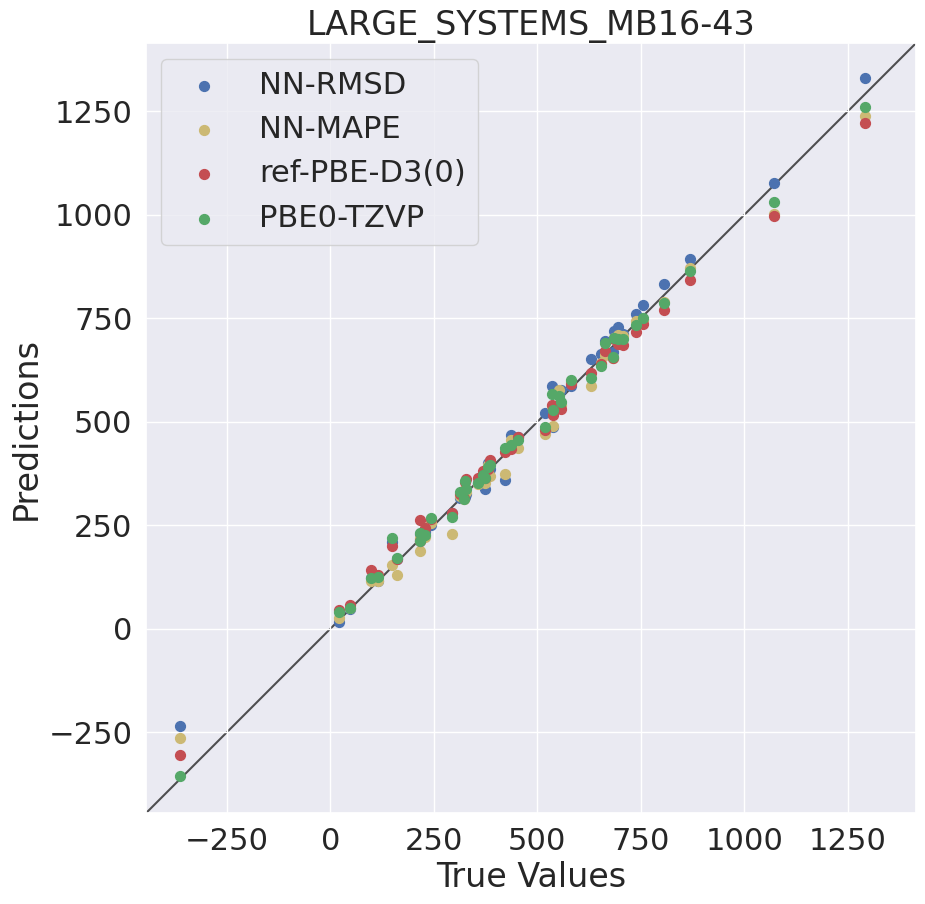

RMSE  LARGE_SYSTEMS_PArel  :   2.25
MAPE  LARGE_SYSTEMS_PArel  :   0.97
R2    LARGE_SYSTEMS_PArel  :   0.71
RMSE MAPE LARGE_SYSTEMS_PArel  :   2.23
MAPE MAPE LARGE_SYSTEMS_PArel  :   0.66
R2   MAPE LARGE_SYSTEMS_PArel  :   0.71


<Figure size 1000x1000 with 0 Axes>

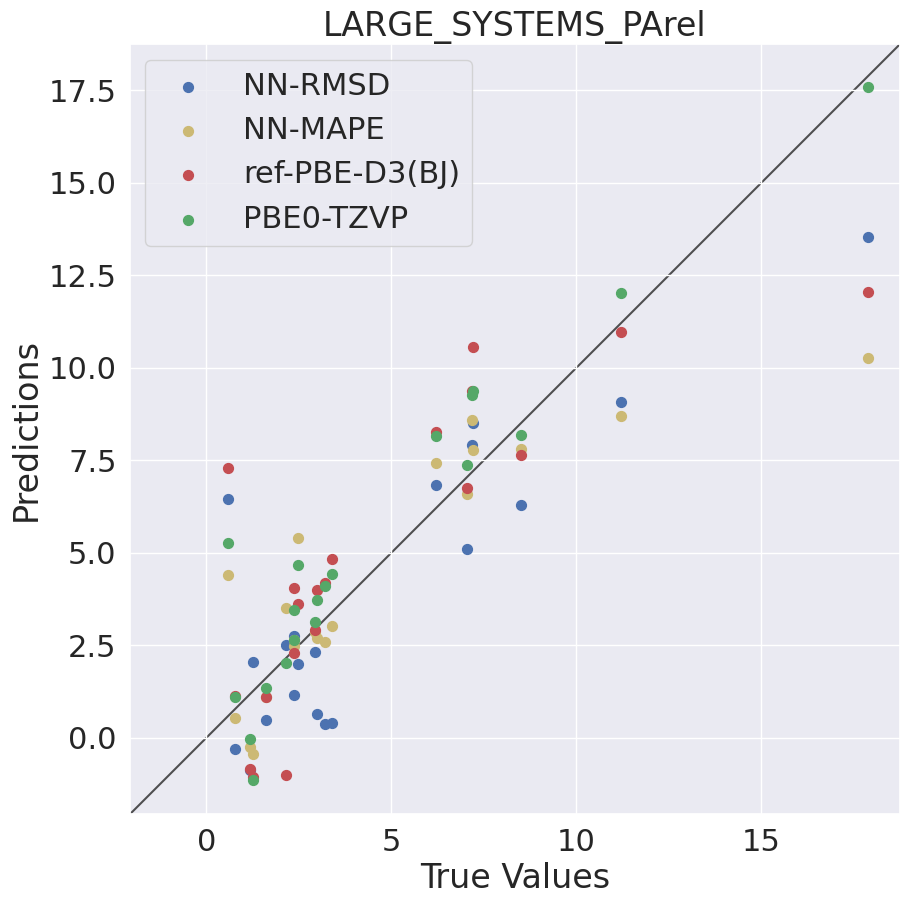

RMSE  LARGE_SYSTEMS_RSE43  :   2.29
MAPE  LARGE_SYSTEMS_RSE43  :   1.05
R2    LARGE_SYSTEMS_RSE43  :   0.90
RMSE MAPE LARGE_SYSTEMS_RSE43  :   2.73
MAPE MAPE LARGE_SYSTEMS_RSE43  :   1.30
R2   MAPE LARGE_SYSTEMS_RSE43  :   0.86


<Figure size 1000x1000 with 0 Axes>

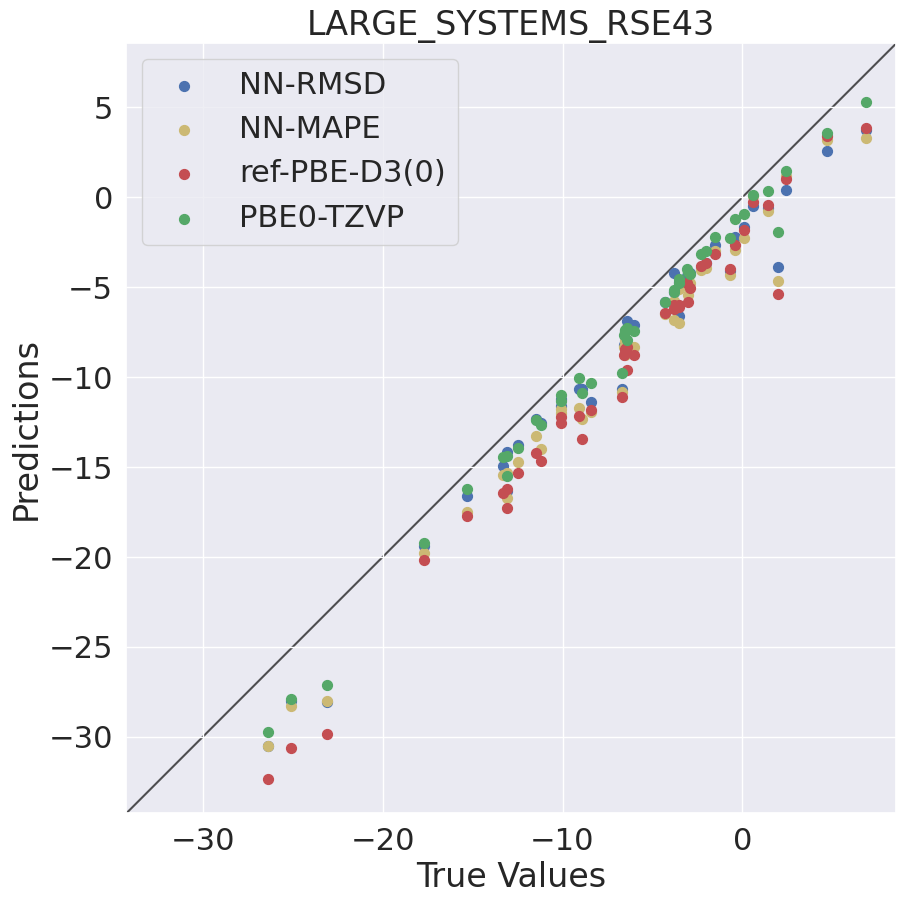

RMSE  Full  :   8.21
MAPE  Full  :   0.65
R2    Full  :   1.00
RMSE MAPE Full  :   7.33
MAPE MAPE Full  :   0.46
R2   MAPE Full  :   1.00


<Figure size 1000x1000 with 0 Axes>

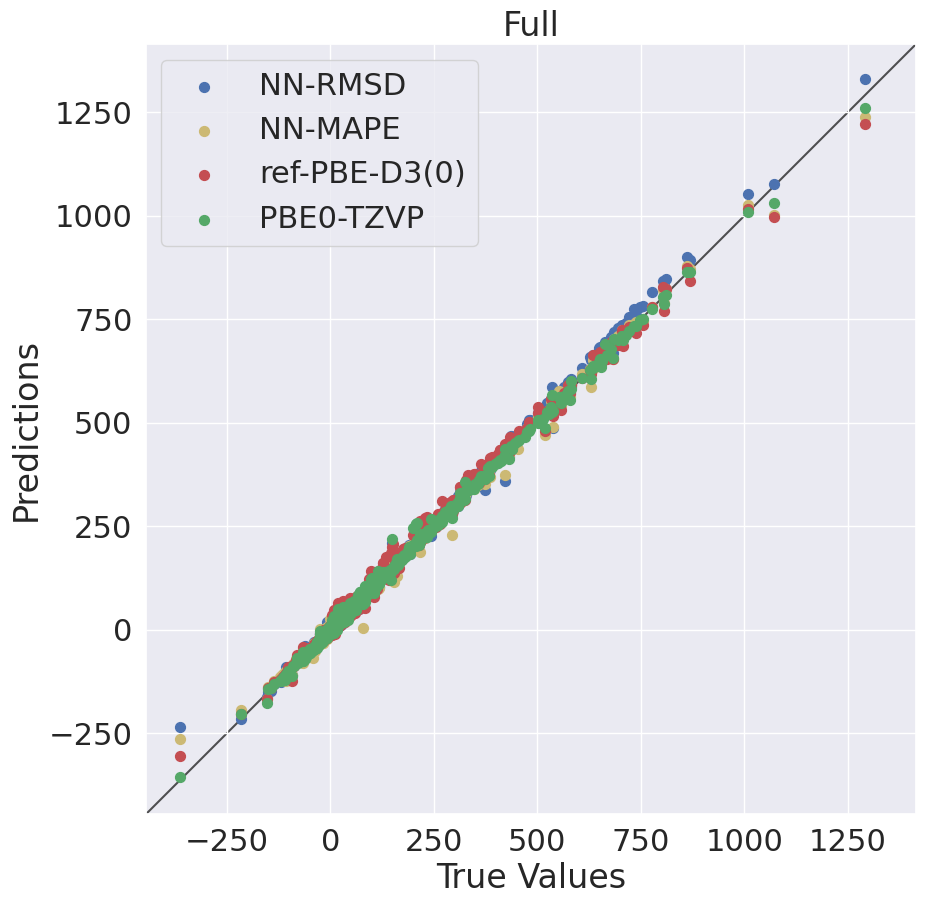

In [19]:
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred = models_results[setname].y_pred 
    rmse = mean_squared_error(Y, y_pred, squared=False)
    mape = mean_absolute_percentage_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    print("RMSE ", setname, " : %6.2f"%rmse)
    print("MAPE ", setname, " : %6.2f"%mape)
    print("R2   ", setname, " : %6.2f"%r2)
    
    y_pred_mape = models_results[setname].y_pred_mape
    rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    mape = mean_absolute_percentage_error(Y, y_pred_mape)
    r2 = r2_score(Y, y_pred_mape)
    print("RMSE MAPE", setname, " : %6.2f"%rmse)
    print("MAPE MAPE", setname, " : %6.2f"%mape)
    print("R2   MAPE", setname, " : %6.2f"%r2)
    plt.clf()
    #plt.scatter(Y, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='NN-RMSD')
    ax.scatter(Y, y_pred_mape, c='y', s=50, label='NN-MAPE')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label= f"ref-PBE-{models_results[setname].bestinsidemethod}")
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label=f"{models_results[setname].bestourmethod}-{basis_set}")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()